In [ ]:
!pip install openpyxl

In [1]:
import pandas as pd
import csv
tt_bg_FL = pd.read_excel("bg_fl_2022.xlsx")

In [ ]:
tt_bg_FL.shape

In [2]:
geom_tt_bg_FL = pd.read_csv("fl_bg_ses_geom.csv",delimiter = ";")

(13350, 3)
          GEOID NAME                                           geometry
0  120860001303    3  MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...
1  121030268141    1  MULTIPOLYGON (((-82.70074 28.03389, -82.69772 ...
2  120570065041    1  MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...
3  121270803003    3  MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...
4  120710501064    4  MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...


<Axes: >

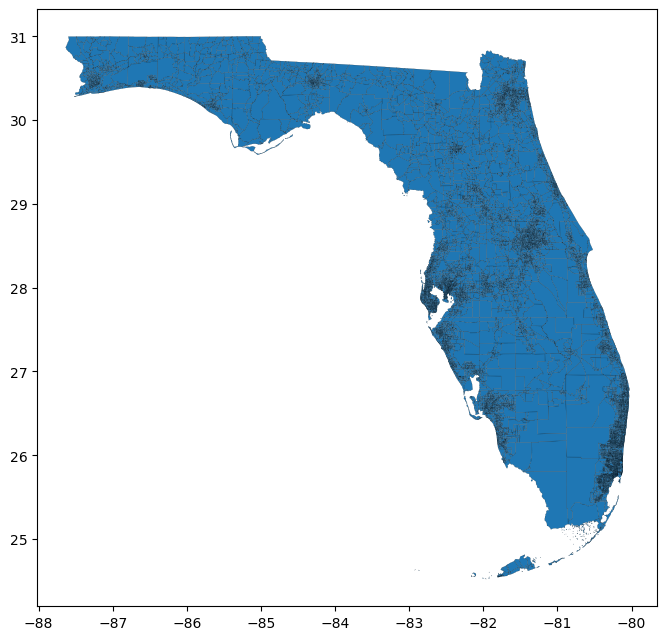

In [3]:
import geopandas as gpd

# Read the file you just wrote in R
ses_gdf = gpd.read_file("fl_bg.geojson")

# Inspect
print(ses_gdf.shape)        # should be (13350, 3) if you had 2 attribute fields + geometry
print(ses_gdf.head())

# Quick plot
ses_gdf.plot(figsize=(8,8), edgecolor="black", linewidth=0.1)


In [4]:
import os
import math
import logging
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Point

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM  # Assuming these might be used later from original imports
from peft import PeftModel


In [5]:

CONFIG = {
    # File Paths
    "HEX_FILE_PATH": "Hex_tesse_raw.parquet",
    "POI_FILE_PATH": "Hull_FL_poi_vec_subset.csv",
    "CHECKPOINT_PATH": "bottleneck_mlp_newdata.pth",
    "OUTPUT_PATH": "POI_encoded_embeddings.parquet",
    
    # Coordinate Reference Systems
    "CRS_GEOGRAPHIC": "EPSG:4326",
    "CRS_PROJECTED": "EPSG:5070",  # Using an equal-area projection for the US
    
    # Model Hyperparameters
    "LATENT_DIM": 64,
    "HIDDEN_DIM": 256,
    
    # Training Hyperparameters
    "BATCH_SIZE": 128,
    "LEARNING_RATE": 1e-4,
    "EPOCHS": 40,
    
    # System Configuration
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "NUM_WORKERS": 4,
}

# ─── PyTorch Model Definition ────────────────────────────────────────────────

class BottleneckMLP(nn.Module):
    """A Bottleneck Multi-Layer Perceptron for dimensionality reduction and classification."""
    def __init__(self, in_dim, hid_dim, lat_dim, n_cls):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(hid_dim, lat_dim),
            nn.LeakyReLU(0.01, inplace=True)
        )
        self.head = nn.Linear(lat_dim, n_cls)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.head(z)
        return z, logits

# ─── Data Loading and Preprocessing Functions ────────────────────────────────

def load_hexagon_data(file_path, crs):
    """Loads and preprocesses the hexagon GeoDataFrame."""
    logging.info(f"Loading hexagon data from {file_path}...")
    hex_gdf = pd.read_parquet(file_path)
    hex_gdf = hex_gdf.reset_index(drop=True)
    hex_gdf["hex_id"] = hex_gdf.index.astype(str)
    hex_gdf["geometry"] = gpd.GeoSeries.from_wkb(hex_gdf["geometry"])
    hex_gdf = gpd.GeoDataFrame(hex_gdf, geometry="geometry", crs=crs)
    logging.info(f"Hexagon data loaded with {len(hex_gdf)} hexagons.")
    return hex_gdf

def load_poi_data(file_path, crs):
    """Loads and preprocesses the POI GeoDataFrame."""
    logging.info(f"Loading POI data from {file_path}...")
    table = pv.read_csv(
        file_path,
        read_options=ReadOptions(block_size=1 << 20),
        parse_options=ParseOptions(delimiter=",", quote_char='"', newlines_in_values=True)
    )
    df = table.to_pandas()
    df["geometry"] = df["geometry"].apply(wkt.loads)
    poi_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    logging.info(f"POI data loaded with {len(poi_gdf)} points.")
    return poi_gdf

def parse_vector_column(series: pd.Series) -> np.ndarray:
    """Parses a string representation of vectors into a stacked NumPy array."""
    logging.info("Parsing string vectors into NumPy array...")
    def parse_vec(s: str) -> np.ndarray:
        if isinstance(s, (list, np.ndarray)):
            return np.array(s, dtype=np.float32)
        return np.fromstring(s.strip("[]"), sep=" ", dtype=np.float32)
    
    vecs = np.stack(series.map(parse_vec).values)
    return vecs

# ─── Model Training and Inference Functions ──────────────────────────────────

def train_or_load_model(config, loader, n_classes, class_labels):
    """Instantiates the model and optimizer, then loads from checkpoint or trains."""
    logging.info("Initializing model, optimizer, and criterion...")
    model = BottleneckMLP(
        in_dim=loader.dataset.tensors[0].shape[1],
        hid_dim=config["HIDDEN_DIM"],
        lat_dim=config["LATENT_DIM"],
        n_cls=n_classes
    ).to(config["DEVICE"])

    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
    criterion = nn.CrossEntropyLoss()

    if os.path.exists(config["CHECKPOINT_PATH"]):
        logging.info(f"Loading pretrained model from {config['CHECKPOINT_PATH']}")
        ckpt = torch.load(config["CHECKPOINT_PATH"], map_location=config["DEVICE"])
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    else:
        logging.info("No checkpoint found—starting training from scratch.")
        for epoch in range(1, config["EPOCHS"] + 1):
            model.train()
            loop = tqdm(loader, desc=f"Epoch {epoch}/{config['EPOCHS']}", unit="batch")
            total_loss = 0.0
            for xb, yb in loop:
                xb, yb = xb.to(config["DEVICE"]), yb.to(config["DEVICE"])
                optimizer.zero_grad()
                _, logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * xb.size(0)
                loop.set_postfix(loss=loss.item())
            avg_loss = total_loss / len(loader.dataset)
            print(f"→ Epoch {epoch:2d}: avg loss = {avg_loss:.4f}")
        
        logging.info(f"Training complete—saving checkpoint to {config['CHECKPOINT_PATH']}")
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "classes": class_labels
        }, config["CHECKPOINT_PATH"])
    
    return model

def encode_features(model, loader, device):
    """Runs inference to generate latent embeddings for the input data."""
    logging.info("Encoding features to generate latent vectors (Z)...")
    model.eval()
    all_z = []
    with torch.no_grad():
        for xb, _ in tqdm(loader, desc="Encoding"):
            xb = xb.to(device)
            z = model.encoder(xb)
            all_z.append(z.cpu().numpy())
    
    return np.vstack(all_z)

# ─── Geospatial Processing Function ──────────────────────────────────────────

def assign_pois_to_hexagons(poi_gdf, hex_gdf):
    """Reprojects and performs a nearest-neighbor join to assign POIs to hexagons."""
    logging.info("Reprojecting GeoDataFrames to equal-area CRS for accurate nearest-neighbor search...")
    poi_proj = poi_gdf.to_crs(epsg=CONFIG["CRS_PROJECTED"])
    hex_proj = hex_gdf.to_crs(epsg=CONFIG["CRS_PROJECTED"])

    logging.info("Assigning POIs to nearest hexagon...")
    joined_gdf = gpd.sjoin_nearest(
        poi_proj,
        hex_proj[["hex_id", "geometry"]],
        how="left"
    )

    logging.info(f"Join completed. Matched points: {joined_gdf['hex_id'].notna().sum()}/{len(poi_gdf)}")
    
    # Reproject final result back to geographic coordinates
    joined_gdf = joined_gdf.to_crs(epsg=CONFIG["CRS_GEOGRAPHIC"])
    return joined_gdf

In [6]:
hex_gdf = load_hexagon_data("Hex_tesse_raw.parquet","epsg:4326")

In [7]:
try:
    hex_gdf = hex_gdf.drop(columns="hexid")
except Exception as e:
    print("deleted")
print(hex_gdf)

                                                geometry hex_id
0      POLYGON ((-88.55028 30.36403, -88.54055 30.359...      0
1      POLYGON ((-88.55028 30.37372, -88.55028 30.364...      1
2      POLYGON ((-88.55028 30.3931, -88.54055 30.3882...      2
3      POLYGON ((-88.55028 30.40278, -88.55028 30.393...      3
4      POLYGON ((-88.55028 30.42215, -88.54055 30.417...      4
...                                                  ...    ...
67963  POLYGON ((-79.95377 26.33337, -79.95377 26.343...  67963
67964  POLYGON ((-79.95377 26.36356, -79.95377 26.373...  67964
67965  POLYGON ((-79.94405 26.37865, -79.94405 26.388...  67965
67966  POLYGON ((-79.94405 26.38871, -79.95377 26.393...  67966
67967  POLYGON ((-79.95377 26.42391, -79.95377 26.433...  67967

[67968 rows x 2 columns]


In [8]:
ses_gdf = ses_gdf.to_crs("EPSG:4326")

In [9]:
ses_gdf

,GEOID,NAME,geometry
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ..."
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ..."
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ..."
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ..."
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ..."
...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ..."
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ..."
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ..."
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ..."


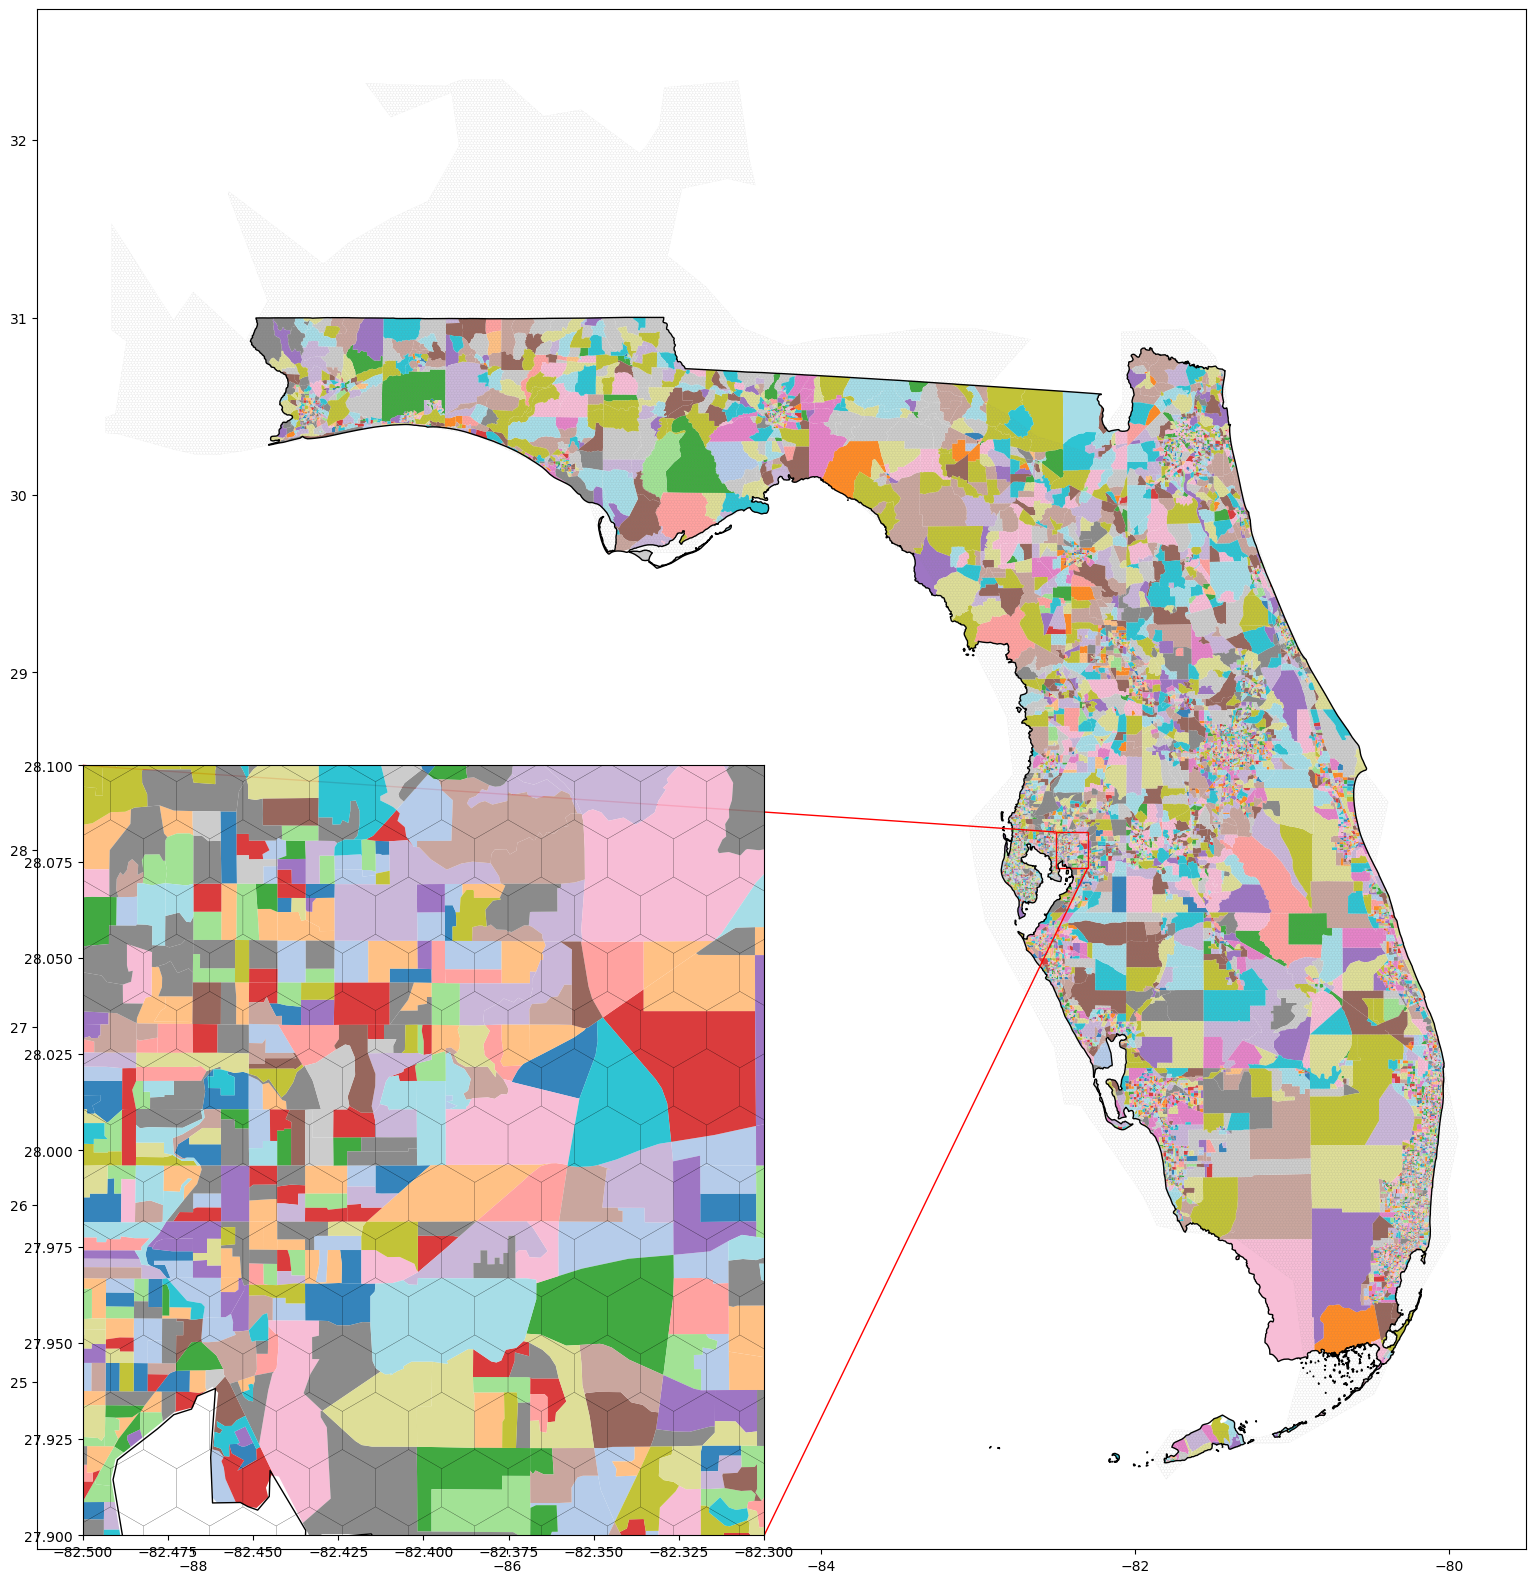

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(20, 20))

hex_gdf.boundary.plot(ax=ax, linewidth=0.05, edgecolor="gray",alpha=0.5)
states = gpd.read_file('cb_2018_us_state_500k.shp')
#state_plot = states.to_crs(epsg=3857)
states[states.STUSPS == "FL"].boundary.plot(
    ax=ax, linewidth=1, color="black"
)
ses_gdf.plot(ax=ax,cmap = "tab20", alpha = 0.9)
xmin, ymin, xmax, ymax = (-82.5, 27.9, -82.3, 28.1)  # example in EPSG:3857 coords

# 6) Create an inset axes for the zoom
axins = inset_axes(ax, width="50%", height="50%", loc="lower left", borderpad=1)
axins.set_xlim(xmin, xmax)
axins.set_ylim(ymin, ymax)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="red", lw=1)
hex_gdf.boundary.plot(ax=axins, linewidth=0.1, edgecolor="black",alpha=0.9)
#ax.axes(False)
states[states.STUSPS == "FL"].boundary.plot(
    ax=axins, linewidth=1, color="black"
)
ses_gdf.plot(ax=axins,cmap = "tab20", alpha = 0.9)
plt.savefig("hex_tess_ses.png",dpi=300)
plt.show()

In [10]:
gdf = gpd.read_parquet("POI_encoded_embeddings.parquet")

In [11]:

# 2) Expand the `z` list/array into its own DataFrame of shape (N, D)
#    so each dimension becomes a column z0, z1, ..., z{D-1}
z_expanded = pd.DataFrame(
    gdf["z"].tolist(),
    index=gdf.index
)
z_expanded.columns = [f"z{i}" for i in range(z_expanded.shape[1])]

# 3) Combine back with the labels
df_expanded = pd.concat([gdf["label_pair"], z_expanded], axis=1)

# 4) Group by label_pair and take the mean → this is your “center” per class
centers_df = df_expanded.groupby("label_pair").mean()

In [12]:

ses_gdf = ses_gdf.reset_index(drop=True)

# 2) copy that index into your new hex_id column
ses_gdf["hex_id"] = ses_gdf.index
ses_gdf

,GEOID,NAME,geometry,hex_id
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4
...,...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ...",13345
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ...",13346
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ...",13347
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ...",13348


In [ ]:
gdf

In [13]:
#ses_gdf.to_crs(ESPG:5070)
gdf = gdf.to_crs(ses_gdf.crs)
#gdf = gdf.drop(columns=["hex_id"])
# 2) keep only the hex_id + geometry in the hex‐grid
hexes = ses_gdf[["hex_id", "geometry"]]

# 3) spatial join: for each point, find the hex whose polygon it lies within
#    – predicate="within" for GeoPandas ≥ 0.10, or op="within" for older versions
joined = gpd.sjoin(
    gdf,
    hexes,
    how="left",          # keep all points, even those that fall outside
    #predicate="within"   # use "op='within'" if your GeoPandas is <0.10
)

# 4) clean up the result: drop the auto‐added index_right column
joined = joined.drop(columns=["hex_id_left","index_right"])

# now `joined` has all of your original point columns **plus** a `hex_id` column
print(joined)
joined = joined.rename(columns={"hex_id_right":"hex_id"})

                                                label_pair  \
0        Activities Related to Real Estate[sep]Resident...   
1        Offices of Real Estate Agents and Brokers[sep]...   
2        Sporting Goods, Hobby, and Musical Instrument ...   
3              Offices of Dentists[sep]Offices of Dentists   
4        Museums, Historical Sites, and Similar Institu...   
...                                                    ...   
1548012  Home Furnishings Stores[sep]All Other Home Fur...   
1548013  Urban Transit Systems[sep]Bus and Other Motor ...   
1548014  Urban Transit Systems[sep]Bus and Other Motor ...   
1548015  Urban Transit Systems[sep]Bus and Other Motor ...   
1548016  Urban Transit Systems[sep]Bus and Other Motor ...   

                                                         z  \
0        [61.499184, 25.730932, 28.544409, 16.33576, 38...   
1        [10.239435, 8.276576, 44.785103, 72.61034, 19....   
2        [23.133112, 20.673256, 16.964842, 24.288828, 2...   
3      

In [14]:
print(sum(joined["hex_id"].isna())/len(joined))
joined = joined.dropna(subset=["hex_id"])
joined.to_crs("EPSG:4326")
print(joined)
#joined["hex_id"] = joined["hex_id"].apply(int)

0.052140786858049966
                                                label_pair  \
0        Activities Related to Real Estate[sep]Resident...   
1        Offices of Real Estate Agents and Brokers[sep]...   
2        Sporting Goods, Hobby, and Musical Instrument ...   
3              Offices of Dentists[sep]Offices of Dentists   
4        Museums, Historical Sites, and Similar Institu...   
...                                                    ...   
1548012  Home Furnishings Stores[sep]All Other Home Fur...   
1548013  Urban Transit Systems[sep]Bus and Other Motor ...   
1548014  Urban Transit Systems[sep]Bus and Other Motor ...   
1548015  Urban Transit Systems[sep]Bus and Other Motor ...   
1548016  Urban Transit Systems[sep]Bus and Other Motor ...   

                                                         z  \
0        [61.499184, 25.730932, 28.544409, 16.33576, 38...   
1        [10.239435, 8.276576, 44.785103, 72.61034, 19....   
2        [23.133112, 20.673256, 16.964842, 24.28

In [15]:
mean_vecs = (
    joined
    .groupby('hex_id')['z']
    .agg(lambda arrs: np.mean(np.stack(arrs.values), axis=0))
)
# mean_vecs is a Series: index=hex_id, value=np.ndarray(1152,)

# 2a) merge into hex_gdf
ses_gdf = ses_gdf.merge(
    mean_vecs.rename('vec_mean'),
    left_on='hex_id',
    right_index=True,
    how='left'
)



In [16]:
tt_bg_FL["GEOID"] = tt_bg_FL["GEOID"].astype(str)

# (optional) also ensure ses_gdf.GEOID is string
ses_gdf["GEOID"] = ses_gdf["GEOID"].astype(str)

# 3) now do the merge
merged = ses_gdf.merge(
    tt_bg_FL,
    on="GEOID",
    how="left"   # or "inner" if you only want matching IDs
)

# 4) merged is still a GeoDataFrame with geometry + your new columns
print(merged.shape)
merged.head()

(13350, 307)


,GEOID,NAME_x,geometry,hex_id,vec_mean,NAME_y,Total:,Total: Under .50,Total: .50 to .99,Total: 1.00 to 1.24,...,Total: With an Internet subscription Broadband of any type,Total: With an Internet subscription Cellular data plan,Total: With an Internet subscription Cellular data plan Cellular data plan with no other type of Internet subscription,"Total: With an Internet subscription Broadband such as cable, fiber optic or DSL","Total: With an Internet subscription Broadband such as cable, fiber optic or DSL Broadband such as cable, fiber optic or DSL with no other type of Internet subscription",Total: With an Internet subscription Satellite Internet service,Total: With an Internet subscription Satellite Internet service Satellite Internet service with no other type of Internet subscription,Total: With an Internet subscription Other service with no other type of Internet subscription,Total: Internet access without a subscription,Total: No Internet access
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0,"[33.6305, 35.814537, 14.019923, 40.46885, 28.7...",Block Group 3; Census Tract 1.30; Miami-Dade C...,279,0,42,26,...,183,183,0,160,0,33,0,0,14,0
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1,"[28.050043, 36.334988, 19.818258, 34.684147, 3...",Block Group 1; Census Tract 268.14; Pinellas C...,992,16,19,44,...,429,392,46,375,29,0,0,8,0,5
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2,"[37.87849, 41.17299, 24.685835, 38.813133, 35....",Block Group 1; Census Tract 65.04; Hillsboroug...,411,17,55,56,...,198,177,2,166,21,28,0,0,11,52
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3,"[46.378544, 34.71072, 28.458584, 43.096386, 30...",Block Group 3; Census Tract 803; Volusia Count...,1024,69,2,17,...,465,346,18,400,119,11,0,0,60,139
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4,"[39.790993, 35.508392, 29.290495, 40.39536, 39...",Block Group 4; Census Tract 501.06; Lee County...,582,0,40,0,...,350,334,33,317,16,0,0,0,35,17


In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Suppose df is your original GeoDataFrame with 307 cols:
df = merged.copy()

# 1) Pick off the columns you want to exempt (by name or by position)
exempt = list(df.columns[:7])   # e.g. first four columns
to_impute = df.columns.difference(exempt)

# 2) Fit & transform only the “to_impute” slice
imp = IterativeImputer(random_state=0)
imputed_vals = imp.fit_transform(df[to_impute])

# 3) Rebuild a new DataFrame for the imputed part
df_imp = pd.DataFrame(imputed_vals,
                      columns=to_impute,
                      index=df.index)

# 4) Concatenate the exempted + imputed parts, preserving original order
df_final = pd.concat([df[exempt], df_imp], axis=1)[df.columns]


In [ ]:
df_final.to_parquet("imputed_ses.parquet")

In [17]:
df_final = pd.read_parquet("imputed_ses.parquet")

In [ ]:
df_final

In [ ]:
import geopandas as gpd
from libpysal.weights import Queen
import networkx as nx

# 1) (Optional) make sure your geometries are in a planar CRS
#    Queen contiguity only makes sense in projected (not geographic) coordinates:
merged = merged.to_crs(epsg=3857)

# 2) build a Queen‐contiguity weight object,
#    telling PySAL which column holds the unique ID (here “hex_id”) and which holds the geometry:
wq = Queen.from_dataframe(
    merged,
    idVariable="hex_id",
    geom_col="geometry"
)

# 3) if you want the raw neighbor lists:
#    wq.neighbors is a dict: { hex_id_1: [nbr1, nbr2,…], hex_id_2: […], … }
print("example neighbors for one cell:", list(wq.neighbors.items())[:3])

# 4) to turn that into a NetworkX graph:
G = wq.to_networkx()

# 5) now you can check connectivity exactly as before
comps = list(nx.connected_components(G))
print(f"{len(comps)} components total")
islands = [c.pop() for c in comps if len(c)==1]
print("Singleton islands:", islands)
merged['centroid'] = merged.geometry.centroid
centroids = merged.set_index('hex_id')['centroid']

# 2) for each island, find its nearest neighbour and add an edge
for iso in islands:
    # distances to all other centroids
    dists = centroids.distance(centroids.loc[iso]).drop(index=iso)
    nearest = dists.idxmin()
    G.add_edge(iso, nearest)

comps   = list(nx.connected_components(G))
islands = [next(iter(c)) for c in comps if len(c) == 1]

# 2) compute centroids (once)
merged = merged.to_crs(epsg=3857)
merged['centroid'] = merged.geometry.centroid
centroids = merged.set_index('hex_id')['centroid']

# 3) stitch each singleton onto its nearest neighbor:
for iso in islands:
    dists   = centroids.distance(centroids.loc[iso]).drop(index=iso)
    nearest = dists.idxmin()
    G.add_edge(iso, nearest)

# 4) now recompute & sort your components
comps = list(nx.connected_components(G))
comps = sorted(comps, key=len, reverse=True)
main_comp = list(comps[0])

# 5) bridge every other component into the main one
for comp in comps[1:]:
    comp = list(comp)
    best_pair = None
    best_dist = float('inf')
    for hid in comp:
        dists = centroids.loc[main_comp].distance(centroids.loc[hid])
        j     = dists.idxmin()
        d     = dists.min()
        if d < best_dist:
            best_dist = d
            best_pair = (hid, j)
    # now best_pair is guaranteed to be a 2‑tuple
    G.add_edge(*best_pair)


In [ ]:
comps = list(nx.connected_components(G))
len(comps)

In [ ]:
import pickle
with open("ses_graph.pickle","wb") as f:
    pickle.dump(G,f)

In [18]:
import pickle
with open("ses_graph.pickle","rb") as f:
    G = pickle.load(f)

In [ ]:
EMBEDDING_FILENAME = "models/ses.emb"
EMBEDDING_MODEL_FILENAME = "models/ses_model_embeddings.model"
# Load model after Node2Vec.save
from node2vec import Node2Vec
from gensim.models import Word2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=128, num_walks=16, workers=10)  # Use temp_folder for big graphs
model = node2vec.fit(vector_size=64, window=16, min_count=3, workers=8)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

In [ ]:
!    pip install numpy==1.26.4

In [ ]:
!pip uninstall -y k-means-constrained

In [ ]:
!pip uninstall -y gensim
!pip install --no-cache-dir --force-reinstall "gensim==4.3.3"


In [ ]:
import sys, numpy as np
print(sys.version)
print("numpy:", np.__version__)
# import gensim  # will fail right now, that's the point


In [19]:
EMBEDDING_FILENAME = "models/ses.emb"
EMBEDDING_MODEL_FILENAME = "models/ses_model_embeddings.model"
# Load model after Node2Vec.save
import numpy as np
from node2vec import Node2Vec
from gensim.models import Word2Vec

vec_model = Word2Vec.load(EMBEDDING_MODEL_FILENAME)
embeddings = {node: vec_model.wv[node] for node in G.nodes()}
emb_dataframe = pd.DataFrame.from_dict(embeddings)

In [20]:
vecs = emb_dataframe.to_numpy().T   # shape (N, D)

# 2) turn each row into a Python list
vec_lists = vecs.tolist()           # [ [float,…,float], … ]

# 3) assign by position (assuming hex_gdf is already sorted by hex_id 0…N-1)
ses_gdf['graph_embedding'] = vec_lists

In [21]:
ses_gdf

,GEOID,NAME,geometry,hex_id,vec_mean,graph_embedding
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0,"[33.6305, 35.814537, 14.019923, 40.46885, 28.7...","[0.3094644844532013, -0.6877000331878662, 0.45..."
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1,"[28.050043, 36.334988, 19.818258, 34.684147, 3...","[0.381952166557312, -0.6988899111747742, 0.945..."
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2,"[37.87849, 41.17299, 24.685835, 38.813133, 35....","[-0.05432126671075821, -0.3860200047492981, 0...."
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3,"[46.378544, 34.71072, 28.458584, 43.096386, 30...","[0.32348284125328064, -1.2202489376068115, 0.9..."
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4,"[39.790993, 35.508392, 29.290495, 40.39536, 39...","[0.6818171143531799, -0.5163449048995972, 0.02..."
...,...,...,...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ...",13345,"[32.494717, 32.350628, 34.815083, 37.629097, 3...","[-0.0077913673594594, -1.7483948469161987, 0.8..."
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ...",13346,"[40.079212, 32.640038, 28.361559, 45.530876, 3...","[1.1937179565429688, 0.03970316797494888, 0.82..."
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ...",13347,"[43.3617, 34.59013, 32.557526, 44.64834, 31.98...","[0.27541500329971313, -0.5659998059272766, 0.2..."
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ...",13348,"[41.887966, 33.429848, 31.639544, 47.274506, 3...","[0.9910449981689453, -0.2834606170654297, 0.70..."


In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
# 4) Move to GPU/CPU and set eval mode:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 1) Where you saved your LoRA adapters after training:
CHECKPOINT = "/storage1/fs1/nlin/Active/sizhe/FO_DATA/checkpoint-dir/checkpoint-551"

# 2) Load the tokenizer from that folder (it contains tokenizer.json + vocab.txt)
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

base_name = "google/gemma-3-1b-it"     # <— exactly what you passed in your training script
base = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-1b-it",
    attn_implementation="eager"
).to(device)

# 3) Now graft the adapter weights:
llm_model = PeftModel.from_pretrained(base, CHECKPOINT,strict=False)


#llm_model.to(device).eval()



/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/peft/peft_model.py:565: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight', 'base_mo

In [23]:
def embed_texts(texts: list[str]) -> torch.Tensor:
    """
    texts: a Python list of strings (each may contain literal "[sep]").
    example: ["[Museums, Historical Sites,...<sep>Museums, Historical Sites<sep>Natural History museum]",...]
    In the format of [<category><sep><subcategory><sep><name>]
    Returns: a GPU tensor of shape (len(texts), hidden_size) containing the
             final‐token embedding for each string.
    """
    # 2.1) Clean & force everything to str, replacing None/NaN with ""
    clean_texts=[]
    for t in texts:
        if t is None:
            clean_texts.append("")
        else:
            clean_texts.append(str(t))
    sep = tokenizer.sep_token  # e.g. "[SEP]" for BERT‐style; whatever your tokenizer.sep_token is
    clean_texts = [t.replace("[sep]", sep) for t in clean_texts]
    
    # 2.3) Batch‐tokenize all strings onto GPU
    enc = tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
        return_token_type_ids=False,
    ).to(device)
    #print("Batch input_ids are on:", enc.input_ids.device)
    # Now enc.input_ids and enc.attention_mask live on GPU.

    # 2.4) Forward‐pass (no gradients) to get hidden states
    with torch.no_grad():
        outputs = llm_model.base_model(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            output_hidden_states=True
        )
        # `outputs.hidden_states` is a tuple of length (num_layers+1);
        # each element has shape (batch_size, seq_len, hidden_size).
        last_hidden = outputs.hidden_states[-1]  # (batch_size, seq_len, hidden_size) on GPU

    # 2.5) For each sequence, pick out the final non‐pad token embedding
    seq_lens = enc.attention_mask.sum(dim=1) - 1  # (batch_size,) on GPU, index of last non-pad
    batch_size, hidden_size = last_hidden.size(0), last_hidden.size(2)

    # Gather the embedding at position (i, seq_lens[i], :)
    final_embs = last_hidden[torch.arange(batch_size), seq_lens, :]  # (batch_size, hidden_size) on GPU
    #print((final_embs))
    return final_embs


In [24]:
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
null_emb   = embed_texts(["<null_val>[sep]<null_val>"]) 
# null_emb is already a tensor
print(type(null_emb), null_emb.shape, null_emb.device)

# add the batch‐dim, cast & move to DEVICE
null_tensor = null_emb.float().unsqueeze(0).to(DEVICE)
print(null_tensor, null_tensor.device)

<class 'torch.Tensor'> torch.Size([1, 1152]) cuda:0
tensor([[[ 1.4538, -8.0599,  0.6345,  ..., -0.2421,  0.9947,  0.2485]]],
       device='cuda:0') cuda:0


In [25]:

ckpt = torch.load("bottleneck_mlp_newdata.pth",map_location = "cuda",weights_only=False)

raw_classes = ckpt.get("classes", None)
# Determine number of classes
n_old = len(raw_classes) if raw_classes is not None else ckpt["model_state_dict"]["head.bias"].shape[0]

# Convert classes to Python list
if raw_classes is None:
    classes = [f"class_{{i}}" for i in range(n_old)]
elif isinstance(raw_classes, np.ndarray):
    classes = raw_classes.tolist()
else:
    classes = list(raw_classes)
# Recreate and load your original BottleneckMLP
class BottleneckMLP(nn.Module):
    def __init__(self, in_dim, hid_dim, lat_dim, n_cls):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, lat_dim),
            nn.ReLU()
        )
        self.head = nn.Linear(lat_dim, n_cls)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.head(z)
        return z, logits

# Extract dims from checkpoint
in_dim     = ckpt["model_state_dict"]["encoder.0.weight"].shape[1]
hid_dim    = ckpt["model_state_dict"]["encoder.0.weight"].shape[0]
lat_dim    = ckpt["model_state_dict"]["encoder.2.weight"].shape[0]

# Instantiate and load weights
bottleneck_model = BottleneckMLP(in_dim, hid_dim, lat_dim, n_old).to(device)
bottleneck_model.load_state_dict(ckpt["model_state_dict"])
bottleneck_model.eval()



BottleneckMLP(
  (encoder): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (head): Linear(in_features=64, out_features=751, bias=True)
)

In [26]:
idx = 0

# 2) grab the weight‐row (and optional bias)
with torch.no_grad():
    w_cls = bottleneck_model.head.weight[idx]     # torch.Tensor of shape (latent_dim,)
    b_cls = bottleneck_model.head.bias[idx]       # scalar


In [ ]:
gdf

In [27]:
def fill_vec(x):
    # detect the NaN (it's a float)
    if isinstance(x, float) and pd.isna(x):
        return (w_cls+b_cls).cpu().detach().numpy()
    else:
        return x

ses_gdf['vec_mean'] = ses_gdf['vec_mean'].apply(fill_vec)


#hex_gdf['vec_max'] = hex_gdf['vec_max'].apply(fill_vec)

In [28]:
ses_gdf

,GEOID,NAME,geometry,hex_id,vec_mean,graph_embedding
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0,"[33.6305, 35.814537, 14.019923, 40.46885, 28.7...","[0.3094644844532013, -0.6877000331878662, 0.45..."
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1,"[28.050043, 36.334988, 19.818258, 34.684147, 3...","[0.381952166557312, -0.6988899111747742, 0.945..."
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2,"[37.87849, 41.17299, 24.685835, 38.813133, 35....","[-0.05432126671075821, -0.3860200047492981, 0...."
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3,"[46.378544, 34.71072, 28.458584, 43.096386, 30...","[0.32348284125328064, -1.2202489376068115, 0.9..."
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4,"[39.790993, 35.508392, 29.290495, 40.39536, 39...","[0.6818171143531799, -0.5163449048995972, 0.02..."
...,...,...,...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ...",13345,"[32.494717, 32.350628, 34.815083, 37.629097, 3...","[-0.0077913673594594, -1.7483948469161987, 0.8..."
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ...",13346,"[40.079212, 32.640038, 28.361559, 45.530876, 3...","[1.1937179565429688, 0.03970316797494888, 0.82..."
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ...",13347,"[43.3617, 34.59013, 32.557526, 44.64834, 31.98...","[0.27541500329971313, -0.5659998059272766, 0.2..."
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ...",13348,"[41.887966, 33.429848, 31.639544, 47.274506, 3...","[0.9910449981689453, -0.2834606170654297, 0.70..."


In [77]:
import pickle
with open("point_gdf_raw.pickle","rb") as f:
    point_gdf = pickle.load(f)

In [29]:
point_gdf = gpd.read_parquet("simulated_traj_points.parquet")

In [30]:
point_gdf

,traj_id,pt_idx,latitude,longitude,geometry
0,0,1,28.067958,-82.455262,POINT (-82.45526 28.06796)
1,1,1,28.076720,-82.506764,POINT (-82.50676 28.07672)
2,2,1,28.127849,-82.381341,POINT (-82.38134 28.12785)
3,3,1,25.983368,-81.727872,POINT (-81.72787 25.98337)
4,4,1,28.003583,-82.528326,POINT (-82.52833 28.00358)
...,...,...,...,...,...
21445,145,143,26.197538,-81.800290,POINT (-81.80029 26.19754)
21446,146,143,27.439637,-82.586501,POINT (-82.5865 27.43964)
21447,147,143,27.859746,-82.646905,POINT (-82.6469 27.85975)
21448,148,143,27.944998,-82.335030,POINT (-82.33503 27.945)


In [31]:
import numpy as np 
# 1) extract just the category name (before “[sep]”) 
joined = joined.copy()
joined['cat_name'] = joined['label_pair'].str.split(r'\[sep\]').str[0] 
# 2) compute the count per (hex_id, cat_name) and square it 
joined['cat_count'] = joined.groupby(['hex_id','cat_name'])['z'].transform('count') 
joined['weight'] = joined['cat_count'] ** 2 
# 4) (optional) weighted‐average instead of sum 
weighted_avg = ( joined .groupby('hex_id') .apply(lambda df: (np.stack(df['z'].values) * df['weight'].values[:, None]).sum(axis=0) / df['weight'].sum() ) )

# 5) merge back into your hex_gdf 
ses_gdf = ses_gdf.merge( weighted_avg.rename('vec_weighted_avg'), left_on='hex_id', right_index=True, how='left' )

/tmp/261825.tmpdir/ipykernel_453/3162613191.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = ( joined .groupby('hex_id') .apply(lambda df: (np.stack(df['z'].values) * df['weight'].values[:, None]).sum(axis=0) / df['weight'].sum() ) )


In [32]:
ses_gdf['vec_weighted_avg'] = ses_gdf['vec_weighted_avg'].apply(fill_vec)

In [33]:
ses_gdf

,GEOID,NAME,geometry,hex_id,vec_mean,graph_embedding,vec_weighted_avg
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0,"[33.6305, 35.814537, 14.019923, 40.46885, 28.7...","[0.3094644844532013, -0.6877000331878662, 0.45...","[36.12025382369757, 33.58487332372793, 10.3574..."
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1,"[28.050043, 36.334988, 19.818258, 34.684147, 3...","[0.381952166557312, -0.6988899111747742, 0.945...","[20.491201072423294, 47.10466996106234, 10.564..."
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2,"[37.87849, 41.17299, 24.685835, 38.813133, 35....","[-0.05432126671075821, -0.3860200047492981, 0....","[30.71545988284283, 46.11612881715438, 16.6108..."
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3,"[46.378544, 34.71072, 28.458584, 43.096386, 30...","[0.32348284125328064, -1.2202489376068115, 0.9...","[58.85671772592784, 32.944543761048045, 25.611..."
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4,"[39.790993, 35.508392, 29.290495, 40.39536, 39...","[0.6818171143531799, -0.5163449048995972, 0.02...","[50.1327324735247, 38.334922111644374, 23.8542..."
...,...,...,...,...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ...",13345,"[32.494717, 32.350628, 34.815083, 37.629097, 3...","[-0.0077913673594594, -1.7483948469161987, 0.8...","[28.692738103572662, 38.5399644515001, 38.5111..."
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ...",13346,"[40.079212, 32.640038, 28.361559, 45.530876, 3...","[1.1937179565429688, 0.03970316797494888, 0.82...","[41.770402047471514, 31.993173319573412, 23.16..."
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ...",13347,"[43.3617, 34.59013, 32.557526, 44.64834, 31.98...","[0.27541500329971313, -0.5659998059272766, 0.2...","[54.30193766624964, 38.00753785273773, 37.0168..."
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ...",13348,"[41.887966, 33.429848, 31.639544, 47.274506, 3...","[0.9910449981689453, -0.2834606170654297, 0.70...","[55.754052150916905, 43.093261699729204, 40.44..."


In [34]:
new_df = ses_gdf.merge(merged, on="hex_id", how="left",suffixes=(None,"_y"))


In [35]:
new_df = new_df.loc[:, ~new_df.columns.str.endswith("_y")]   # drop all right duplicates


In [36]:
new_df

,GEOID,NAME,geometry,hex_id,vec_mean,graph_embedding,vec_weighted_avg,NAME_x,Total:,Total: Under .50,...,Total: With an Internet subscription Broadband of any type,Total: With an Internet subscription Cellular data plan,Total: With an Internet subscription Cellular data plan Cellular data plan with no other type of Internet subscription,"Total: With an Internet subscription Broadband such as cable, fiber optic or DSL","Total: With an Internet subscription Broadband such as cable, fiber optic or DSL Broadband such as cable, fiber optic or DSL with no other type of Internet subscription",Total: With an Internet subscription Satellite Internet service,Total: With an Internet subscription Satellite Internet service Satellite Internet service with no other type of Internet subscription,Total: With an Internet subscription Other service with no other type of Internet subscription,Total: Internet access without a subscription,Total: No Internet access
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0,"[33.6305, 35.814537, 14.019923, 40.46885, 28.7...","[0.3094644844532013, -0.6877000331878662, 0.45...","[36.12025382369757, 33.58487332372793, 10.3574...",3,279,0,...,183,183,0,160,0,33,0,0,14,0
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1,"[28.050043, 36.334988, 19.818258, 34.684147, 3...","[0.381952166557312, -0.6988899111747742, 0.945...","[20.491201072423294, 47.10466996106234, 10.564...",1,992,16,...,429,392,46,375,29,0,0,8,0,5
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2,"[37.87849, 41.17299, 24.685835, 38.813133, 35....","[-0.05432126671075821, -0.3860200047492981, 0....","[30.71545988284283, 46.11612881715438, 16.6108...",1,411,17,...,198,177,2,166,21,28,0,0,11,52
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3,"[46.378544, 34.71072, 28.458584, 43.096386, 30...","[0.32348284125328064, -1.2202489376068115, 0.9...","[58.85671772592784, 32.944543761048045, 25.611...",3,1024,69,...,465,346,18,400,119,11,0,0,60,139
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4,"[39.790993, 35.508392, 29.290495, 40.39536, 39...","[0.6818171143531799, -0.5163449048995972, 0.02...","[50.1327324735247, 38.334922111644374, 23.8542...",4,582,0,...,350,334,33,317,16,0,0,0,35,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ...",13345,"[32.494717, 32.350628, 34.815083, 37.629097, 3...","[-0.0077913673594594, -1.7483948469161987, 0.8...","[28.692738103572662, 38.5399644515001, 38.5111...",1,566,26,...,356,336,25,331,20,0,0,0,0,0
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ...",13346,"[40.079212, 32.640038, 28.361559, 45.530876, 3...","[1.1937179565429688, 0.03970316797494888, 0.82...","[41.770402047471514, 31.993173319573412, 23.16...",3,739,75,...,391,355,111,280,36,0,0,0,0,25
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ...",13347,"[43.3617, 34.59013, 32.557526, 44.64834, 31.98...","[0.27541500329971313, -0.5659998059272766, 0.2...","[54.30193766624964, 38.00753785273773, 37.0168...",2,2000,21,...,565,517,46,519,48,0,0,0,0,49
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ...",13348,"[41.887966, 33.429848, 31.639544, 47.274506, 3...","[0.9910449981689453, -0.2834606170654297, 0.70...","[55.754052150916905, 43.093261699729204, 40.44...",1,1214,98,...,679,632,83,596,47,0,0,0,0,0


In [37]:
point_buffer = point_gdf.to_crs(epsg=5070)
ses_buffer = new_df.to_crs(epsg=5070)
ses_buffer["centroid"] = ses_buffer.centroid
ses_gdf = ses_buffer.to_crs(epsg=4326)

joined_nearest_ll = gpd.sjoin_nearest(
    point_buffer[["traj_id", "pt_idx", "geometry"]],  # keep only the columns we care about
    ses_buffer.loc[:, ses_buffer.columns != 'NAME_x'],
    how="left"           # keep all points; hex attributes will be NaN if a point is unmatche
)
joined_nearest = joined_nearest_ll.to_crs(epsg=4326)
print(joined_nearest)

       traj_id  pt_idx                    geometry  index_right         GEOID  \
0            0       1  POINT (-82.45526 28.06796)         2463  120570112062   
1            1       1  POINT (-82.50676 28.07672)         9139  120570113011   
2            2       1  POINT (-82.38134 28.12785)         9882  120570110081   
3            3       1  POINT (-81.72787 25.98337)        11329  120210108051   
4            4       1  POINT (-82.52833 28.00358)        12728  120570116053   
...        ...     ...                         ...          ...           ...   
21445      145     143  POINT (-81.80029 26.19754)         1134  120210003014   
21446      146     143   POINT (-82.5865 27.43964)         4016  120810003111   
21447      147     143   POINT (-82.6469 27.85975)         3842  121030244102   
21448      148     143    POINT (-82.33503 27.945)         3296  120570122111   
21449      149     143  POINT (-82.03999 26.43968)         3752  120710802023   

      NAME  hex_id         

In [38]:
clean_joined = joined_nearest.drop_duplicates(subset=["traj_id", "pt_idx"])
print(clean_joined.crs)

print(clean_joined)

EPSG:4326
       traj_id  pt_idx                    geometry  index_right         GEOID  \
0            0       1  POINT (-82.45526 28.06796)         2463  120570112062   
1            1       1  POINT (-82.50676 28.07672)         9139  120570113011   
2            2       1  POINT (-82.38134 28.12785)         9882  120570110081   
3            3       1  POINT (-81.72787 25.98337)        11329  120210108051   
4            4       1  POINT (-82.52833 28.00358)        12728  120570116053   
...        ...     ...                         ...          ...           ...   
21445      145     143  POINT (-81.80029 26.19754)         1134  120210003014   
21446      146     143   POINT (-82.5865 27.43964)         4016  120810003111   
21447      147     143   POINT (-82.6469 27.85975)         3842  121030244102   
21448      148     143    POINT (-82.33503 27.945)         3296  120570122111   
21449      149     143  POINT (-82.03999 26.43968)         3752  120710802023   

      NAME  hex_i

In [ ]:
ses_gdf

In [ ]:
clean_joined.vec_weighted_avg[0]

In [39]:
df = clean_joined.copy()
feature_dict = {}
timeidx_dict = {}
df["vec_weighted_avg"] = df["vec_weighted_avg"].apply(fill_vec)
FIXED_LEN=143
for traj_id, group in df.groupby('traj_id'):
    grp = group.sort_values('pt_idx')
    embs = np.stack(grp['graph_embedding'].values)    # (L, E)
    vecs = np.stack(grp['vec_weighted_avg'].values)   # (L, V)
    feature_dict[traj_id] = np.concatenate([embs, vecs], axis=1)  # (L, E+V)
    # time indices must be integers in [0..FIXED_LEN-1]
    # if pt_idx is 1-based you may want pt_idx-1; also clamp to FIXED_LEN-1
    times = grp['pt_idx'].to_numpy().astype(int) - 1      
    times = np.clip(times, 0, FIXED_LEN-1)
    timeidx_dict[traj_id] = times


In [40]:
class TrajDatasetWithTimes(Dataset):
    def __init__(self, feature_dict, timeidx_dict):
        self.ids       = list(feature_dict.keys())
        self.features  = feature_dict
        self.times     = timeidx_dict

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        traj_id = self.ids[i]
        feat    = torch.from_numpy(self.features[traj_id]).float()  # (L, D)
        times   = torch.from_numpy(self.times[traj_id]).long()     # (L,)
        return feat, times, i, traj_id

# 3) Custom collate that scatters each sample into its true time slots
def collate_fn_time(batch):
    B = len(batch)
    feats, times_list, idxs = zip(*batch)
    D = feats[0].size(1)

    padded   = torch.zeros(B, FIXED_LEN, D, dtype=torch.float)
    pad_mask = torch.ones (B, FIXED_LEN,    dtype=torch.bool)

    for i, (feat, times) in enumerate(zip(feats, times_list)):
        valid     = times < FIXED_LEN
        t_idx     = times[valid]
        f_vec     = feat[valid]         # shape (L_valid, D)
        padded[i, t_idx]   = f_vec
        pad_mask[i, t_idx] = False

    idxs = torch.tensor(idxs, dtype=torch.long)
    return padded, pad_mask, idxs

# 4) Build loaders


# ─── Positional Encoding ────────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() *
                        -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]  # broadcast-add


# ─── DEC Loss Components ───────────────────────────────────────────────────────
def student_t_distribution(z, centers, alpha=1.0):
    diff = z.unsqueeze(1) - centers.unsqueeze(0)
    dist2 = diff.pow(2).sum(-1)
    num = (1 + dist2/alpha).pow(-(alpha+1)/2)
    return num / num.sum(1, keepdim=True)

def target_distribution(q):
    weight = q.pow(2) / q.sum(0, keepdim=True)
    return (weight / weight.sum(1, keepdim=True))

In [92]:
import math
import torch
from torch import nn

# ---- Positional encoding with 24h time-of-day ----
class PositionalEncodingTimeOfDay(nn.Module):
    def __init__(self, d_model: int, max_len: int = 500, hod_harmonics: int = 1):
        """
        d_model: model dimension
        max_len: max sequence length for absolute PE
        hod_harmonics: number of 24h harmonics (1 => sin/cos; 2+ adds higher freq)
        """
        super().__init__()
        # Absolute sinusoidal PE (as you had)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float)
            * (-(torch.log(torch.tensor(10000.0)) / d_model))
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0), persistent=False)  # (1, max_len, d_model)

        # 24h cyclic features -> project to d_model, then add
        self.hod_harmonics = int(hod_harmonics)
        self.hod_proj = nn.Linear(2 * self.hod_harmonics, d_model, bias=False)
        # learnable gate so the model can scale this signal
        self.hod_scale = nn.Parameter(torch.tensor(1.0))

    @torch.no_grad()
    def _hours_from_start(self, B, L, device, start_hour):
        idx = torch.arange(L, device=device).view(1, L)  # 0..L-1
        if isinstance(start_hour, int):
            start = torch.full((B, 1), start_hour, device=device, dtype=torch.long)
        else:
            start = torch.as_tensor(start_hour, device=device).view(B, 1).long()
        return (start + idx) % 24  # (B, L)

    def forward(self, x, *, hours: torch.Tensor = None, start_hour=None):
        """
        x: (B, L, d_model)
        hours: optional (B, L) int tensor in [0..23]
        start_hour: optional int or (B,) tensor; used if `hours` is None
        """
        B, L, D = x.shape

        # absolute PE
        out = x + self.pe[:, :L]

        # time-of-day PE
        if hours is None:
            if start_hour is None:
                raise ValueError("Provide `hours` (B,L ints 0..23) or `start_hour` (int or (B,) tensor).")
            hours = self._hours_from_start(B, L, x.device, start_hour)
        else:
            hours = torch.as_tensor(hours, device=x.device).long()
            if hours.shape != (B, L):
                raise ValueError(f"`hours` must be (B, L), got {hours.shape}")

        phase = 2 * math.pi * (hours.float() / 24.0)  # (B, L)
        feats = []
        for m in range(1, self.hod_harmonics + 1):
            feats.append(torch.sin(m * phase))
            feats.append(torch.cos(m * phase))
        hod = torch.stack(feats, dim=-1)              # (B, L, 2*M)
        hod = self.hod_proj(hod) * self.hod_scale     # (B, L, d_model)

        return out + hod


# ---- Your model, modified to accept hours/start_hour and lengths ----
class TrajTransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=16, num_layers=3, dropout=0.1,
                 max_len=500, hod_harmonics=1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        # replace with time-of-day aware PE
        self.pos_enc = PositionalEncodingTimeOfDay(d_model, max_len=max_len,
                                                   hod_harmonics=hod_harmonics)

        enc_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True, dropout=dropout
        )
        dec_layer = nn.TransformerDecoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True, dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, input_dim)

    def _make_padding_mask(self, lengths, L, device):
        # True where we want to MASK (i.e., padding positions)
        if lengths is None:
            return None
        lengths = torch.as_tensor(lengths, device=device).long()  # (B,)
        idx = torch.arange(L, device=device).unsqueeze(0)         # (1, L)
        return (idx >= lengths.unsqueeze(1))                      # (B, L) boolean

    def forward(self, x, lengths=None, src_key_padding_mask=None,
                hours: torch.Tensor = None, start_hour=None):
        """
        x: (B, L, D_in)
        lengths: optional (B,) true lengths (for masks)
        hours: optional (B, L) integers 0..23 (time-of-day for each token)
        start_hour: optional int or (B,) if `hours` not provided
        """
        B, L, _ = x.shape
        device = x.device

        # masks
        if src_key_padding_mask is None:
            src_key_padding_mask = self._make_padding_mask(lengths, L, device)

        # ---- Encoder path
        src_emb = self.input_proj(x)  # (B, L, d_model)
        src_emb = self.pos_enc(src_emb, hours=hours, start_hour=start_hour)  # add abs + 24h
        memory = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)

        # ---- Decoder input: zeros + SAME positions & hours (we reconstruct x at same steps)
        tgt_emb = torch.zeros(B, L, memory.size(-1), device=device)
        # pass the same hours/start_hour so decoder “knows” positions and day phase, too
        tgt_emb = self.pos_enc(tgt_emb, hours=hours, start_hour=start_hour)

        # If you have padding, use the same mask for tgt and memory padding mask
        output_seq = self.decoder(tgt_emb, memory,
                                  tgt_key_padding_mask=src_key_padding_mask,
                                  memory_key_padding_mask=src_key_padding_mask)

        recon = self.output_layer(output_seq)  # (B, L, input_dim)
        z = memory                 # (B, d_model) latent embedding
        return recon, z


In [94]:
from torch.utils.data import Dataset, DataLoader
import torch

FIXED_LEN = 143

class TrajDatasetWithTimes(Dataset):
    def __init__(self, feature_dict, timeidx_dict):
        self.ids       = list(feature_dict.keys())
        self.features  = feature_dict
        self.times     = timeidx_dict

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        traj_id = self.ids[i]
        feat    = torch.from_numpy(self.features[traj_id]).float()  # (L, D) may contain NaNs
        times   = torch.from_numpy(self.times[traj_id]).long()      # (L,)
        return feat, times, i, traj_id


def make_collate_fn_time(fixed_len=143, start_hour=0, fill_value=0.0):
    def collate_fn_time(batch):
        B = len(batch)
        feats, times_list, idxs, traj_ids = zip(*batch)
        D = feats[0].size(1)

        padded   = torch.full((B, fixed_len, D), fill_value, dtype=torch.float)
        pad_mask = torch.ones (B, fixed_len,      dtype=torch.bool)
        obs_mask = torch.zeros(B, fixed_len, D,   dtype=torch.bool)

        for i, (feat, times) in enumerate(zip(feats, times_list)):
            # 1) keep only indices within range
            valid = (times >= 0) & (times < fixed_len)
            t = times[valid]           # (N,)
            f = feat[valid]            # (N, D)

            if t.numel() == 0:
                continue

            # 2) per-row observed flags and NaN-safe features
            obs_row   = torch.isfinite(f).to(f.dtype)         # (N, D) 1.0 where observed
            f_clean   = torch.nan_to_num(f, nan=0.0)          # (N, D)

            # 3) aggregate duplicates by unique time index
            uniq, inv = torch.unique(t, return_inverse=True)  # uniq: (M,), inv: (N,)
            M = uniq.numel()

            # sum of values per (uniq time, feature)
            sum_feat = torch.zeros(M, D, dtype=f.dtype)
            sum_feat.index_add_(0, inv, f_clean)

            # count of observed entries per (uniq time, feature)
            cnt_feat = torch.zeros(M, D, dtype=f.dtype)
            cnt_feat.index_add_(0, inv, obs_row)

            # mean over observed entries (stay 0 where count==0)
            mean_feat = sum_feat / cnt_feat.clamp_min(1.0)    # (M, D)
            obs_u     = cnt_feat > 0                           # (M, D) bool

            # 4) write once per unique index (no overlapping writes)
            padded[i, uniq]   = mean_feat
            obs_mask[i, uniq] = obs_u
            pad_mask[i, uniq] = False

        # hours-of-day (independent storage; safe even if later modified)
        hours_row = (torch.arange(fixed_len) + int(start_hour)) % 24  # (fixed_len,)
        hours = hours_row.unsqueeze(0).repeat(B, 1).long()            # (B, L)

        idxs = torch.tensor(idxs, dtype=torch.long)
        return padded, pad_mask, obs_mask, hours, idxs, list(traj_ids)
    return collate_fn_time


# ---- Build loader ----
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = TrajDatasetWithTimes(feature_dict, timeidx_dict)

collate_fn = make_collate_fn_time(fixed_len=FIXED_LEN, start_hour=0)  # all sequences start at 0–1 AM
train_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,                 # better for SGD
    collate_fn=collate_fn,
    pin_memory=(DEVICE.type == 'cuda'),
    # num_workers=4,              # enable if your environment supports it
)


In [43]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

In [170]:
import os, numpy as np, torch
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Subset, DataLoader
from tqdm.auto import tqdm

# Assumes:
#  - TrajDatasetWithTimes + make_collate_fn_time defined as in your last message
#  - TrajTransformerAutoencoder uses the time-of-day PE (accepts hours=... or start_hour=...)
#  - feature_dict, timeidx_dict already built

# -------------------- SPLIT --------------------
dataset = TrajDatasetWithTimes(feature_dict, timeidx_dict)

rng = np.random.default_rng(42)
all_idx = np.arange(len(dataset))
rng.shuffle(all_idx)

n = len(all_idx)
n_train = int(0.97 * n)
n_val   = int(0.02 * n)
idx_train = all_idx[:n_train]
idx_val   = all_idx[n_train:n_train+n_val]
idx_test  = all_idx[n_train+n_val:]

train_ds = Subset(dataset, idx_train)
val_ds   = Subset(dataset, idx_val)
test_ds  = Subset(dataset, idx_test)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
collate_fn = make_collate_fn_time(fixed_len=143, start_hour=0)

BS = 128
train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True,
                          collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda'))
val_loader   = DataLoader(val_ds,   batch_size=BS, shuffle=False,
                          collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda'))
test_loader  = DataLoader(test_ds,  batch_size=BS, shuffle=False,
                          collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda'))

# -------------------- MODEL --------------------
model = TrajTransformerAutoencoder(
    input_dim=128, d_model=64, nhead=8, num_layers=4, dropout=0.1,
    max_len=143, hod_harmonics=1
).to(DEVICE)

# -------------------- TRAINING CONFIG --------------------
num_epochs       = 1000
warmup_epochs    = 100
lambda_l2_target = 1.0
patience         = 30
checkpoint_path  = "./models/best_model_tod_type_3_finetune.pth"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

opt       = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
use_amp   = (DEVICE.type == "cuda")
scaler    = GradScaler(enabled=use_amp)
max_grad  = 1.0



/tmp/261825.tmpdir/ipykernel_453/3573614835.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler(enabled=use_amp)


In [171]:
# ====== helpers (MSE path) ====================================================
@torch.no_grad()
def estimate_feature_stats(loader, device):
    """Per-feature mean/std over observed, non-padded entries only."""
    sum_, sumsq, count = None, None, None
    for x, pad_mask, obs_mask, *_ in loader:
        x        = x.to(device)                  # (B,L,D)
        pad_mask = pad_mask.to(device).bool()    # (B,L)
        obs_mask = obs_mask.to(device).bool()    # (B,L,D)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)   # (B,L,D)
        v = valid.float()
        if sum_ is None:
            D = x.size(-1)
            sum_  = torch.zeros(D, device=device)
            sumsq = torch.zeros(D, device=device)
            count = torch.zeros(D, device=device)
        sum_  += (x * v).sum(dim=(0,1))
        sumsq += ((x * x) * v).sum(dim=(0,1))
        count += v.sum(dim=(0,1))
    mean = sum_ / count.clamp_min(1.0)
    var  = (sumsq / count.clamp_min(1.0)) - mean.pow(2)
    std  = var.clamp_min(1e-6).sqrt()
    return mean.detach(), std.detach()
def standardize_batch(x, obs_mask, mean, std, pad_mask=None):
    """Return (x_in_for_model, x_std_target) in standardized units."""
    x_std = (x - mean.view(1,1,-1)) / std.view(1,1,-1)
    x_in  = x_std.masked_fill(~obs_mask, 0.0)
    if pad_mask is not None:
        x_in = x_in.masked_fill(pad_mask.unsqueeze(-1), 0.0)
    return x_in, x_std

def masked_mse(recon, x_std_target, pad_mask, obs_mask):
    valid = obs_mask & (~pad_mask).unsqueeze(-1)
    diff  = (recon - x_std_target)[valid]
    return (diff * diff).mean()

def masked_huber(recon, x_std_target, pad_mask, obs_mask, delta=1.0):
    valid = obs_mask & (~pad_mask).unsqueeze(-1)
    diff  = (recon - x_std_target)[valid]
    absd  = diff.abs()
    quad  = torch.minimum(absd, torch.tensor(delta, device=diff.device))
    return (0.5 * quad.pow(2) + delta * (absd - quad)).mean()

@torch.no_grad()
def evaluate(model, loader, device, feat_mean, feat_std):
    """Standardized MSE over observed & non-padded entries."""
    model.eval()
    total_sse, total_n = 0.0, 0.0
    for x, pad_mask, obs_mask, hours, *_ in loader:
        x, pad_mask, obs_mask = x.to(device), pad_mask.to(device).bool(), obs_mask.to(device).bool()
        x_in, x_std_tgt = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)
        recon, _ = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        diff  = (recon - x_std_tgt)[valid]
        total_sse += float((diff * diff).sum().item())
        total_n   += float(valid.sum().item())
    return total_sse / max(1.0, total_n)

@torch.no_grad()
def evaluate_original_scale(model, loader, device, feat_mean, feat_std):
    """MSE in ORIGINAL units; inputs preprocessed same as training (std + zeros)."""
    model.eval()
    total_sse, total_n = 0.0, 0.0
    for x, pad_mask, obs_mask, hours, *_ in loader:
        x, pad_mask, obs_mask = x.to(device), pad_mask.to(device).bool(), obs_mask.to(device).bool()
        x_in, _ = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)
        recon_std, _ = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        recon = recon_std * feat_std.view(1,1,-1) + feat_mean.view(1,1,-1)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        diff  = (recon - x)[valid]
        total_sse += float((diff * diff).sum().item())
        total_n   += float(valid.sum().item())
    return total_sse / max(1.0, total_n)

@torch.no_grad()
def evaluate_null_zero(loader, device, feat_mean, feat_std):
    total_sse, total_n = 0.0, 0.0
    for x, pad_mask, obs_mask, *_ in loader:
        x, pad_mask, obs_mask = x.to(device), pad_mask.to(device).bool(), obs_mask.to(device).bool()
        x_std = (x - feat_mean.view(1,1,-1)) / feat_std.view(1,1,-1)
        pred  = torch.zeros_like(x_std)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        diff  = (pred - x_std)[valid]
        total_sse += float((diff * diff).sum().item())
        total_n   += float(valid.sum().item())
    return total_sse / max(1.0, total_n)
# ==============================================================================


In [172]:
point_gdf

,traj_id,pt_idx,latitude,longitude,geometry
0,0,1,28.067958,-82.455262,POINT (-82.45526 28.06796)
1,1,1,28.076720,-82.506764,POINT (-82.50676 28.07672)
2,2,1,28.127849,-82.381341,POINT (-82.38134 28.12785)
3,3,1,25.983368,-81.727872,POINT (-81.72787 25.98337)
4,4,1,28.003583,-82.528326,POINT (-82.52833 28.00358)
...,...,...,...,...,...
21445,145,143,26.197538,-81.800290,POINT (-81.80029 26.19754)
21446,146,143,27.439637,-82.586501,POINT (-82.5865 27.43964)
21447,147,143,27.859746,-82.646905,POINT (-82.6469 27.85975)
21448,148,143,27.944998,-82.335030,POINT (-82.33503 27.945)


In [96]:
import os, torch
from torch import nn, optim

# ---- build your model exactly as before ----
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_amp  = (DEVICE.type == 'cuda')
model    = TrajTransformerAutoencoder(input_dim=128, d_model=64, nhead=8, num_layers=4, dropout=0.2).to(DEVICE)

# ---- optimizer / scheduler (same hyperparams as before) ----
num_epochs = 1000
opt        = optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
scaler     = torch.amp.GradScaler('cuda', enabled=use_amp)

checkpoint_path = "./models/best_model_tod_finetune_3_simulation.pth"
#checkpoint_path  = "./models/best_model_tod_finetune_2_simulation.pth"
def _move_opt_state_to_device(optimizer, device):
    # Adam stores running stats as tensors; move them to the active device.
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

def resume_or_init(checkpoint_path, model, opt, scheduler=None, scaler=None, device=DEVICE):
    """
    Returns: start_epoch, best_val, feat_mean, feat_std
    """
    start_epoch = 0
    best_val    = float('inf')
    feat_mean = None
    feat_std  = None

    if os.path.isfile(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)

        # Model weights (allow non-strict in case you added buffers/PE params)
        missing, unexpected = model.load_state_dict(ckpt['model_state_dict'], strict=False)
        if missing or unexpected:
            print(f"[resume] missing keys: {missing}\n[resume] unexpected keys: {unexpected}")

        # Optimizer / scheduler / scaler
        if 'optimizer_state_dict' in ckpt:
            opt.load_state_dict(ckpt['optimizer_state_dict'])
            _move_opt_state_to_device(opt, device)
        if scheduler is not None and 'scheduler_state_dict' in ckpt:
            scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        if scaler is not None and 'scaler_state_dict' in ckpt:
            try:
                scaler.load_state_dict(ckpt['scaler_state_dict'])
            except Exception:
                pass  # scaler might not have been saved previously

        # Epoch & metrics (support old/new key names)
        start_epoch = int(ckpt.get('epoch', -1)) + 1
        best_val    = float(ckpt.get('best_val_mse', ckpt.get('best_train_loss', float('inf'))))

        # Feature standardization (if saved)
        if 'feat_mean' in ckpt and 'feat_std' in ckpt:
            feat_mean = ckpt['feat_mean'].to(device)
            feat_std  = ckpt['feat_std'].to(device)

        print(f"[resume] Loaded checkpoint from '{checkpoint_path}' at epoch {start_epoch}, best_val={best_val:.6f}")
    else:
        print(f"[resume] No checkpoint found at '{checkpoint_path}'. Starting fresh.")

    return start_epoch, best_val, feat_mean, feat_std

# ---- if you need train-only stats but checkpoint doesn't have them ----
def estimate_feature_stats_once(train_loader, device):
    x_sum = None; x_sqsum = None; n = 0
    with torch.no_grad():
        for x, pad, obs, *_ in train_loader:
            x = x.to(device)
            valid = obs.to(device).bool() & (~pad.to(device).bool()).unsqueeze(-1)
            xs = x[valid]
            if x_sum is None:
                D = x.shape[-1]
                x_sum   = xs.sum(dim=0)
                x_sqsum = (xs*xs).sum(dim=0)
            else:
                x_sum   += xs.sum(dim=0)
                x_sqsum += (xs*xs).sum(dim=0)
            n += xs.shape[0]
    mean = x_sum / max(1, n)
    var  = x_sqsum / max(1, n) - mean*mean
    std  = torch.sqrt(torch.clamp(var, min=1e-8))
    return mean, std

# ---------- RESUME ----------
start_epoch, best_val, ckpt_mean, ckpt_std = resume_or_init(
    checkpoint_path, model, opt, scheduler, scaler, DEVICE
)

# If the checkpoint did not include feature stats, compute them now
if ckpt_mean is not None and ckpt_std is not None:
    feat_mean, feat_std = ckpt_mean, ckpt_std
else:
    # you already computed these above; if not:
    # feat_mean, feat_std = estimate_feature_stats_once(train_loader, DEVICE)
    feat_mean, feat_std = feat_mean.to(DEVICE), feat_std.to(DEVICE)

# ---------- (OPTIONAL) evaluate right after loading ----------
test_mse_std = evaluate(model, test_loader, DEVICE, feat_mean, feat_std)
test_mse_org = evaluate_original_scale(model, test_loader, DEVICE, feat_mean, feat_std)
print(f"🧪 Test MSE (std): {test_mse_std:.6f}   |  Test MSE (orig): {test_mse_org:.6f}")

# ---------- CONTINUE TRAINING ----------
# Use star


[resume] Loaded checkpoint from './models/best_model_tod_finetune_3_simulation.pth' at epoch 567, best_val=0.136250
🧪 Test MSE (std): 0.099881   |  Test MSE (orig): 3.004434


In [49]:
checkpoint_path  = "./models/best_model_tod_finetune_3_simulation.pth"
# ---- compute train-only stats once ----
feat_mean, feat_std = estimate_feature_stats(train_loader, DEVICE)
feat_mean, feat_std = feat_mean.to(DEVICE), feat_std.to(DEVICE)


# -------------------- TRAIN LOOP (MSE / Huber + optional adaptive L2) --------
USE_HUBER      = False      # set True to use Huber instead of MSE
# before training loop
L2_COEFF       = 0.1      # <- your fixed coefficient
warmup_epochs  = 0       # same as before (or 0 to disable warmup)

use_amp        = (DEVICE.type == "cuda")
scaler         = torch.amp.GradScaler('cuda', enabled=use_amp)
from contextlib import nullcontext
amp_ctx = (lambda: torch.amp.autocast('cuda', dtype=torch.float16)) if use_amp else (lambda: nullcontext())

best_val, epochs_no_improve = float("inf"), 0
min_delta, patience = 1e-4, 100
ema_alpha, val_ema  = 0.2, None
max_grad = 1.0  # set to 0 to disable clipping

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_sse, train_n, last_l2 = 0.0, 0.0, 0.0

    for x, pad_mask, obs_mask, hours, _, _ in train_loader:
        x, pad_mask, obs_mask = x.to(DEVICE), pad_mask.to(DEVICE).bool(), obs_mask.to(DEVICE).bool()
        x_in, x_std_tgt = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)

        opt.zero_grad(set_to_none=True)
        with amp_ctx():
            recon, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)

            # reconstruction loss in standardized space
            recon_loss = masked_huber(recon, x_std_tgt, pad_mask, obs_mask, delta=1.0) if USE_HUBER \
                         else masked_mse  (recon, x_std_tgt, pad_mask, obs_mask)

            # optional adaptive latent L2: keeps l2 ≈ TARGET_L2_RATIO * recon
            eps = 1e-8
            # inside the training step, after you computed recon_loss and z
            latent_l2 = z.pow(2).sum(dim=1).mean()        # E[||z||^2] over the batch
            warm      = min(1.0, (epoch + 1) / max(1, warmup_epochs))
            l2_loss   = L2_COEFF * warm * latent_l2
            
            loss = recon_loss + l2_loss

            # for logging standardized MSE
            valid = obs_mask & (~pad_mask).unsqueeze(-1)
            diff  = (recon - x_std_tgt)[valid]
            sse   = (diff * diff).sum()
            nvalid= valid.sum()

        scaler.scale(loss).backward()
        if max_grad and max_grad > 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad)
        scaler.step(opt)
        scaler.update()

        train_sse += float(sse.item())
        train_n   += float(nvalid.item())
        last_l2    = float(l2_loss.detach().item())

    scheduler.step()
    train_mse = train_sse / max(1.0, train_n)
    val_mse   = evaluate(model, val_loader, DEVICE, feat_mean, feat_std)

    # EMA smoothing + early stop
    val_ema = train_mse if val_ema is None else (1-ema_alpha)*train_mse + ema_alpha*train_mse
    improved = (best_val - val_ema) > min_delta
    print(f"Epoch {epoch:03d} — train_mse(std): {train_mse:.6f}  val_mse(std): {val_mse:.6f}  "
          f"val_ema: {val_ema:.6f}  last l2: {last_l2:.6f}")

    if improved:
        best_val = val_ema
        epochs_no_improve = 0
        torch.save({
            'epoch':                epoch,
            'model_state_dict':     model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_mse':         float(val_mse),
            'feat_mean':            feat_mean,
            'feat_std':             feat_std,
        }, checkpoint_path)
        print("  🔖 Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"  ⏹ Early stopping after {patience} epochs without meaningful improvement.")
            break



Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 000 — train_mse(std): 0.429181  val_mse(std): 0.381401  val_ema: 0.429181  last l2: 0.572544
  🔖 Saved new best model.
Epoch 001 — train_mse(std): 0.424624  val_mse(std): 0.392336  val_ema: 0.424624  last l2: 0.375785
  🔖 Saved new best model.
Epoch 002 — train_mse(std): 0.426683  val_mse(std): 0.412616  val_ema: 0.426683  last l2: 0.293528
Epoch 003 — train_mse(std): 0.429507  val_mse(std): 0.418882  val_ema: 0.429507  last l2: 0.165785
Epoch 004 — train_mse(std): 0.425919  val_mse(std): 0.416919  val_ema: 0.425919  last l2: 0.122857
Epoch 005 — train_mse(std): 0.429263  val_mse(std): 0.436756  val_ema: 0.429263  last l2: 0.086850
Epoch 006 — train_mse(std): 0.434939  val_mse(std): 0.469986  val_ema: 0.434939  last l2: 0.070192
Epoch 007 — train_mse(std): 0.445538  val_mse(std): 0.466057  val_ema: 0.445538  last l2: 0.039022
Epoch 008 — train_mse(std): 0.449114  val_mse(std): 0.471462  val_ema: 0.449114  last l2: 0.042515
Epoch 009 — train_mse(std): 0.454103  val_mse(std): 0.513

In [50]:
checkpoint_path  = "./models/best_model_tod_finetune_3_simulation.pth"
# ---- compute train-only stats once ----
feat_mean, feat_std = estimate_feature_stats(train_loader, DEVICE)
feat_mean, feat_std = feat_mean.to(DEVICE), feat_std.to(DEVICE)


# -------------------- TRAIN LOOP (MSE / Huber + optional adaptive L2) --------
USE_HUBER      = False      # set True to use Huber instead of MSE
# before training loop
L2_COEFF       = 0.0      # <- your fixed coefficient
warmup_epochs  = 0       # same as before (or 0 to disable warmup)

use_amp        = (DEVICE.type == "cuda")
scaler         = torch.amp.GradScaler('cuda', enabled=use_amp)
from contextlib import nullcontext
amp_ctx = (lambda: torch.amp.autocast('cuda', dtype=torch.float16)) if use_amp else (lambda: nullcontext())

best_val, epochs_no_improve = float("inf"), 0
min_delta, patience = 1e-4, 100
ema_alpha, val_ema  = 0.2, None
max_grad = 1.0  # set to 0 to disable clipping

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_sse, train_n, last_l2 = 0.0, 0.0, 0.0

    for x, pad_mask, obs_mask, hours, _, _ in train_loader:
        x, pad_mask, obs_mask = x.to(DEVICE), pad_mask.to(DEVICE).bool(), obs_mask.to(DEVICE).bool()
        x_in, x_std_tgt = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)

        opt.zero_grad(set_to_none=True)
        with amp_ctx():
            recon, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)

            # reconstruction loss in standardized space
            recon_loss = masked_huber(recon, x_std_tgt, pad_mask, obs_mask, delta=1.0) if USE_HUBER \
                         else masked_mse  (recon, x_std_tgt, pad_mask, obs_mask)

            # optional adaptive latent L2: keeps l2 ≈ TARGET_L2_RATIO * recon
            eps = 1e-8
            # inside the training step, after you computed recon_loss and z
            latent_l2 = z.pow(2).sum(dim=1).mean()        # E[||z||^2] over the batch
            warm      = min(1.0, (epoch + 1) / max(1, warmup_epochs))
            l2_loss   = L2_COEFF * warm * latent_l2
            
            loss = recon_loss + l2_loss

            # for logging standardized MSE
            valid = obs_mask & (~pad_mask).unsqueeze(-1)
            diff  = (recon - x_std_tgt)[valid]
            sse   = (diff * diff).sum()
            nvalid= valid.sum()

        scaler.scale(loss).backward()
        if max_grad and max_grad > 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad)
        scaler.step(opt)
        scaler.update()

        train_sse += float(sse.item())
        train_n   += float(nvalid.item())
        last_l2    = float(l2_loss.detach().item())

    scheduler.step()
    train_mse = train_sse / max(1.0, train_n)
    val_mse   = evaluate(model, val_loader, DEVICE, feat_mean, feat_std)

    # EMA smoothing + early stop
    val_ema = val_mse if val_ema is None else (1-ema_alpha)*val_ema + ema_alpha*val_mse
    improved = (best_val - val_ema) > min_delta
    print(f"Epoch {epoch:03d} — train_mse(std): {train_mse:.6f}  val_mse(std): {val_mse:.6f}  "
          f"val_ema: {val_ema:.6f}  last l2: {last_l2:.6f}")

    if improved:
        best_val = val_ema
        epochs_no_improve = 0
        torch.save({
            'epoch':                epoch,
            'model_state_dict':     model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_mse':         float(val_mse),
            'feat_mean':            feat_mean,
            'feat_std':             feat_std,
        }, checkpoint_path)
        print("  🔖 Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"  ⏹ Early stopping after {patience} epochs without meaningful improvement.")
            break



Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 000 — train_mse(std): 0.108006  val_mse(std): 0.169875  val_ema: 0.169875  last l2: 0.000000
  🔖 Saved new best model.
Epoch 001 — train_mse(std): 0.107837  val_mse(std): 0.169911  val_ema: 0.169882  last l2: 0.000000
Epoch 002 — train_mse(std): 0.107462  val_mse(std): 0.169892  val_ema: 0.169884  last l2: 0.000000
Epoch 003 — train_mse(std): 0.107599  val_mse(std): 0.169830  val_ema: 0.169873  last l2: 0.000000
Epoch 004 — train_mse(std): 0.107746  val_mse(std): 0.169767  val_ema: 0.169852  last l2: 0.000000
Epoch 005 — train_mse(std): 0.106854  val_mse(std): 0.169738  val_ema: 0.169829  last l2: 0.000000
Epoch 006 — train_mse(std): 0.107436  val_mse(std): 0.169734  val_ema: 0.169810  last l2: 0.000000
Epoch 007 — train_mse(std): 0.107652  val_mse(std): 0.169714  val_ema: 0.169791  last l2: 0.000000
Epoch 008 — train_mse(std): 0.107640  val_mse(std): 0.169674  val_ema: 0.169768  last l2: 0.000000
  🔖 Saved new best model.
Epoch 009 — train_mse(std): 0.107836  val_mse(std): 0.169

In [51]:
# -------------------- TEST --------------------
checkpoint_path  = "./models/best_model_tod_finetune_3_simulation.pth"
ckpt = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
feat_mean = ckpt.get('feat_mean', feat_mean).to(DEVICE)
feat_std  = ckpt.get('feat_std',  feat_std ).to(DEVICE)

test_mse_std = evaluate(model, test_loader, DEVICE, feat_mean, feat_std)
test_mse_org = evaluate_original_scale(model, test_loader, DEVICE, feat_mean, feat_std)
print(f"🧪 Test MSE (std): {test_mse_std:.6f}   |  Test MSE (orig): {test_mse_org:.6f}")


🧪 Test MSE (std): 0.099881   |  Test MSE (orig): 3.004434


In [173]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

@torch.no_grad()
def analyze_examples(model, loader, device, feat_mean, feat_std, k=5, which="first", top_k=10):
    """
    For k trajectories: prints latent stats, per-feature RMSE (orig scale),
    and per-time-step cosine similarity (std space, masked).
    which: "first" | "random"
    """
    model.eval()
    shown, rng = 0, np.random.default_rng(0)

    for x, pad_mask, obs_mask, hours, idxs, traj_ids in loader:
        x        = x.to(device)                 # (B,L,D) raw
        pad_mask = pad_mask.to(device).bool()   # (B,L)
        obs_mask = obs_mask.to(device).bool()   # (B,L,D)
        hours    = hours.to(device).long()      # (B,L)

        # standardize inputs as in training
        x_std = (x - feat_mean.view(1,1,-1)) / feat_std.view(1,1,-1)
        x_in  = x_std.masked_fill(~obs_mask, 0.0).masked_fill(pad_mask.unsqueeze(-1), 0.0)

        recon_std, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        # for reporting RMSE in original scale
        recon = recon_std * feat_std.view(1,1,-1) + feat_mean.view(1,1,-1)

        valid = obs_mask & (~pad_mask).unsqueeze(-1)      # (B,L,D)
        B, L, D = x.shape

        order = list(range(B))
        if which == "random":
            rng.shuffle(order)

        for b in order:
            vb = valid[b]  # (L,D)
            if not vb.any():
                continue

            # ---- per-feature RMSE on ORIGINAL scale ----
            se_feat = torch.zeros(D, device=device)
            n_feat  = torch.zeros(D, device=device)
            for t in range(L):
                vtd = vb[t]                            # (D,)
                if vtd.any():
                    dtd = (recon[b, t] - x[b, t])[vtd]
                    se_feat[vtd] += dtd.pow(2)
                    n_feat[vtd]  += 1
            rmse_feat = (se_feat / n_feat.clamp_min(1)).sqrt().cpu().numpy()  # (D,)
            feat_std_np = feat_std.cpu().numpy()
            nrmse_pct = 100.0 * (rmse_feat / np.maximum(feat_std_np, 1e-8))

            df_feat = pd.DataFrame({
                "feature": np.arange(D),
                "RMSE_orig": rmse_feat,
                "NRMSE_%_of_train_std": nrmse_pct,
                "n_valid": n_feat.cpu().numpy().astype(int)
            })
            worst_feat = df_feat.sort_values("NRMSE_%_of_train_std", ascending=False).head(top_k)
            best_feat  = df_feat.sort_values("NRMSE_%_of_train_std", ascending=True ).head(top_k)

            # ---- per-time-step cosine similarity (STANDARDIZED) ----
            cos_list, n_dim_list, hour_list, tidx_list = [], [], [], []
            for t in range(L):
                vtd = vb[t]  # valid dims at time t
                if vtd.any():
                    xt = x_std[b, t][vtd]
                    rt = recon_std[b, t][vtd]
                    # cosine with masking
                    denom = (xt.norm() * rt.norm()).clamp_min(1e-12)
                    cos_t = float((xt * rt).sum() / denom)
                    cos_list.append(cos_t)
                    n_dim_list.append(int(vtd.sum().item()))
                    hour_list.append(int(hours[b, t].item()))
                    tidx_list.append(t)

            if len(cos_list) == 0:
                avg_cos, med_cos = float("nan"), float("nan")
                best_steps = worst_steps = pd.DataFrame()
            else:
                cos_arr = np.array(cos_list)
                avg_cos = float(np.mean(cos_arr))
                med_cos = float(np.median(cos_arr))
                df_time = pd.DataFrame({
                    "t": tidx_list,
                    "hour": hour_list,
                    "n_dims": n_dim_list,
                    "cosine": cos_arr
                })
                best_steps  = df_time.sort_values("cosine", ascending=False).head(top_k)
                worst_steps = df_time.sort_values("cosine", ascending=True ).head(top_k)

            # ---- print summary ----
            z_np = z[b].cpu().numpy()
            print(f"\n=== Traj {traj_ids[b]} ===")
            print(f"z shape: {z_np.shape} | ||z||2={np.linalg.norm(z_np):.3f} | mean|z|={np.abs(z_np).mean():.4f}")
            print(f"Cosine per step (std space, masked) — avg={avg_cos:.4f}, median={med_cos:.4f}, "
                  f"best={np.max(cos_list) if cos_list else float('nan'):.4f}, "
                  f"worst={np.min(cos_list) if cos_list else float('nan'):.4f}")

            print("\nTop-10 WORST time steps by cosine:")
            if len(cos_list):
                print(worst_steps.to_string(index=False, formatters={
                    "cosine": lambda v: f"{v:.4f}"
                }))
            else:
                print("  (no valid steps)")

            print("\nTop-10 BEST time steps by cosine:")
            if len(cos_list):
                print(best_steps.to_string(index=False, formatters={
                    "cosine": lambda v: f"{v:.4f}"
                }))
            else:
                print("  (no valid steps)")

            print("\nTop-10 WORST features by % of train std:")
            print(worst_feat.to_string(index=False, formatters={
                "RMSE_orig": lambda v: f"{v:.4f}",
                "NRMSE_%_of_train_std": lambda v: f"{v:.1f}"
            }))
            print("\nTop-10 BEST features by % of train std:")
            print(best_feat.to_string(index=False, formatters={
                "RMSE_orig": lambda v: f"{v:.4f}",
                "NRMSE_%_of_train_std": lambda v: f"{v:.1f}"
            }))

            shown += 1
            if shown >= k:
                return

    if shown == 0:
        print("No valid examples found (all entries missing?)")


# ---------- Optional: dataset-level cosine summary ----------
@torch.no_grad()
def summarize_cosine(model, loader, device, feat_mean, feat_std):
    """Aggregate cosine per time step across the whole loader."""
    model.eval()
    cos_vals = []
    for x, pad_mask, obs_mask, hours, *_ in loader:
        x        = x.to(device)
        pad_mask = pad_mask.to(device).bool()
        obs_mask = obs_mask.to(device).bool()
        x_std = (x - feat_mean.view(1,1,-1)) / feat_std.view(1,1,-1)
        x_in  = x_std.masked_fill(~obs_mask, 0.0).masked_fill(pad_mask.unsqueeze(-1), 0.0)
        recon_std, _ = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        B, L, D = x.shape
        for b in range(B):
            for t in range(L):
                vtd = valid[b, t]
                if vtd.any():
                    xt = x_std[b, t][vtd]
                    rt = recon_std[b, t][vtd]
                    denom = (xt.norm() * rt.norm()).clamp_min(1e-12)
                    cos_vals.append(float((xt * rt).sum() / denom))
    if not cos_vals:
        print("No valid steps for cosine.")
        return
    arr = np.array(cos_vals)
    print("\n=== Dataset cosine summary (std space, masked) ===")
    print(f"mean={arr.mean():.4f}  median={np.median(arr):.4f}  "
          f"p05={np.percentile(arr,5):.4f}  p95={np.percentile(arr,95):.4f}  n={arr.size}")

# ---- Example usage ----
# Non-shuffled loader for inspection
test_inspect_loader = DataLoader(
    test_ds, batch_size=32, shuffle=False,
    collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda')
)

analyze_examples(model, test_inspect_loader, DEVICE, feat_mean, feat_std, k=3, which="first", top_k=10)
summarize_cosine(model, test_inspect_loader, DEVICE, feat_mean, feat_std)



=== Traj 97 ===
z shape: (143, 64) | ||z||2=95.666 | mean|z|=0.8389
Cosine per step (std space, masked) — avg=-0.1304, median=-0.1671, best=0.1764, worst=-0.2380

Top-10 WORST time steps by cosine:
  t  hour  n_dims  cosine
 23    23     128 -0.2380
 22    22     128 -0.2344
 24     0     128 -0.2223
 34    10     128 -0.2137
 91    19     128 -0.2119
 92    20     128 -0.2102
134    14     128 -0.2082
115    19     128 -0.2079
135    15     128 -0.2067
141    21     128 -0.2066

Top-10 BEST time steps by cosine:
 t  hour  n_dims cosine
 6     6     128 0.1764
28     4     128 0.1294
 8     8     128 0.1206
19    19     128 0.0916
16    16     128 0.0867
18    18     128 0.0864
 7     7     128 0.0789
11    11     128 0.0780
32     8     128 0.0772
29     5     128 0.0712

Top-10 WORST features by % of train std:
 feature RMSE_orig NRMSE_%_of_train_std  n_valid
      49    1.5225                341.9      143
      34    1.2567                284.5      143
     125   17.0879         

In [174]:
import torch
@torch.no_grad()
def collect_latents(model, loader, device, feat_mean, feat_std):
    model.eval()
    Z_chunks, ids = [], []
    for x, pad_mask, obs_mask, hours, _, traj_ids in loader:
        x        = x.to(device)
        pad_mask = pad_mask.to(device).bool()
        obs_mask = obs_mask.to(device).bool()

        # same standardization you used for training
        x_in, _ = standardize_batch(x, obs_mask, feat_mean, feat_std)  # or pass pad_mask if your fn supports it
        _, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)

        Z_chunks.append(z.cpu())      # (B, d_model)
        ids.extend(traj_ids)          # keep exact mapping
    Z = torch.cat(Z_chunks, dim=0).numpy()  # (N_traj, d_model)
    return Z, ids

# Build a NON-shuffled loader over the set you want to cluster (train/val/test/full)
full_loader = DataLoader(
    dataset,                      # or train_ds / val_ds / test_ds
    batch_size=128,
    shuffle=False,                # IMPORTANT for reproducible ordering (we still collect ids anyway)
    collate_fn=collate_fn,        # your make_collate_fn_time(...)
    pin_memory=(DEVICE.type=='cuda'),
)

Zs, ids = collect_latents(model, full_loader, DEVICE, feat_mean, feat_std)


In [115]:
Zs.shape

(150, 143, 64)

In [48]:
with open("ground_t.pickle", 'rb') as f:
    y_true_str = pickle.load(f)

In [55]:
y_true_str = [y_true_str[i] for i in ids]

In [51]:
# =================== Shared setup (3-class, single 0.8/0.1/0.1 split) ===================
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    classification_report, confusion_matrix, f1_score
)

# Inputs expected: Zs (features), y_true_str (labels as strings), ids (optional)
X_all = np.asarray(Zs)
y_all = np.asarray(y_true_str, dtype=str)

# Keep exactly these 3 classes
KEEP = np.isin(y_all, ["evac_out_of_zone", "sip_home_grocery", "sip_hospital"])
X, y = X_all[KEEP], y_all[KEEP]

# Label encoding (fit on all for a stable map)
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_.tolist()

# Single stratified split: 0.8 train, 0.1 val, 0.1 test
RANDOM_STATE = 42
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
(train_idx, temp_idx), = sss1.split(X, y_enc)
X_train, y_train = X[train_idx], y_enc[train_idx]
X_temp,  y_temp  = X[temp_idx],  y_enc[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_STATE+1)
(val_idx_rel, test_idx_rel), = sss2.split(X_temp, y_temp)
X_val,  y_val  = X_temp[val_idx_rel],  y_temp[val_idx_rel]
X_test, y_test = X_temp[test_idx_rel], y_temp[test_idx_rel]

print("Split sizes:", { "train": len(y_train), "val": len(y_val), "test": len(y_test) })

def report_results(y_true_enc, y_pred_enc, title=""):
    acc      = accuracy_score(y_true_enc, y_pred_enc)
    bal_acc  = balanced_accuracy_score(y_true_enc, y_pred_enc)
    mcc      = matthews_corrcoef(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average='macro')
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.3f} | Balanced Acc: {bal_acc:.3f} | MCC: {mcc:.3f} | F1(macro): {f1_macro:.3f}")
    cm = confusion_matrix(y_true_enc, y_pred_enc, labels=np.arange(len(class_names)))
    print(pd.DataFrame(cm, index=[f"true:{c}" for c in class_names],
                          columns=[f"pred:{c}" for c in class_names]))
    print(classification_report(y_true_enc, y_pred_enc, target_names=class_names, digits=3))


Split sizes: {'train': 120, 'val': 15, 'test': 15}


In [52]:
# =================== Stats utilities (p-values, CIs) — run once ===================
import numpy as np, pandas as pd
from tqdm.auto import tqdm
from scipy.stats import binomtest, fisher_exact, binom
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    f1_score, confusion_matrix, classification_report
)

# Speed knobs (tweak if you want faster/slower stats)
N_BOOT = 1000     # bootstrap resamples for CIs
N_PERM = 1000     # label permutations for permutation p-values
RNG_SEED = 123

rng = np.random.default_rng(RNG_SEED)

def _bootstrap_ci(y_true, y_pred, metric_fn, n_boot=N_BOOT, rng=rng, show_pbar=False):
    n = len(y_true)
    vals = []
    it = range(n_boot)
    if show_pbar:
        it = tqdm(it, desc=f"Bootstrap CI ({metric_fn.__name__})", leave=False)
    for _ in it:
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_pred[idx]))
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return float(lo), float(hi)

def _perm_pvalue(y_true, y_pred, metric_fn, n_perm=N_PERM, rng=rng, show_pbar=False):
    """Right-tailed permutation p-value by shuffling y_true."""
    obs = metric_fn(y_true, y_pred)
    cnt = 0
    it = range(n_perm)
    if show_pbar:
        it = tqdm(it, desc=f"Perm p ({metric_fn.__name__})", leave=False)
    for _ in it:
        y_perm = rng.permutation(y_true)
        stat = metric_fn(y_perm, y_pred)
        if stat >= obs - 1e-12:
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

def _to_binary(name: str) -> int:
    """Collapse to EVAC(1) vs SIP(0)."""
    return 1 if str(name).lower().startswith("evac") else 0

def report_with_stats(y_true_enc, y_pred_enc, class_names, label_encoder=None,
                      y_true_names=None, y_pred_names=None, title=""):
    """
    Prints multiclass metrics + 95% bootstrap CIs + permutation p-values.
    Also prints EVAC vs SIP (binary) confusion + Fisher + McNemar exact p-values.
    """
    # ---------- Multiclass base metrics ----------
    acc      = accuracy_score(y_true_enc, y_pred_enc)
    bal_acc  = balanced_accuracy_score(y_true_enc, y_pred_enc)
    mcc      = matthews_corrcoef(y_true_enc, y_pred_enc)
    f1m      = f1_score(y_true_enc, y_pred_enc, average="macro")
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.3f} | Balanced Acc: {bal_acc:.3f} | MCC: {mcc:.3f} | F1(macro): {f1m:.3f}")

    cm_mc = confusion_matrix(y_true_enc, y_pred_enc, labels=np.arange(len(class_names)))
    cm_df = pd.DataFrame(cm_mc, index=[f"true:{c}" for c in class_names],
                                   columns=[f"pred:{c}" for c in class_names])
    print("\nConfusion matrix (multiclass):")
    print(cm_df)
    print("\nClassification report (multiclass):")
    print(classification_report(y_true_enc, y_pred_enc, target_names=class_names, digits=3))

    # ---------- Multiclass CIs (bootstrap) ----------
    acc_lo, acc_hi     = _bootstrap_ci(y_true_enc, y_pred_enc, accuracy_score)
    bal_lo, bal_hi     = _bootstrap_ci(y_true_enc, y_pred_enc, balanced_accuracy_score)
    f1m_lo, f1m_hi     = _bootstrap_ci(y_true_enc, y_pred_enc,
                                       lambda a,b: f1_score(a,b,average="macro"))
    print(f"\n95% Bootstrap CIs (multiclass):")
    print(f"  Accuracy:      [{acc_lo:.3f}, {acc_hi:.3f}]")
    print(f"  Balanced Acc:  [{bal_lo:.3f}, {bal_hi:.3f}]")
    print(f"  F1 (macro):    [{f1m_lo:.3f}, {f1m_hi:.3f}]")

    # ---------- Multiclass permutation p-values (null: no association) ----------
    acc_obs, p_acc     = _perm_pvalue(y_true_enc, y_pred_enc, accuracy_score)
    bal_obs, p_bal     = _perm_pvalue(y_true_enc, y_pred_enc, balanced_accuracy_score)
    f1m_obs, p_f1m     = _perm_pvalue(y_true_enc, y_pred_enc, lambda a,b: f1_score(a,b,average="macro"))
    print("\nPermutation p-values (right-tailed; null = label–prediction independence):")
    print(f"  p_acc={p_acc:.4g} (obs={acc_obs:.3f})  p_bal={p_bal:.4g} (obs={bal_obs:.3f})  p_f1(macro)={p_f1m:.4g} (obs={f1m_obs:.3f})")

    # ---------- Binomial test vs majority baseline ----------
    # chance based on test prevalence of majority class
    maj_prev = max(np.bincount(y_true_enc).max() / len(y_true_enc),1-np.bincount(y_true_enc).max() / len(y_true_enc))
    p_binom = binomtest(k=int((y_true_enc == y_pred_enc).sum()),
                        n=len(y_true_enc), p=maj_prev, alternative="greater").pvalue
    print(f"\nBinomial test vs majority-guess baseline:")
    print(f"  p_binom(accuracy > {maj_prev:.3f}) = {p_binom:.4g}")

    # ---------- Binary collapse: EVAC(1) vs SIP(0) ----------
    if y_true_names is None and label_encoder is not None:
        # convert encoded ints back to names
        y_true_names = label_encoder.inverse_transform(y_true_enc)
        y_pred_names = label_encoder.inverse_transform(y_pred_enc)
    if y_true_names is not None and y_pred_names is not None:
        yb_true = np.array([_to_binary(s) for s in y_true_names], dtype=int)
        yb_pred = np.array([_to_binary(s) for s in y_pred_names], dtype=int)

        cm2 = confusion_matrix(yb_true, yb_pred, labels=[0,1])
        tn, fp, fn, tp = cm2.ravel()
        acc_b   = (tp + tn) / cm2.sum()
        bal_b   = balanced_accuracy_score(yb_true, yb_pred)
        mcc_b   = matthews_corrcoef(yb_true, yb_pred)
        f1_b    = f1_score(yb_true, yb_pred, average="binary")

        print("\nBinary collapse (EVAC=1 vs SIP=0):")
        print(pd.DataFrame(cm2, index=["true:SIP(0)", "true:EVAC(1)"],
                                columns=["pred:SIP(0)", "pred:EVAC(1)"]))
        print(f"  Acc={acc_b:.3f}  BalAcc={bal_b:.3f}  MCC={mcc_b:.3f}  F1={f1_b:.3f}")

        # Fisher's exact test on 2x2 contingency of correctness by class is less standard.
        # Here, we apply Fisher to the confusion matrix directly:
        try:
            _, p_fisher = fisher_exact([[tn, fp], [fn, tp]], alternative="two-sided")
        except Exception:
            p_fisher = np.nan

        # McNemar's exact test on off-diagonal (fp vs fn)
        b, c = fp, fn
        if (b + c) > 0:
            p_mcn = 2 * binom.cdf(min(b, c), b + c, 0.5)
            p_mcn = float(min(1.0, p_mcn))
        else:
            p_mcn = np.nan

        # Binomial vs majority for binary
        prev1 = (yb_true == 1).mean()
        prev0 = 1 - prev1
        p_binom_bin = binomtest(k=int((yb_true == yb_pred).sum()),
                                n=int(len(yb_true)), p=max(prev0, prev1),
                                alternative="greater").pvalue

        print("  Fisher exact p (2x2): {:.4g}   McNemar exact p: {:.4g}   Binom vs majority p: {:.4g}".format(
            p_fisher, p_mcn, p_binom_bin
        ))


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, GroupKFold)
import numpy as np

KEEP = np.isin(y_all, ["evac_out_of_zone", "sip_home_grocery", "sip_hospital"])
X, y = X_all[KEEP], y_all[KEEP]

# Encode labels ONCE
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_.tolist()

# Split 0.7 / 0.15 / 0.15
from sklearn.model_selection import StratifiedShuffleSplit
RANDOM_STATE = 50
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=RANDOM_STATE)
(train_idx, temp_idx), = sss1.split(X, y_enc)
X_train, y_train = X[train_idx], y_enc[train_idx]
X_temp,  y_temp  = X[temp_idx],  y_enc[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=RANDOM_STATE+1)
(val_idx_rel, test_idx_rel), = sss2.split(X_temp, y_temp)
X_val,  y_val  = X_temp[val_idx_rel],  y_temp[val_idx_rel]
X_test, y_test = X_temp[test_idx_rel], y_temp[test_idx_rel]

groups = None  # <--- set this if you have device/trajectory grouping

# Pipeline: scaler -> (optional PCA) -> elastic-net multinomial logreg
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    # Uncomment PCA if p is large / collinear; keep modest variance to reduce variance
    # ("pca", PCA(n_components=0.95, svd_solver="full", whiten=False)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet",
        max_iter=10000, n_jobs=-1, random_state=50))
])

param_grid = {
    "clf__C":        [0.01, 0.03, 0.1, 0.3, 1.0],
    "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],  # 0=L2, 1=L1
    "clf__class_weight": [None, "balanced"],
    # If you enabled PCA above, also search its strength:
    # "pca__n_components": [0.80, 0.90, 0.95]
}

# Outer/inner CV
outer_cv = (StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
            if groups is None else GroupKFold(n_splits=5))
inner_cv = (StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
            if groups is None else GroupKFold(n_splits=3))

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=inner_cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

# Outer-CV score (manually loop to handle groups cleanly)
outer_scores, best_params_per_fold = [], []
for fold_idx, (tr_idx, te_idx) in enumerate(
        (outer_cv.split(X, y) if groups is None else outer_cv.split(X, y, groups))):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]
    groups_tr = None if groups is None else np.asarray(groups)[tr_idx]

    gs.fit(X_tr, y_tr, **({} if groups is None else {"groups": groups_tr}))
    best_params_per_fold.append(gs.best_params_)

    # Evaluate on the held-out outer fold
    y_pred = gs.best_estimator_.predict(X_te)
    from sklearn.metrics import balanced_accuracy_score
    outer_scores.append(balanced_accuracy_score(y_te, y_pred))

print(f"Nested CV balanced acc: mean={np.mean(outer_scores):.3f} ± {np.std(outer_scores):.3f}")
print("Best params per outer fold:", best_params_per_fold)

# Fit final model on ALL data using params that performed best on average
# (You can pick the mode of best_params_per_fold or re-run GridSearchCV on all data)
final_model = GridSearchCV(pipe, param_grid, scoring="balanced_accuracy",
                           cv=inner_cv, n_jobs=-1, refit=True)
final_model.fit(X, y, **({} if groups is None else {"groups": groups}))


Nested CV balanced acc: mean=0.353 ± 0.045
Best params per outer fold: [{'clf__C': 0.3, 'clf__class_weight': 'balanced', 'clf__l1_ratio': 0.0}, {'clf__C': 1.0, 'clf__class_weight': None, 'clf__l1_ratio': 0.5}, {'clf__C': 0.03, 'clf__class_weight': 'balanced', 'clf__l1_ratio': 0.25}, {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__l1_ratio': 0.0}, {'clf__C': 1.0, 'clf__class_weight': None, 'clf__l1_ratio': 0.75}]


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=51, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=-1,
                                                           penalty='elasticnet',
                                                           random_state=50,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.03, 0.1, 0.3, 1.0],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]},
             scoring='balanced_accuracy')

In [67]:
import pandas as pd, numpy as np

# 1) Best setting (mean inner-CV score on training data)
print("Best params:", final_model.best_params_)
print(f"Best mean CV (balanced_acc): {final_model.best_score_:.3f}")

# 2) Tidy cv_results_ table (sorted by rank)
cv = pd.DataFrame(final_model.cv_results_)
param_cols = [c for c in cv.columns if c.startswith("param_")]
keep = ["rank_test_score","mean_test_score","std_test_score",
        "mean_fit_time","mean_score_time"] + param_cols
cv_tbl = cv[keep].sort_values("rank_test_score")
# 95% CI around the mean across folds (approx; uses n_splits)
n_splits = getattr(final_model.cv, "n_splits", None) or final_model.cv.get_n_splits()
cv_tbl["ci95"] = 1.96 * cv_tbl["std_test_score"] / np.sqrt(n_splits)
cv_tbl.head(10)


Best params: {'clf__C': 0.3, 'clf__class_weight': None, 'clf__l1_ratio': 1.0}
Best mean CV (balanced_acc): 0.380


,rank_test_score,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_clf__C,param_clf__class_weight,param_clf__l1_ratio,ci95
34,1,0.379902,0.083051,0.063253,0.001924,0.30,None,1.00,0.093980
39,2,0.379493,0.083053,0.105450,0.004449,0.30,balanced,1.00,0.093983
22,3,0.374183,0.051649,0.093050,0.003157,0.10,None,0.50,0.058446
21,4,0.367647,0.081848,0.103727,0.001700,0.10,None,0.25,0.092620
26,4,0.367647,0.081848,0.092321,0.003751,0.10,balanced,0.25,0.092620
27,6,0.367239,0.042421,0.082876,0.001926,0.10,balanced,0.50,0.048004
33,7,0.360294,0.083051,0.098987,0.001854,0.30,None,0.75,0.093980
38,7,0.360294,0.083051,0.076143,0.001791,0.30,balanced,0.75,0.093980
0,9,0.360294,0.028601,0.041820,0.001851,0.01,None,0.00,0.032365
28,10,0.353350,0.049115,0.080905,0.002006,0.10,balanced,0.75,0.055579


In [71]:
import numpy as np, pandas as pd
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import (StratifiedShuffleSplit, GroupShuffleSplit)
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

RANDOM_STATE = 50
rng = np.random.default_rng(RANDOM_STATE)

# =============== 0) Inputs ===============
# X, y, class_names must exist
groups = None  # <-- set to your device/trajectory IDs if you have them

# =============== 1) Train/Val/Test split (70/15/15) ===============
def tvt_split(X, y, groups=None, random_state=RANDOM_STATE):
    if groups is None:
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=random_state)
        (tr_idx, tmp_idx), = sss1.split(X, y)
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_tmp, y_tmp = X[tmp_idx], y[tmp_idx]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=random_state+1)
        (val_rel, te_rel), = sss2.split(X_tmp, y_tmp)
        X_val, y_val = X_tmp[val_rel], y_tmp[val_rel]
        X_te,  y_te  = X_tmp[te_rel],  y_tmp[te_rel]
        return (X_tr, y_tr, None), (X_val, y_val, None), (X_te, y_te, None)
    else:
        gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=random_state)
        (tr_idx, tmp_idx), = gss1.split(X, y, groups=groups)
        X_tr, y_tr, g_tr = X[tr_idx], y[tr_idx], np.asarray(groups)[tr_idx]
        X_tmp, y_tmp, g_tmp = X[tmp_idx], y[tmp_idx], np.asarray(groups)[tmp_idx]
        gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=random_state+1)
        (val_rel, te_rel), = gss2.split(X_tmp, y_tmp, groups=g_tmp)
        X_val, y_val, g_val = X_tmp[val_rel], y_tmp[val_rel], g_tmp[val_rel]
        X_te,  y_te,  g_te  = X_tmp[te_rel],  y_tmp[te_rel],  g_tmp[te_rel]
        # sanity: no group leakage
        assert set(g_tr).isdisjoint(set(g_val)) and set(g_tr).isdisjoint(set(g_te)) and set(g_val).isdisjoint(set(g_te))
        return (X_tr, y_tr, g_tr), (X_val, y_val, g_val), (X_te, y_te, g_te)

(X_tr, y_tr, g_tr), (X_val, y_val, g_val), (X_te, y_te, g_te) = tvt_split(X, y, groups)

print("Split sizes:", {k:v for k,v in zip(["train","val","test"], [len(y_tr), len(y_val), len(y_te)])})

# =============== 2) Models & val-only tuning ===============
def evaluate_on_split(model, X, y, title):
    y_pred = model.predict(X)
    bal = balanced_accuracy_score(y, y_pred)
    print(f"\n[{title}] balanced_acc = {bal:.3f}")
    print(classification_report(y, y_pred, target_names=class_names))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))
    return bal

# ---- A) RBF-SVM (with scaling) ----
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])
svm_grid = [
    {"clf__C": C, "clf__gamma": gamma, "clf__class_weight": cw}
    for C in [0.1, 0.3, 1, 3, 10, 30]
    for gamma in ["scale", 0.01, 0.03, 0.1, 0.3]
    for cw in [None, "balanced"]
]

best_svm, best_svm_params, best_svm_val = None, None, -np.inf
for params in svm_grid:
    m = clone(svm_pipe).set_params(**params)
    m.fit(X_tr, y_tr)  # train only on TR
    val_bal = balanced_accuracy_score(y_val, m.predict(X_val))
    if val_bal > best_svm_val:
        best_svm_val, best_svm_params, best_svm = val_bal, params, m

print("\n[SVM-RBF] Best VAL params:", best_svm_params, f"(val bal_acc={best_svm_val:.3f})")

# ---- B) HistGradientBoosting (no scaling) ----
hgb = HistGradientBoostingClassifier(
    loss="log_loss", max_iter=400, early_stopping=False, random_state=RANDOM_STATE
)
hgb_grid = [
    {"learning_rate": lr, "max_leaf_nodes": mln, "max_depth": md, "min_samples_leaf": msl, "l2_regularization": l2}
    for lr in [0.03, 0.1, 0.3]
    for mln in [31, 63, 127]
    for md  in [None, 6, 10]
    for msl in [10, 20, 50]
    for l2  in [0.0, 0.1, 1.0]
]

best_hgb, best_hgb_params, best_hgb_val = None, None, -np.inf
for params in tqdm(hgb_grid):
    m = clone(hgb).set_params(**params)
    m.fit(X_tr, y_tr)
    val_bal = balanced_accuracy_score(y_val, m.predict(X_val))
    if val_bal > best_hgb_val:
        best_hgb_val, best_hgb_params, best_hgb = val_bal, params, m

print("\n[HGB] Best VAL params:", best_hgb_params, f"(val bal_acc={best_hgb_val:.3f})")

# =============== 3) Pick winner, retrain on Train+Val, evaluate on Test ===============
if best_svm_val >= best_hgb_val:
    winner_name, winner_params = "SVM-RBF", best_svm_params
    final_model = clone(svm_pipe).set_params(**winner_params).fit(
        np.vstack([X_tr, X_val]), np.concatenate([y_tr, y_val])
    )
else:
    winner_name, winner_params = "HGB", best_hgb_params
    final_model = clone(hgb).set_params(**winner_params).fit(
        np.vstack([X_tr, X_val]), np.concatenate([y_tr, y_val])
    )

print(f"\nWinner by VAL balanced acc: {winner_name} with {winner_params}")
_ = evaluate_on_split(final_model, X_te, y_te, title=f"{winner_name} — TEST")

# (Optional) also report validation performance of the chosen model before retrain:
if winner_name == "SVM-RBF":
    _ = evaluate_on_split(best_svm, X_val, y_val, title="SVM-RBF — VAL")
else:
    _ = evaluate_on_split(best_hgb, X_val, y_val, title="HGB — VAL")


Split sizes: {'train': 105, 'val': 22, 'test': 23}

[SVM-RBF] Best VAL params: {'clf__C': 30, 'clf__gamma': 0.03, 'clf__class_weight': None} (val bal_acc=0.506)


  0%|          | 0/243 [00:00<?, ?it/s]


[HGB] Best VAL params: {'learning_rate': 0.1, 'max_leaf_nodes': 31, 'max_depth': 6, 'min_samples_leaf': 10, 'l2_regularization': 1.0} (val bal_acc=0.363)

Winner by VAL balanced acc: SVM-RBF with {'clf__C': 30, 'clf__gamma': 0.03, 'clf__class_weight': None}

[SVM-RBF — TEST] balanced_acc = 0.423
                  precision    recall  f1-score   support

evac_out_of_zone       0.50      0.14      0.22         7
sip_home_grocery       0.50      0.50      0.50         8
    sip_hospital       0.38      0.62      0.48         8

        accuracy                           0.43        23
       macro avg       0.46      0.42      0.40        23
    weighted avg       0.46      0.43      0.41        23

Confusion matrix:
 [[1 1 5]
 [1 4 3]
 [0 3 5]]

[SVM-RBF — VAL] balanced_acc = 0.506
                  precision    recall  f1-score   support

evac_out_of_zone       0.60      0.38      0.46         8
sip_home_grocery       0.67      0.57      0.62         7
    sip_hospital       0.36      

In [77]:
import numpy as np, pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

def dunn_index(Z, labels):
    # min inter-cluster distance / max intra-cluster diameter (Euclidean)
    from scipy.spatial.distance import cdist, pdist
    labs = np.unique(labels)
    # intra diameters
    diam = []
    for c in labs:
        Zc = Z[labels==c]
        if len(Zc) >= 2:
            diam.append(pdist(Zc).max())
        else:
            diam.append(0.0)
    max_intra = np.max(diam) if diam else 0.0
    # inter distances
    inter = []
    for i, ci in enumerate(labs):
        for cj in labs[i+1:]:
            inter.append(cdist(Z[labels==ci], Z[labels==cj]).min())
    min_inter = np.min(inter) if inter else 0.0
    return (min_inter / (max_intra + 1e-12))

def knn_purity(Z, labels, k=10):
    nn = NearestNeighbors(n_neighbors=min(k+1, len(Z)), metric="euclidean").fit(Z)
    idx = nn.kneighbors(return_distance=False)
    # exclude self at column 0
    nbr_labels = labels[idx[:,1:]]
    purity = (nbr_labels == labels[:,None]).mean(axis=1)
    return purity.mean()

def fisher_between_within(Z, labels):
    # Trace(S_B) / Trace(S_W) — higher = better separation
    labs = np.unique(labels)
    mu = Z.mean(axis=0, keepdims=True)
    S_B = np.zeros((Z.shape[1], Z.shape[1]))
    S_W = np.zeros_like(S_B)
    for c in labs:
        Zc = Z[labels==c]
        if len(Zc)==0: continue
        muc = Zc.mean(axis=0, keepdims=True)
        S_B += len(Zc) * (muc - mu).T @ (muc - mu)
        Xc = Zc - muc
        S_W += Xc.T @ Xc
    return np.trace(S_B) / (np.trace(S_W) + 1e-12)

def geometry_report(Z, labels, name="Z", k_for_purity=10):
    sil = silhouette_score(Z, labels, metric="euclidean")
    db  = davies_bouldin_score(Z, labels)
    ch  = calinski_harabasz_score(Z, labels)
    du  = dunn_index(Z, labels)
    pur = knn_purity(Z, labels, k=k_for_purity)
    fr  = fisher_between_within(Z, labels)
    return pd.Series(
        {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch,
         "dunn": du, "knn_purity@%d"%k_for_purity: pur, "fisher_B_over_W": fr},
        name=name
    )


In [84]:
from itertools import combinations

def _rbf_mmd2(X, Y, gamma=None):
    # Unbiased MMD^2 with RBF kernel; gamma ~ 1/(2*median^2) if None
    from scipy.spatial.distance import pdist, cdist, squareform
    Z = np.vstack([X,Y])
    if gamma is None:
        med = np.median(pdist(Z))
        gamma = 1.0/(2*(med**2 + 1e-12))
    Kxx = np.exp(-gamma * squareform(pdist(X))**2); np.fill_diagonal(Kxx, 0)
    Kyy = np.exp(-gamma * squareform(pdist(Y))**2); np.fill_diagonal(Kyy, 0)
    Kxy = np.exp(-gamma * cdist(X, Y)**2)
    nx, ny = len(X), len(Y)
    mmd2 = Kxx.sum()/(nx*(nx-1)) + Kyy.sum()/(ny*(ny-1)) - 2*Kxy.mean()
    return float(mmd2)

def mmd_permutation_test(Z, labels, B=1000, random_state=0):
    rng = np.random.default_rng(random_state)
    labs = np.unique(labels)
    rows = []
    for a,b in combinations(labs, 2):
        Xa, Xb = Z[labels==a], Z[labels==b]
        stat = _rbf_mmd2(Xa, Xb)
        # permute labels across Xa∪Xb
        X = np.vstack([Xa, Xb])
        na = len(Xa)
        cnt = 0
        for _ in range(B):
            perm = rng.permutation(len(X))
            Xa_p, Xb_p = X[perm[:na]], X[perm[na:]]
            if _rbf_mmd2(Xa_p, Xb_p) >= stat: cnt += 1
        pval = (cnt+1)/(B+1)
        rows.append({"pair": f"{a} vs {b}", "mmd2": stat, "pval": pval})
    # Benjamini–Hochberg FDR
    df = pd.DataFrame(rows).sort_values("pval")
    m = len(df); df["rank"]=np.arange(1,m+1); alpha=0.05
    df["BH_thresh"] = (df["rank"]/m)*alpha
    df["significant"] = df["pval"] <= df["BH_thresh"]
    return df


In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def stability_ari(Z, base_labels, k, n_repeats=50, subsample=0.8, random_state=0):
    rng = np.random.default_rng(random_state)
    aris = []
    for r in range(n_repeats):
        idx = rng.choice(len(Z), size=int(len(Z)*subsample), replace=False)
        km = KMeans(n_clusters=k, n_init=20, random_state=r)
        Lr = km.fit_predict(Z[idx])
        # compare to base on the overlapped indices only
        aris.append(adjusted_rand_score(base_labels[idx], Lr))
    return np.array(aris)


In [88]:
def compare_channels(Z_full, Z_spatial=None, Z_poi=None, labels=None, k_for_purity=10):
    out = []
    out.append(geometry_report(Z_full, labels, name="full", k_for_purity=k_for_purity))
    if Z_spatial is not None:
        out.append(geometry_report(Z_spatial, labels, name="spatial_only", k_for_purity=k_for_purity))
    if Z_poi is not None:
        out.append(geometry_report(Z_poi, labels, name="poi_only", k_for_purity=k_for_purity))
    return pd.DataFrame(out)


In [78]:
Z = Zs.copy()
labels = y_true_str.copy()

In [91]:
# Z: your latent space (n x d); labels: cluster IDs you currently use (e.g., k-means on Z)
# Optionally Z_spatial, Z_poi for ablations

geo = geometry_report(Z, labels)              # core geometry metrics
mmd = mmd_permutation_test(Z, labels, B=1000) # distributional separation with FDR
aris = stability_ari(Z, labels, k=len(np.unique(labels)), n_repeats=100)
#abl  = compare_channels(Z_full=Z, Z_spatial=Z_spatial, Z_poi=Z_poi, labels=labels)

print("\nGeometry metrics:\n", geo.round(3))
print("\nMMD pairwise tests (FDR-controlled):\n", mmd)
print("\nStability (ARI) mean ± sd:", aris.mean().round(3), "±", aris.std().round(3))
#print("\nAblation comparison:\n", abl.round(3))



Geometry metrics:
 silhouette           -0.016
davies_bouldin       10.346
calinski_harabasz     1.064
dunn                  0.024
knn_purity@10         0.347
fisher_B_over_W       0.014
Name: Z, dtype: float64

MMD pairwise tests (FDR-controlled):
                                    pair      mmd2      pval  rank  BH_thresh  \
2      sip_home_grocery vs sip_hospital  0.005616  0.135864     1   0.016667   
1      evac_out_of_zone vs sip_hospital  0.000520  0.363636     2   0.033333   
0  evac_out_of_zone vs sip_home_grocery -0.000285  0.421578     3   0.050000   

   significant  
2        False  
1        False  
0        False  

Stability (ARI) mean ± sd: 0.002 ± 0.008


In [82]:
import numpy as np

labels = np.asarray(labels)            # make it a 1D numpy array of strings
Z = np.asarray(Z)                      # ensure numpy; should be (n_samples, n_dims)
assert Z.ndim == 2 and labels.ndim == 1 and len(Z) == len(labels)

# sanity check counts
uniq, cnts = np.unique(labels, return_counts=True)
print(dict(zip(uniq, cnts)))


{'evac_out_of_zone': 50, 'sip_home_grocery': 50, 'sip_hospital': 50}


In [103]:
# =================== Multinomial Logistic Regression (non-nested, with stats) ===================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
for i in range(143):
    X = Zs[:,i,:]
# --- assumes X_all, y_all exist (features, string labels) ---
    KEEP = np.isin(y_all, ["evac_out_of_zone", "sip_home_grocery", "sip_hospital"])
    X, y = X_all[KEEP], y_all[KEEP]
    
    # Encode labels ONCE
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    class_names = le.classes_.tolist()
    
    # Split 0.7 / 0.15 / 0.15
    from sklearn.model_selection import StratifiedShuffleSplit
    RANDOM_STATE = 50
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_STATE)
    (train_idx, temp_idx), = sss1.split(X, y_enc)
    X_train, y_train = X[train_idx], y_enc[train_idx]
    X_temp,  y_temp  = X[temp_idx],  y_enc[temp_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_STATE+1)
    (val_idx_rel, test_idx_rel), = sss2.split(X_temp, y_temp)
    X_val,  y_val  = X_temp[val_idx_rel],  y_temp[val_idx_rel]
    X_test, y_test = X_temp[test_idx_rel], y_temp[test_idx_rel]
    
    # Grid + progress bar (fast)
    grid = [
        {"clf__C": c, "clf__class_weight": cw}
        for c in [0.1, 1.0, 3.0, 10.0]
        for cw in [None, "balanced"]
    ]
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=100000,solver="lbfgs", random_state=RANDOM_STATE))
    ])
    
    best_bal, best_params = -1.0, None
    for params in tqdm(grid, desc="LogReg val-tuning"):
        m = Pipeline(pipe.steps)
        m.set_params(**params)
        m.fit(X_train, y_train)
        bal = balanced_accuracy_score(y_val, m.predict(X_val))
        if bal > best_bal:
            best_bal, best_params = bal, params
    
    print("Best VAL (LogReg) balanced acc:", best_bal)
    print("Best params:", best_params)
    
    # ---- Test (trained on Train+Val) ----
    X_trval = np.vstack([X_train, X_val])
    y_trval = np.concatenate([y_train, y_val])
    final_logreg_trval = Pipeline(pipe.steps)
    final_logreg_trval.set_params(**best_params).fit(X_trval, y_trval)
    y_test_pred = final_logreg_trval.predict(X_test)
    
    # Stats on TEST
    report_with_stats(
        y_true_enc=y_test, y_pred_enc=y_test_pred, class_names=class_names,
        label_encoder=le, title="LogReg — Test (trained on Train+Val)"
    )
    


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.522]
  Balanced Acc:  [0.121, 0.483]
  F1 (macro):    [0.120, 0.468]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.7043 (obs=0.304)  p_bal=0.6723 (obs=0.298)  p_f1(macro)=0.6813 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.478]
  Balanced Acc:  [0.125, 0.509]
  F1 (macro):    [0.120, 0.479]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.6923 (obs=0.304)  p_bal=0.6933 (obs=0.298)  p_f1(macro)=0.6613 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.522]
  Balanced Acc:  [0.120, 0.499]
  F1 (macro):    [0.118, 0.470]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.7023 (obs=0.304)  p_bal=0.6793 (obs=0.298)  p_f1(macro)=0.6863 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.478]
  Balanced Acc:  [0.122, 0.500]
  F1 (macro):    [0.118, 0.473]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.7093 (obs=0.304)  p_bal=0.6693 (obs=0.298)  p_f1(macro)=0.6573 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.478]
  Balanced Acc:  [0.114, 0.476]
  F1 (macro):    [0.104, 0.465]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.7083 (obs=0.304)  p_bal=0.6923 (obs=0.298)  p_f1(macro)=0.6823 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.522]
  Balanced Acc:  [0.125, 0.496]
  F1 (macro):    [0.098, 0.472]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.7143 (obs=0.304)  p_bal=0.6713 (obs=0.298)  p_f1(macro)=0.6633 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



95% Bootstrap CIs (multiclass):
  Accuracy:      [0.130, 0.478]
  Balanced Acc:  [0.111, 0.483]
  F1 (macro):    [0.118, 0.477]

Permutation p-values (right-tailed; null = label–prediction independence):
  p_acc=0.6943 (obs=0.304)  p_bal=0.7133 (obs=0.298)  p_f1(macro)=0.6943 (obs=0.294)

Binomial test vs majority-guess baseline:
  p_binom(accuracy > 0.652) = 0.9999

Binary collapse (EVAC=1 vs SIP=0):
              pred:SIP(0)  pred:EVAC(1)
true:SIP(0)            11             5
true:EVAC(1)            6             1
  Acc=0.522  BalAcc=0.415  MCC=-0.178  F1=0.154
  Fisher exact p (2x2): 0.6214   McNemar exact p: 1   Binom vs majority p: 0.976


LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

LogReg val-tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Best VAL (LogReg) balanced acc: 0.41071428571428575
Best params: {'clf__C': 10.0, 'clf__class_weight': None}

=== LogReg — Test (trained on Train+Val) ===
Accuracy: 0.304 | Balanced Acc: 0.298 | MCC: -0.049 | F1(macro): 0.294

Confusion matrix (multiclass):
                       pred:evac_out_of_zone  pred:sip_home_grocery  \
true:evac_out_of_zone                      1                      3   
true:sip_home_grocery                      3                      3   
true:sip_hospital                          2                      3   

                       pred:sip_hospital  
true:evac_out_of_zone                  3  
true:sip_home_grocery                  2  
true:sip_hospital                      3  

Classification report (multiclass):
                  precision    recall  f1-score   support

evac_out_of_zone      0.167     0.143     0.154         7
sip_home_grocery      0.333     0.375     0.353         8
    sip_hospital      0.375     0.375     0.375         8

        accura

KeyboardInterrupt: 

In [116]:
Z = Zs
Z.shape

(150, 143, 64)

In [117]:
import numpy as np, pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def per_time_separability(Z, labels_seq):
    N,T,D = Z.shape
    z = Z.reshape(-1,D)
    Zs = StandardScaler().fit_transform(z).reshape(N,T,D)
    labs = np.asarray(labels_seq)
    rows=[]
    for t in range(T):
        # require >=2 classes present at this t
        idx = np.arange(N)
        if len(np.unique(labs[idx])) < 2:
            rows.append({"t": t, "n": len(idx), "sil": np.nan}); continue
        try:
            sil = silhouette_score(Zs[idx,t,:], labs[idx])
        except Exception:
            sil = np.nan
        rows.append({"t": t, "n": len(idx), "sil": sil})
    return pd.DataFrame(rows)

per_time = per_time_separability(Z, labels)  # labels_seq: length N
print("Mean sil over time:", np.nanmean(per_time.sil).round(3))
print("Top-5 hours:\n", per_time.sort_values("sil", ascending=False).head())


Mean sil over time: -0.009
Top-5 hours:
      t    n       sil
16  16  150 -0.004075
18  18  150 -0.004111
6    6  150 -0.005012
9    9  150 -0.005398
17  17  150 -0.006143


In [118]:
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def per_time_kmeans_silhouette(Z, k=3):
    N,T,D = Z.shape
    Zs = StandardScaler().fit_transform(Z.reshape(-1,D)).reshape(N,T,D)
    sil = np.full(T, np.nan)
    for t in range(T):
        Xt = normalize(Zs[:,t,:])            # spherical k-means
        km = KMeans(n_clusters=k, n_init=50, random_state=0)
        cl = km.fit_predict(Xt)
        sil[t] = silhouette_score(Xt, cl)
    return sil

sil_u = per_time_kmeans_silhouette(Z, k=3)
print("Unsupervised per-time silhouette: mean=", np.nanmean(sil_u).round(3),
      "max=", np.nanmax(sil_u).round(3))


Unsupervised per-time silhouette: mean= 0.048 max= 0.062


In [123]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def dtw_dist(A,B,band=None):
    T = A.shape[0]
    C = np.full((T+1,T+1), np.inf); C[0,0]=0.0
    for i in range(1,T+1):
        jlo = 1 if band is None else max(1, i-band)
        jhi = T if band is None else min(T, i+band)
        for j in range(jlo, jhi+1):
            cost = np.linalg.norm(A[i-1]-B[j-1])
            C[i,j] = cost + min(C[i-1,j], C[i,j-1], C[i-1,j-1])
    return float(C[T,T])

def pairwise_dtw(Z, downsample=3, band=12):
    N,T,D = Z.shape
    Zs = StandardScaler().fit_transform(Z.reshape(-1,D)).reshape(N,T,D)
    Zs = Zs[:, ::downsample, :]
    T2 = Zs.shape[1]
    Dmat = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            d = dtw_dist(Zs[i], Zs[j], band=min(band, T2//4))
            Dmat[i,j]=Dmat[j,i]=d
    return Dmat

Dmat = pairwise_dtw(Z, downsample=3, band=12)
k = len(np.unique(labels))
pred = AgglomerativeClustering(n_clusters=k, linkage="average").fit_predict(Dmat)
print("Silhouette (sequence-level, DTW distance):",
      silhouette_score(Dmat, labels, metric="precomputed"))


Silhouette (sequence-level, DTW distance): -0.007521148376220086


/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [125]:
import numpy as np

def permanova_anderson(D, labels, B=4999, seed=0):
    """
    Distance-based PERMANOVA (Anderson 2001), works for any distance matrix D.
    Returns pseudo-F, R^2, dfB, dfW, and permutation p-value.
    """
    D = np.asarray(D, float)
    labels = np.asarray(labels)
    assert D.shape[0] == D.shape[1] == len(labels), "D must be NxN, labels length N"
    N = D.shape[0]

    # 1) Square distances and Gower-center: A = -0.5 * P D^2 P
    D2 = D**2
    I = np.eye(N)
    J = np.ones((N, N)) / N
    P = I - J
    A = -0.5 * P @ D2 @ P

    # 2) Group design and hat matrix H = X (X'X)^{-1} X'
    groups, inv = np.unique(labels, return_inverse=True)
    g = len(groups)
    X = np.zeros((N, g))
    X[np.arange(N), inv] = 1.0
    XtX_inv = np.linalg.inv(X.T @ X)  # diag of group sizes inverted
    H = X @ XtX_inv @ X.T

    # 3) Sums of squares and pseudo-F
    # Total SS = trace(A); Between = trace(H A); Within = trace((I-H) A)
    SST = np.trace(A)
    SSB = np.trace(H @ A)
    SSW = np.trace((I - H) @ A)
    dfB = g - 1
    dfW = N - g
    F = (SSB / dfB) / (SSW / max(dfW, 1) + 1e-12)
    R2 = SSB / (SST + 1e-12)

    # 4) Permutation test: permute labels -> H changes, A fixed
    rng = np.random.default_rng(seed)
    count = 0
    for _ in range(B):
        perm = rng.permutation(inv)          # permute group assignments
        Xp = np.zeros_like(X); Xp[np.arange(N), perm] = 1.0
        Hp = Xp @ np.linalg.inv(Xp.T @ Xp) @ Xp.T
        SSBp = np.trace(Hp @ A)
        SSWp = np.trace((I - Hp) @ A)
        Fp = (SSBp / dfB) / (SSWp / max(dfW, 1) + 1e-12)
        if Fp >= F:
            count += 1
    pval = (count + 1) / (B + 1)

    return {"F": float(F), "pval": float(pval), "R2": float(R2), "dfB": int(dfB), "dfW": int(dfW)}
res = permanova_anderson(Dmat, labels_seq, B=4999, seed=0)
print(res)  # e.g., {'F': 1.23, 'pval': 0.18, 'R2': 0.026, 'dfB': 2, 'dfW': 147}


{'F': 1.2493721763694068, 'pval': 0.022, 'R2': 0.016714149430199124, 'dfB': 2, 'dfW': 147}


In [127]:
# 1) PERMDISP on your DTW matrix
disp = permdisp(Dmat, labels_seq, B=4999, seed=0)
print("PERMDISP:", disp)  # if p<0.05 → unequal dispersion; interpret PERMANOVA with caution

# 2) Pairwise PERMANOVA (FDR)
pairs = pairwise_permanova(Dmat, labels_seq, B=4999, seed=0, permanova_fn=permanova_anderson)
print(pairs)


PERMDISP: {'F': 9.107727829929756, 'pval': 0.0002, 'dfB': 2, 'dfW': 147}
                                   pair         F    pval        R2  dfB  dfW  \
0  evac_out_of_zone vs sip_home_grocery  1.514341  0.0046  0.015217    1   98   
2      sip_home_grocery vs sip_hospital  1.319575  0.0350  0.013286    1   98   
1      evac_out_of_zone vs sip_hospital  0.932096  0.6536  0.009422    1   98   

   rank  BH_thresh  significant  
0     1   0.016667         True  
2     2   0.033333        False  
1     3   0.050000        False  


In [132]:
from scipy.spatial.distance import pdist, squareform

def spatial_sign_permanova(D, labels, B=4999, seed=0, permanova_fn=None):
    assert permanova_fn is not None
    Y,_ = pcoa_coords(D)
    labels = np.asarray(labels)
    # center per group and scale to unit length (spatial sign)
    Yt = Y.copy()
    for g in np.unique(labels):
        idx = np.where(labels==g)[0]
        cg = Y[idx].mean(axis=0, keepdims=True)
        V = Y[idx] - cg
        norms = np.linalg.norm(V, axis=1, keepdims=True) + 1e-12
        Yt[idx] = V / norms
    # back to distances (Euclidean)
    D_sign = squareform(pdist(Yt, metric="euclidean"))
    return permanova_fn(D_sign, labels, B=B, seed=seed)

# assuming you already defined permanova_anderson earlier
res_loc = spatial_sign_permanova(Dmat, labels_seq, B=4999, seed=0, permanova_fn=permanova_anderson)
print("Location-only PERMANOVA:", res_loc)


Location-only PERMANOVA: {'F': 0.0068979402660930495, 'pval': 1.0, 'R2': 9.384072052265402e-05, 'dfB': 2, 'dfW': 147}


In [134]:
import os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering


In [141]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [umap-learn]


/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


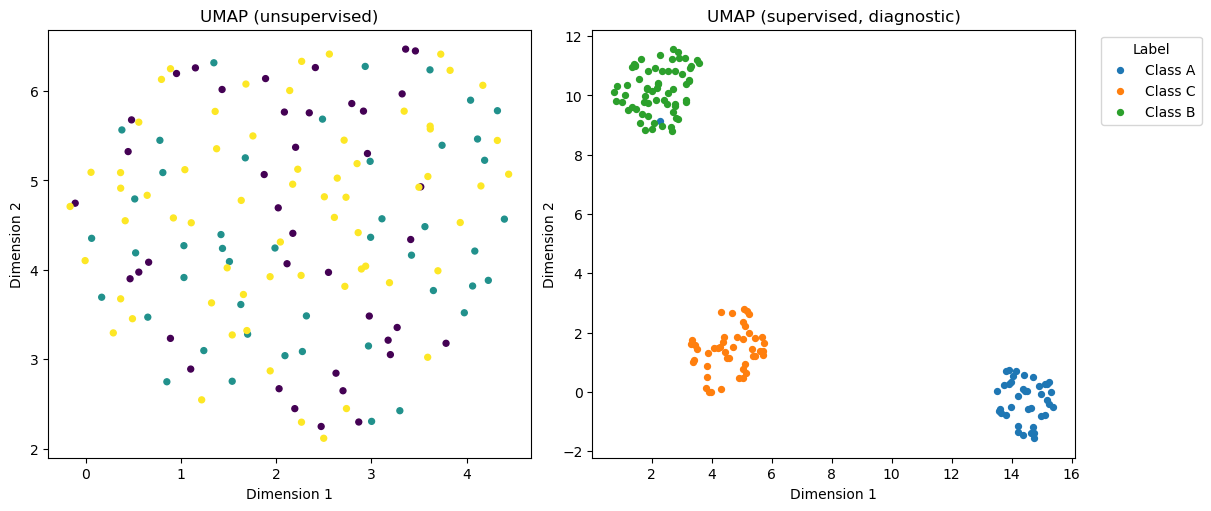

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from umap import UMAP

# --- Mock Data Generation (for a runnable example) ---
# Replace this with your actual Zs and labels data
N, T, D = 150, 10, 5 # 150 samples, 10 time steps, 5 features
Zs = np.random.rand(N, T, D)
# Create string labels like ['Class A', 'Class B', 'Class C', ...]
labels = np.array([f'Class {chr(65 + i)}' for i in np.random.randint(0, 3, N)])
# --- End of Mock Data ---


# 1. Preprocessing (Reshape, Scale, and Normalize)
# Your original preprocessing pipeline is kept as is.
X = Zs.reshape(N, T*D)
X_scaled = StandardScaler().fit_transform(X)
X_processed = normalize(X_scaled)


# 2. Unsupervised UMAP (No changes needed here)
umap_unsup = UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=0)
U_unsup = umap_unsup.fit_transform(X_processed)


# 3. Supervised UMAP
# --- FIX: Convert string labels to numeric codes ---
# pandas.factorize is perfect for this. It returns integer codes for the algorithm
# and the original category names for the plot legend.
labels_numeric, categories = pd.factorize(labels)

# Initialize the supervised UMAP model (your parameters are fine)
umap_sup = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",              # metric for the input data X
    target_metric="categorical",  # tells UMAP y contains discrete categories
    target_weight=0.5,            # how much to leverage the labels (0.0 to 1.0)
    random_state=0
)
# --- FIX: Pass the numeric labels to the 'y' parameter ---
U_sup = umap_sup.fit_transform(X_processed, y=labels_numeric)


# 4. Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot Unsupervised UMAP
axes[0].scatter(U_unsup[:, 0], U_unsup[:, 1], c=labels_numeric, cmap='viridis', s=18)
axes[0].set_title("UMAP (unsupervised)")
axes[0].set_xlabel("Dimension 1")
axes[0].set_ylabel("Dimension 2")


# Plot Supervised UMAP
# This loop now uses the integer codes and string categories for a clean legend
for i, category in enumerate(categories):
    # Select points belonging to the current category
    idx = (labels_numeric == i)
    axes[1].scatter(U_sup[idx, 0], U_sup[idx, 1], s=18, label=category)

axes[1].set_title("UMAP (supervised, diagnostic)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")
axes[1].legend(title="Label", bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

In [153]:
labels

array(['sip_home_grocery', 'sip_home_grocery', 'sip_hospital',
       'sip_home_grocery', 'evac_out_of_zone', 'sip_home_grocery',
       'evac_out_of_zone', 'evac_out_of_zone', 'evac_out_of_zone',
       'sip_home_grocery', 'sip_hospital', 'evac_out_of_zone',
       'sip_home_grocery', 'sip_home_grocery', 'evac_out_of_zone',
       'sip_home_grocery', 'sip_hospital', 'sip_hospital',
       'sip_home_grocery', 'evac_out_of_zone', 'evac_out_of_zone',
       'sip_home_grocery', 'sip_hospital', 'evac_out_of_zone',
       'sip_hospital', 'evac_out_of_zone', 'evac_out_of_zone',
       'evac_out_of_zone', 'sip_home_grocery', 'evac_out_of_zone',
       'sip_home_grocery', 'sip_hospital', 'sip_hospital',
       'evac_out_of_zone', 'evac_out_of_zone', 'sip_home_grocery',
       'evac_out_of_zone', 'sip_hospital', 'evac_out_of_zone',
       'sip_home_grocery', 'sip_hospital', 'evac_out_of_zone',
       'evac_out_of_zone', 'sip_hospital', 'sip_home_grocery',
       'evac_out_of_zone', 'sip_home_gr

In [159]:
labels_orig

['sip_home_grocery',
 'sip_hospital',
 'sip_hospital',
 'evac_out_of_zone',
 'sip_home_grocery',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'sip_home_grocery',
 'sip_hospital',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'sip_hospital',
 'evac_out_of_zone',
 'sip_hospital',
 'sip_hospital',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'sip_home_grocery',
 'sip_hospital',
 'evac_out_of_zone',
 'sip_home_grocery',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'sip_hospital',
 'sip_hospital',
 'sip_home_grocery',
 'sip_hospital',
 'sip_home_grocery',
 'sip_home_grocery',
 'evac_out_of_zone',
 'evac_out_of_zone',
 'sip_home_grocery',
 'evac_out_of_zone',
 'sip_hospital',
 'sip_home_grocery',
 'sip_hospital',
 'evac_out_of_zone',
 'sip_hospital',
 'sip_hospital',
 'sip_hospital',
 'sip_home_grocery',
 'sip_home_grocery',
 'sip_hospital',
 'sip_home_grocery',
 'evac_out_of_zone',
 'sip_hospital',
 'sip_home_grocery',
 'sip_home_grocery',
 'sip_hospital',
 

In [162]:
np.where(y_true_str== 'evac_out_of_zone')

/tmp/261825.tmpdir/ipykernel_453/2868829289.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(y_true_str== 'evac_out_of_zone')


(array([], dtype=int64),)

In [177]:
sip_indices.shape

(100,)

In [192]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# ----------- MOCK INPUTS (Replace with your actual data) -----------
# This section generates sample data so the script can run.
# Z: (N, T, D) latent tensor, labels: length-N array of strings
# We generate a larger dataset first to allow for balanced sampling.
N_orig, T, D = 150, 143, 64
Z_orig = Zs
# Create string labels that match your expected classes
label_options = list(set(y_true_str))
labels_orig = np.asarray(y_true_str)
# --------------------------------------------------------------------


# ----------- 1) Create a Balanced 50 vs 50 Sample Set -----------
RANDOM_STATE = 120
rng = np.random.default_rng(RANDOM_STATE)

# Identify the indices for each of the two super-classes (evac vs. sip)
evac_indices = np.where(labels_orig == 'evac_out_of_zone')[0]
sip_indices = np.where(np.isin(labels_orig, ['sip_home_grocery', 'sip_hospital']))[0]

# Randomly sample 50 indices from each class (ensure there are enough samples)
n_samples_per_class = 50
if len(evac_indices) < n_samples_per_class or len(sip_indices) < n_samples_per_class:
    raise ValueError("Not enough samples in the original data to create a balanced 50/50 split.")

selected_evac_indices = rng.choice(evac_indices, size=n_samples_per_class, replace=False)
selected_sip_indices = rng.choice(sip_indices, size=n_samples_per_class, replace=False)

# Combine the selected indices and shuffle them to mix the data
final_indices = np.concatenate([selected_evac_indices, selected_sip_indices])
rng.shuffle(final_indices)

# Create the final balanced dataset of 100 samples
Z = Z_orig[final_indices]
labels = labels_orig[final_indices]
N = Z.shape[0] # N is now 100


# ----------- 2) Create Binary Labels -----------
# The goal is to predict evacuation vs. sheltering-in-place (SIP).
# Positive class (1): 'evac_out_of_zone'
# Negative class (0): 'sip_home_grocery' or 'sip_hospital'
y = np.where(labels == "evac_out_of_zone", 1, 0).astype(int)


# ----------- 3) Prepare Features -----------
# We use the time-averaged latent vector as the feature for each trajectory.
X = Z.mean(axis=1)  # Shape becomes (N, D)


# ----------- 4) Create 70/20/10 Stratified Splits -----------
# First, split into 70% train and 30% temporary (for val + test)
sss_train_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=RANDOM_STATE)
train_idx, temp_idx = next(sss_train_temp.split(X, y))

X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]

# Next, split the 30% temporary set into validation (20%) and test (10%)
# The test_size is 1/3 because (1/3) * 30% = 10% for the final test set.
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=1/2, random_state=RANDOM_STATE + 1)
val_idx, test_idx = next(sss_val_test.split(X_temp, y_temp))

X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print("Data split sizes:")
print({
    "train": len(y_train), "val": len(y_val), "test": len(y_test),
    "pos_rate_train": y_train.mean().round(3),
    "pos_rate_val": y_val.mean().round(3),
    "pos_rate_test": y_test.mean().round(3)
})


# ----------- 5) Define Model Pipeline and Hyperparameter Grid -----------
# We create a pipeline to ensure the scaler is fit only on the training data.
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=100_000, random_state=RANDOM_STATE))
])

# Define the grid of hyperparameters to search over
grid = [
    {"clf__C": c, "clf__class_weight": cw}
    for c in [0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
    for cw in [None, "balanced"]
]


# ----------- 6) Tune Hyperparameters on Validation Set -----------
best_score, best_params = ((-1.0, -1.0), None)
print("\nTuning hyperparameters on validation set...")
for params in grid:
    model = Pipeline(pipe.steps).set_params(**params)
    model.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_val_pred = model.predict(X_val)
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)
    
    # Use ROC AUC as a tie-breaker if balanced accuracy is the same
    roc_auc = 0.0
    if hasattr(model.named_steps["clf"], "predict_proba"):
        y_val_proba = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_val_proba)
        
    score_tuple = (bal_acc, roc_auc)
    
    if score_tuple > best_score:
        best_score, best_params = score_tuple, params

print(f"Best VAL params: {best_params} | (Balanced Accuracy, ROC AUC) = {best_score}")


# ----------- 7) Evaluate Final Model on Held-Out Test Set -----------
# Retrain the best model on the combined training and validation data
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

final_model = Pipeline(pipe.steps).set_params(**best_params).fit(X_train_val, y_train_val)

# Predict on the unseen test set
y_test_pred = final_model.predict(X_test)

# Report final metrics
print("\n--- FINAL TEST METRICS (on held-out test set) ---")
observed_bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced accuracy: {observed_bacc:.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Macro F1-score: {f1_score(y_test, y_test_pred, average='macro'):.3f}")

if hasattr(final_model.named_steps["clf"], "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.3f}")

print("\nClassification report:\n", classification_report(y_test, y_test_pred, target_names=["SIP", "EVAC"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))


# ----------- 8) Permutation Test for Significance -----------
# This test checks if the model's balanced accuracy is statistically significant
# by comparing it to the accuracy achieved on randomly shuffled labels.
n_permutations = 1000
permutation_scores = []
rng_perm = np.random.default_rng(RANDOM_STATE)

print(f"\nRunning permutation test with {n_permutations} shuffles...")
for _ in range(n_permutations):
    # Shuffle the test labels randomly
    y_test_shuffled = rng_perm.permutation(y_test)
    # The score of a random classifier on balanced data is ~0.5. We check our model against this null.
    shuffled_score = balanced_accuracy_score(y_test, y_test_shuffled)
    permutation_scores.append(shuffled_score)

permutation_scores = np.array(permutation_scores)

# Calculate the p-value: the proportion of tsimes the shuffled score was
# greater than or equal to the observed score.
count_ge = np.sum(permutation_scores >= observed_bacc)
p_value = (count_ge + 1) / (n_permutations + 1)

print(f"\n--- PERMUTATION TEST RESULTS ---")
print(f"Observed Balanced Accuracy: {observed_bacc:.3f}")
print(f"Permutation p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result is statistically significant (p < 0.05).")
else:
    print("Result is not statistically significant (p >= 0.05).")



Data split sizes:
{'train': 65, 'val': 17, 'test': 18, 'pos_rate_train': 0.492, 'pos_rate_val': 0.529, 'pos_rate_test': 0.5}

Tuning hyperparameters on validation set...
Best VAL params: {'clf__C': 1.0, 'clf__class_weight': None} | (Balanced Accuracy, ROC AUC) = (0.5694444444444444, 0.4444444444444444)

--- FINAL TEST METRICS (on held-out test set) ---
Balanced accuracy: 0.667
Accuracy: 0.667
Macro F1-score: 0.662
ROC AUC: 0.593

Classification report:
               precision    recall  f1-score   support

         SIP       0.64      0.78      0.70         9
        EVAC       0.71      0.56      0.62         9

    accuracy                           0.67        18
   macro avg       0.68      0.67      0.66        18
weighted avg       0.68      0.67      0.66        18

Confusion matrix:
 [[7 2]
 [4 5]]

Running permutation test with 1000 shuffles...

--- PERMUTATION TEST RESULTS ---
Observed Balanced Accuracy: 0.667
Permutation p-value: 0.0240
Result is statistically significant (

In [194]:
!pip install xgboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 106.3 MB/s eta 0:00:00a 0:00:01


In [197]:
Zs_orig

array([[[-1.7500278 ,  1.4482962 , -0.7738107 , ..., -1.3476927 ,
          1.2176871 ,  0.22951618],
        [-1.4155121 ,  1.1535538 , -0.48787203, ..., -1.3558279 ,
          1.2848331 ,  0.20633727],
        [-1.3940811 ,  0.676312  , -0.23168443, ..., -1.3497276 ,
          1.4038624 ,  0.25399053],
        ...,
        [-1.2999871 ,  1.3342041 , -1.3988382 , ..., -0.4826874 ,
          1.156598  ,  1.1776992 ],
        [-1.6007106 ,  0.7999112 , -1.3653078 , ..., -0.49849087,
          1.3008947 ,  0.94950503],
        [-1.9757547 ,  0.68875045, -0.92935336, ..., -0.63402957,
          1.3137119 ,  0.6868674 ]],

       [[ 0.33419326,  1.1008228 , -1.9717185 , ...,  0.43571123,
          0.8843346 ,  0.90576196],
        [ 0.9682172 ,  0.65945697, -1.5776657 , ...,  0.588877  ,
          1.0731456 ,  1.0985441 ],
        [ 1.1107634 ,  0.00897359, -1.2836516 , ...,  0.7020817 ,
          1.2280278 ,  1.1630654 ],
        ...,
        [ 1.3874578 ,  1.0146983 , -2.4596844 , ...,  

In [207]:
Zs_orig

array([[[-1.7500278 ,  1.4482962 , -0.7738107 , ..., -1.3476927 ,
          1.2176871 ,  0.22951618],
        [-1.4155121 ,  1.1535538 , -0.48787203, ..., -1.3558279 ,
          1.2848331 ,  0.20633727],
        [-1.3940811 ,  0.676312  , -0.23168443, ..., -1.3497276 ,
          1.4038624 ,  0.25399053],
        ...,
        [-1.2999871 ,  1.3342041 , -1.3988382 , ..., -0.4826874 ,
          1.156598  ,  1.1776992 ],
        [-1.6007106 ,  0.7999112 , -1.3653078 , ..., -0.49849087,
          1.3008947 ,  0.94950503],
        [-1.9757547 ,  0.68875045, -0.92935336, ..., -0.63402957,
          1.3137119 ,  0.6868674 ]],

       [[ 0.33419326,  1.1008228 , -1.9717185 , ...,  0.43571123,
          0.8843346 ,  0.90576196],
        [ 0.9682172 ,  0.65945697, -1.5776657 , ...,  0.588877  ,
          1.0731456 ,  1.0985441 ],
        [ 1.1107634 ,  0.00897359, -1.2836516 , ...,  0.7020817 ,
          1.2280278 ,  1.1630654 ],
        ...,
        [ 1.3874578 ,  1.0146983 , -2.4596844 , ...,  

In [222]:
import numpy as np, pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix

# ---------- Inputs ----------
Zs_orig = Zs                               # (N_all, 143, 64)
labels_orig = np.asarray(y_true_str)       # length N_all, strings

# ---------- Config ----------
SEEDS = [48]           # add more if you like
N_PER_CLASS = 50                           # balanced 50/50/50 subset
TEST_SIZE = 0.20                           # 80/20 split
CV_FOLDS = 10
N_PERM = 5000                              # fast permutation null (test labels only)

param_grid = {
    "clf__C": [0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 10.0],
    "clf__class_weight": [None, "balanced"],
}

def sample_balanced_indices(labels, n_per, rng):
    idx1 = np.where(labels == 'evac_out_of_zone')[0]
    idx2 = np.where(labels == 'sip_home_grocery')[0]
    idx3 = np.where(labels == 'sip_hospital')[0]
    if not all(len(ix) >= n_per for ix in [idx1, idx2, idx3]):
        raise ValueError("Need at least 50 samples per class to form 50/50/50.")
    sel = np.concatenate([
        rng.choice(idx1, size=n_per, replace=False),
        rng.choice(idx2, size=n_per, replace=False),
        rng.choice(idx3, size=n_per, replace=False),
    ])
    rng.shuffle(sel)
    return sel

all_results = []
print(f"Running across {len(SEEDS)} seeds...")

for seed in tqdm(SEEDS):
    rng = np.random.default_rng(seed)

    # ---- Balanced subset (150 samples) ----
    sel = sample_balanced_indices(labels_orig, N_PER_CLASS, rng)
    Z = Zs_orig[sel]                      # (150, 143, 64)
    labels_str = labels_orig[sel]         # (150,)

    # Encode labels to ints 0..2, keep class_names for reporting
    y, class_names = pd.factorize(labels_str)

    # ---- Features: time-mean + time-std -> (150, 128) ----
    X_mean = Z.mean(axis=1)
    X_std  = Z.std(axis=1)
    X = np.concatenate([X_mean, X_std], axis=1)

    # ---- 80/20 split ----
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)
    (trv_idx, te_idx), = sss.split(X, y)
    X_trv, y_trv = X[trv_idx], y[trv_idx]
    X_te,  y_te  = X[te_idx],  y[te_idx]

    # ---- Pipeline + CV ----
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(solver="lbfgs", max_iter=100_000, random_state=seed))
    ])
    cv = StratifiedKFold(CV_FOLDS, shuffle=True, random_state=seed)
    search = GridSearchCV(pipe, param_grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True)
    search.fit(X_trv, y_trv)
    final_model = search.best_estimator_

    # ---- Test metrics ----
    y_pred = final_model.predict(X_te)
    bacc   = balanced_accuracy_score(y_te, y_pred)
    macroF = f1_score(y_te, y_pred, average="macro")
    cm     = confusion_matrix(y_te, y_pred)
    report = classification_report(y_te, y_pred, target_names=class_names, output_dict=False)

    # ---- Fast permutation p-value (shuffle test labels vs fixed predictions) ----
    rngp = np.random.default_rng(seed)
    perm_scores = []
    for _ in range(N_PERM):
        y_perm = rngp.permutation(y_te)
        perm_scores.append(balanced_accuracy_score(y_perm, y_pred))
    p_fast = (np.sum(np.array(perm_scores) >= bacc) + 1) / (N_PERM + 1)

    all_results.append({
        "seed": seed,
        "bacc": bacc,
        "macroF": macroF,
        "best_params": search.best_params_,
        "confusion_matrix": cm,
        "report_text": report,
        "class_names": class_names,
        "y_test": y_te,
        "y_pred": y_pred,
        "p_fast": p_fast,
        "n_test": len(y_te),
    })

# ---------- Summary ----------
df = pd.DataFrame([{
    "seed": r["seed"],
    "bacc": r["bacc"],
    "macroF": r["macroF"],
    "p_fast": r["p_fast"],
    "n_test": r["n_test"],
} for r in all_results]).sort_values("bacc", ascending=False)

print("\nPer-seed summary:\n", df.to_string(index=False))
print("\nBalanced accuracy mean ± sd:",
      f"{df['bacc'].mean():.3f} ± {df['bacc'].std(ddof=1):.3f}")
print("Macro-F1 mean ± sd:",
      f"{df['macroF'].mean():.3f} ± {df['macroF'].std(ddof=1):.3f}")

best = max(all_results, key=lambda r: r["bacc"])
print(f"\nBest seed: {best['seed']}  |  bacc={best['bacc']:.3f}  |  macroF={best['macroF']:.3f}  |  p_fast={best['p_fast']:.3f}")
print("\nClassification report (best seed):\n", best["report_text"])
print("\nConfusion matrix (best seed):\n", best["confusion_matrix"])
print("\nBest hyperparameters:", best["best_params"])


Running across 1 seeds...


  0%|          | 0/1 [00:00<?, ?it/s]


Per-seed summary:
  seed     bacc   macroF  p_fast  n_test
   48 0.633333 0.622952  0.0004      30

Balanced accuracy mean ± sd: 0.633 ± nan
Macro-F1 mean ± sd: 0.623 ± nan

Best seed: 48  |  bacc=0.633  |  macroF=0.623  |  p_fast=0.000

Classification report (best seed):
                   precision    recall  f1-score   support

sip_home_grocery       0.73      0.80      0.76        10
    sip_hospital       0.57      0.40      0.47        10
evac_out_of_zone       0.58      0.70      0.64        10

        accuracy                           0.63        30
       macro avg       0.63      0.63      0.62        30
    weighted avg       0.63      0.63      0.62        30


Confusion matrix (best seed):
 [[8 0 2]
 [3 4 3]
 [0 3 7]]

Best hyperparameters: {'clf__C': 1.0, 'clf__class_weight': None}


In [221]:
import numpy as np, pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix

# ---------- Inputs ----------
Zs_orig = Zs                               # (N_all, 143, 64)
labels_orig = np.asarray(y_true_str)       # length N_all, strings

# ---------- Config ----------
SEEDS = range(100)           # add more if you like
N_PER_CLASS = 50                           # balanced 50/50/50 subset
TEST_SIZE = 0.20                           # 80/20 split
CV_FOLDS = 10
N_PERM = 5000                              # fast permutation null (test labels only)

param_grid = {
    "clf__C": [0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 10.0],
    "clf__class_weight": [None, "balanced"],
}

def sample_balanced_indices(labels, n_per, rng):
    idx1 = np.where(labels == 'evac_out_of_zone')[0]
    idx2 = np.where(labels == 'sip_home_grocery')[0]
    idx3 = np.where(labels == 'sip_hospital')[0]
    if not all(len(ix) >= n_per for ix in [idx1, idx2, idx3]):
        raise ValueError("Need at least 50 samples per class to form 50/50/50.")
    sel = np.concatenate([
        rng.choice(idx1, size=n_per, replace=False),
        rng.choice(idx2, size=n_per, replace=False),
        rng.choice(idx3, size=n_per, replace=False),
    ])
    rng.shuffle(sel)
    return sel

all_results = []
print(f"Running across {len(SEEDS)} seeds...")

for seed in tqdm(SEEDS):
    rng = np.random.default_rng(seed)

    # ---- Balanced subset (150 samples) ----
    sel = sample_balanced_indices(labels_orig, N_PER_CLASS, rng)
    Z = Zs_orig[sel]                      # (150, 143, 64)
    labels_str = labels_orig[sel]         # (150,)

    # Encode labels to ints 0..2, keep class_names for reporting
    y, class_names = pd.factorize(labels_str)

    # ---- Features: time-mean + time-std -> (150, 128) ----
    X_mean = Z.mean(axis=1)
    X_std  = Z.std(axis=1)
    X = np.concatenate([X_mean, X_std], axis=1)

    # ---- 80/20 split ----
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)
    (trv_idx, te_idx), = sss.split(X, y)
    X_trv, y_trv = X[trv_idx], y[trv_idx]
    X_te,  y_te  = X[te_idx],  y[te_idx]

    # ---- Pipeline + CV ----
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(solver="lbfgs", max_iter=100_000, random_state=seed))
    ])
    cv = StratifiedKFold(CV_FOLDS, shuffle=True, random_state=seed)
    search = GridSearchCV(pipe, param_grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True)
    search.fit(X_trv, y_trv)
    final_model = search.best_estimator_

    # ---- Test metrics ----
    y_pred = final_model.predict(X_te)
    bacc   = balanced_accuracy_score(y_te, y_pred)
    macroF = f1_score(y_te, y_pred, average="macro")
    cm     = confusion_matrix(y_te, y_pred)
    report = classification_report(y_te, y_pred, target_names=class_names, output_dict=False)

    # ---- Fast permutation p-value (shuffle test labels vs fixed predictions) ----
    rngp = np.random.default_rng(seed)
    perm_scores = []
    for _ in range(N_PERM):
        y_perm = rngp.permutation(y_te)
        perm_scores.append(balanced_accuracy_score(y_perm, y_pred))
    p_fast = (np.sum(np.array(perm_scores) >= bacc) + 1) / (N_PERM + 1)

    all_results.append({
        "seed": seed,
        "bacc": bacc,
        "macroF": macroF,
        "best_params": search.best_params_,
        "confusion_matrix": cm,
        "report_text": report,
        "class_names": class_names,
        "y_test": y_te,
        "y_pred": y_pred,
        "p_fast": p_fast,
        "n_test": len(y_te),
    })

# ---------- Summary ----------
df = pd.DataFrame([{
    "seed": r["seed"],
    "bacc": r["bacc"],
    "macroF": r["macroF"],
    "p_fast": r["p_fast"],
    "n_test": r["n_test"],
} for r in all_results]).sort_values("bacc", ascending=False)

print("\nPer-seed summary:\n", df.to_string(index=False))
print("\nBalanced accuracy mean ± sd:",
      f"{df['bacc'].mean():.3f} ± {df['bacc'].std(ddof=1):.3f}")
print("Macro-F1 mean ± sd:",
      f"{df['macroF'].mean():.3f} ± {df['macroF'].std(ddof=1):.3f}")

best = max(all_results, key=lambda r: r["bacc"])
print(f"\nBest seed: {best['seed']}  |  bacc={best['bacc']:.3f}  |  macroF={best['macroF']:.3f}  |  p_fast={best['p_fast']:.3f}")
print("\nClassification report (best seed):\n", best["report_text"])
print("\nConfusion matrix (best seed):\n", best["confusion_matrix"])
print("\nBest hyperparameters:", best["best_params"])


Running across 100 seeds...


  0%|          | 0/100 [00:00<?, ?it/s]


Per-seed summary:
  seed     bacc   macroF   p_fast  n_test
   48 0.633333 0.622952 0.000400      30
   79 0.633333 0.637959 0.001200      30
   24 0.633333 0.627778 0.000800      30
   77 0.633333 0.627596 0.001000      30
   52 0.600000 0.592368 0.002599      30
   57 0.600000 0.597105 0.002599      30
   30 0.600000 0.590526 0.001600      30
   16 0.600000 0.592508 0.002799      30
   92 0.566667 0.580222 0.004399      30
   56 0.566667 0.550121 0.008798      30
   28 0.566667 0.569256 0.008198      30
    8 0.533333 0.518375 0.018596      30
   41 0.533333 0.534169 0.019796      30
    5 0.533333 0.530640 0.020996      30
   14 0.533333 0.523130 0.020196      30
   49 0.533333 0.518434 0.019396      30
   29 0.533333 0.518434 0.019996      30
   55 0.533333 0.528435 0.020196      30
   54 0.533333 0.529240 0.021596      30
   78 0.533333 0.535923 0.023995      30
   31 0.533333 0.534056 0.017596      30
   38 0.533333 0.530827 0.019796      30
   58 0.500000 0.500000 0.040992     

In [67]:
import numpy as np, pandas as pd
from math import sqrt
from scipy.stats import fisher_exact, chi2_contingency, binomtest

# Inputs already computed above:
# C            -> 2x2 confusion matrix with order [[TN, FP],[FN, TP]]
# y_true_bin   -> 0=SIP, 1=EVAC
# y_pred_bin   -> 0=SIP, 1=EVAC

tn, fp, fn, tp = C.ravel()
N = C.sum()
acc = (tp + tn) / N
sens = tp / (tp + fn) if (tp + fn) else np.nan  # EVAC recall
spec = tn / (tn + fp) if (tn + fp) else np.nan  # SIP recall
prev1 = (y_true_bin == 1).mean()
prev0 = 1 - prev1
maj_base = max(prev0, prev1)  # majority-class baseline accuracy

def wilson(successes, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # ~ N(0,1) 97.5% for 95% CI
    p = successes / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = (z * sqrt((p*(1-p) + z**2/(4*n)) / n)) / denom
    return center - half, center + half

acc_ci = wilson(tp + tn, N)
sens_ci = wilson(tp, tp + fn) if np.isfinite(sens) else (np.nan, np.nan)
spec_ci = wilson(tn, tn + fp) if np.isfinite(spec) else (np.nan, np.nan)

# 1) Fisher's exact test (association)
odds_ratio, p_fisher = fisher_exact([[tn, fp],[fn, tp]], alternative="two-sided")

# 2) Chi-square test of independence
chi2, p_chi, dof, expected = chi2_contingency([[tn, fp],[fn, tp]], correction=False)

# 3) Exact binomial tests on accuracy
p_binom_vs_majority = binomtest(k=int(tp+tn), n=int(N), p=float(maj_base), alternative="greater").pvalue
p_binom_vs_half     = binomtest(k=int(tp+tn), n=int(N), p=0.5,             alternative="greater").pvalue

# 4) McNemar's test (exact, two-sided) on disagreements b=FP, c=FN
b, c = fp, fn
if (b + c) > 0:
    # exact McNemar p-value via binomial
    k = min(b, c)
    from scipy.stats import binom
    p_mcnemar = 2 * binom.cdf(k, b + c, 0.5)
    p_mcnemar = min(1.0, p_mcnemar)
else:
    p_mcnemar = np.nan

# ---- Print a tidy summary ----
print("Counts:  TN={}, FP={}, FN={}, TP={}, N={}".format(tn, fp, fn, tp, N))
print(f"Accuracy = {acc:.3f}  (95% CI {acc_ci[0]:.3f}–{acc_ci[1]:.3f})")
print(f"Sensitivity (EVAC recall) = {sens:.3f}  (95% CI {sens_ci[0]:.3f}–{sens_ci[1]:.3f})")
print(f"Specificity (SIP recall)  = {spec:.3f}  (95% CI {spec_ci[0]:.3f}–{spec_ci[1]:.3f})\n")

print(f"Fisher’s exact:  odds ratio={odds_ratio:.3g},  p={p_fisher:.4g}")
print(f"Chi-square(1):   chi2={chi2:.3f},  p={p_chi:.4g}")
print(f"Binomial test (acc > majority={maj_base:.3f}):  p={p_binom_vs_majority:.4g}")
print(f"Binomial test (acc > 0.5):                     p={p_binom_vs_half:.4g}")
print(f"McNemar’s exact (FP vs FN symmetry):           p={p_mcnemar:.4g}")

# Optional: a small DataFrame of the p-values
pv = pd.DataFrame({
    "test": ["Fisher exact", "Chi-square", "Binomial vs majority", "Binomial vs 0.5", "McNemar exact"],
    "p_value": [p_fisher, p_chi, p_binom_vs_majority, p_binom_vs_half, p_mcnemar]
})
display(pv)


Counts:  TN=72, FP=28, FN=27, TP=23, N=150
Accuracy = 0.633  (95% CI 0.554–0.706)
Sensitivity (EVAC recall) = 0.460  (95% CI 0.330–0.596)
Specificity (SIP recall)  = 0.720  (95% CI 0.625–0.799)

Fisher’s exact:  odds ratio=2.19,  p=0.04358
Chi-square(1):   chi2=4.813,  p=0.02825
Binomial test (acc > majority=0.667):  p=0.8299
Binomial test (acc > 0.5):                     p=0.000685
McNemar’s exact (FP vs FN symmetry):           p=1


,test,p_value
0,Fisher exact,0.043578
1,Chi-square,0.028249
2,Binomial vs majority,0.829855
3,Binomial vs 0.5,0.000685
4,McNemar exact,1.000000


In [70]:
# ========= BEST MODEL SELECTION ON BINARY (EVAC vs SIP) — Standard KMeans =========
import numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, classification_report, balanced_accuracy_score,
    matthews_corrcoef, silhouette_score
)
from scipy.optimize import linear_sum_assignment
from scipy.stats import fisher_exact, chi2_contingency, binom, binomtest

# ---------- Inputs expected ----------
#   y_true_str : GT strings for all rows (e.g., 'sip_home_grocery','evac_out_of_zone',...)
#   Zs         : standardized features for all rows  (shape [N, d]); if you only have Z, do Zs = StandardScaler().fit_transform(Z)
#   ids        : trajectory IDs aligned with rows
#
# If you already filtered to 3 classes earlier (y3, Zs3, ids3), set USE_SUBSET=True.
USE_SUBSET  = True   # set False if you want to keep all classes
N_CLASSES   = 3      # 3 if you dropped 'evac_short_in_zone'; else 4
KEEP_NAMES  = ["evac_out_of_zone", "sip_home_grocery", "sip_hospital"] if N_CLASSES==3 else None

# ---------- Prep subset if requested ----------
if USE_SUBSET:
    keep = pd.Series(y_true_str).isin(KEEP_NAMES).to_numpy()
    gt_names = pd.Series(y_true_str)[keep].astype(str).reset_index(drop=True)
    X = np.asarray(Zs)[keep]
    ids_used = pd.Series(ids)[keep].reset_index(drop=True)
else:
    gt_names = pd.Series(y_true_str).astype(str).reset_index(drop=True)
    X = np.asarray(Zs)
    ids_used = pd.Series(ids).reset_index(drop=True)

N = len(gt_names)
assert X.shape[0] == N, "Feature rows must match y_true"

# Binary collapse helper (EVAC=1, SIP=0)
to_bin = lambda s: 1 if str(s).lower().startswith("evac") else 0
y_true_bin = gt_names.map(to_bin).to_numpy()

# ---------- Sweep seeds and pick best by binary objective ----------
best_tuple   = None   # lexicographic: (MCC, bal_acc, acc, -p_binom_vs_majority, sil)
best_model   = None
best_df      = None
best_mapping = None
best_cm_bin  = None
best_stats   = None

for seed in tqdm(range(5000), desc=f"K={N_CLASSES} KMeans sweeps (binary selection)"):
    # 1) fit standard KMeans (no size constraints)
    kmeans = KMeans(
        n_clusters=N_CLASSES,
        n_init=20,
        max_iter=300,
        init="k-means++",
        random_state=seed,
        tol=1e-4,
    )
    labels = kmeans.fit_predict(X)

    # 2) Hungarian map: clusters -> class names (label-safe on crosstab)
    cm_full = pd.crosstab(gt_names, pd.Series(labels, name="pred"), dropna=False)
    true_names = cm_full.index.tolist()
    pred_ids   = cm_full.columns.tolist()
    C = cm_full.to_numpy()

    # pad to square for Hungarian
    nT, nP = C.shape
    if nT > nP:
        Cpad = np.pad(C, ((0,0),(0,nT-nP)), 'constant')
    elif nP > nT:
        Cpad = np.pad(C, ((0,nP-nT),(0,0)), 'constant')
    else:
        Cpad = C

    r_idx, c_idx = linear_sum_assignment(-Cpad)  # maximize matches
    mapping = {}
    for r, c in zip(r_idx, c_idx):
        if r < nT and c < nP:
            mapping[pred_ids[c]] = true_names[r]

    # 3) Map predictions to names, then to binary
    y_pred_names = pd.Series(labels).map(mapping).fillna("sip_unknown")
    y_pred_bin = y_pred_names.map(to_bin).to_numpy()

    # 4) Binary confusion & metrics
    C2 = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    tn, fp, fn, tp = C2.ravel()
    N2 = C2.sum()
    acc = (tp + tn) / N2
    bal_acc = balanced_accuracy_score(y_true_bin, y_pred_bin)
    mcc = matthews_corrcoef(y_true_bin, y_pred_bin)

    # p-values
    try:
        _, p_fisher = fisher_exact([[tn, fp],[fn, tp]], alternative="two-sided")
    except Exception:
        p_fisher = np.nan
    try:
        _, p_chi, _, _ = chi2_contingency([[tn, fp],[fn, tp]], correction=False)
    except Exception:
        p_chi = np.nan

    # Binomial test vs majority baseline
    prev1 = (y_true_bin == 1).mean()
    prev0 = 1 - prev1
    maj_base = float(max(prev0, prev1))
    p_binom_vs_maj = binomtest(k=int(tp+tn), n=int(N2), p=maj_base, alternative="greater").pvalue

    # McNemar exact
    b, c = fp, fn
    if (b + c) > 0:
        p_mcnemar = 2 * binom.cdf(min(b, c), b + c, 0.5)
        p_mcnemar = float(min(1.0, p_mcnemar))
    else:
        p_mcnemar = np.nan

    # silhouette (guard against degenerate splits)
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = float("nan")

    # objective tuple (maximize first elements, minimize p-value via negative)
    score_tuple = (float(mcc), float(bal_acc), float(acc), -float(p_binom_vs_maj), float(sil))

    if (best_tuple is None) or (score_tuple > best_tuple):
        best_tuple   = score_tuple
        best_model   = kmeans
        best_df      = pd.DataFrame({"traj_id": ids_used, "cluster": labels, "pred_name": y_pred_names})
        best_mapping = mapping.copy()
        best_cm_bin  = pd.DataFrame(C2, index=["true:SIP(0)","true:EVAC(1)"], columns=["pred:SIP(0)","pred:EVAC(1)"])
        best_stats = {
            "acc": acc, "balanced_acc": bal_acc, "mcc": mcc,
            "p_fisher": p_fisher, "p_chi": p_chi,
            "p_binom_vs_majority": p_binom_vs_maj,
            "p_mcnemar": p_mcnemar,
            "silhouette": sil,
            "objective_tuple": score_tuple,
            "seed": seed,
        }
        print(f"new BEST — MCC={mcc:.3f}, bal_acc={bal_acc:.3f}, acc={acc:.3f}, p(bin>maj)={p_binom_vs_maj:.2e}, sil={sil:.3f}, seed={seed}")

# ---------- Summary ----------
print("\n=== BEST MODEL (binary selection, standard KMeans) ===")
print("Cluster → class mapping:", best_mapping)
display(best_cm_bin)
print("Metrics:", {k: (round(v,3) if isinstance(v, (int,float)) and np.isfinite(v) else v) for k,v in best_stats.items()})
# best_model     -> the fitted KMeans instance
# best_df        -> DataFrame with traj_id, cluster, and mapped class name for the kept rows
# best_mapping   -> dict {cluster_id: class_name}


K=3 KMeans sweeps (binary selection):   0%|                                                                                                                           | 3/5000 [00:00<03:22, 24.72it/s]

new BEST — MCC=0.063, bal_acc=0.530, acc=0.600, p(bin>maj)=9.64e-01, sil=0.102, seed=0
new BEST — MCC=0.132, bal_acc=0.565, acc=0.620, p(bin>maj)=9.02e-01, sil=0.101, seed=1
new BEST — MCC=0.156, bal_acc=0.580, acc=0.613, p(bin>maj)=9.28e-01, sil=0.099, seed=3


K=3 KMeans sweeps (binary selection):   1%|▉                                                                                                                         | 36/5000 [00:01<04:28, 18.48it/s]

new BEST — MCC=0.168, bal_acc=0.585, acc=0.627, p(bin>maj)=8.69e-01, sil=0.104, seed=31


K=3 KMeans sweeps (binary selection):   1%|█                                                                                                                         | 43/5000 [00:02<03:33, 23.23it/s]

new BEST — MCC=0.208, bal_acc=0.600, acc=0.660, p(bin>maj)=6.06e-01, sil=0.099, seed=37


K=3 KMeans sweeps (binary selection):   6%|███████                                                                                                                  | 290/5000 [00:11<02:44, 28.65it/s]

new BEST — MCC=0.228, bal_acc=0.610, acc=0.667, p(bin>maj)=5.38e-01, sil=0.100, seed=286


K=3 KMeans sweeps (binary selection):  52%|██████████████████████████████████████████████████████████████▍                                                         | 2602/5000 [01:37<01:23, 28.83it/s]

new BEST — MCC=0.228, bal_acc=0.610, acc=0.667, p(bin>maj)=5.38e-01, sil=0.100, seed=2596


K=3 KMeans sweeps (binary selection): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:05<00:00, 26.92it/s]


=== BEST MODEL (binary selection, standard KMeans) ===
Cluster → class mapping: {1: 'evac_out_of_zone', 0: 'sip_home_grocery', 2: 'sip_hospital'}


,pred:SIP(0),pred:EVAC(1)
true:SIP(0),78,22
true:EVAC(1),28,22


Metrics: {'acc': 0.667, 'balanced_acc': 0.61, 'mcc': 0.228, 'p_fisher': 0.008, 'p_chi': 0.005, 'p_binom_vs_majority': 0.538, 'p_mcnemar': 0.48, 'silhouette': 0.1, 'objective_tuple': (0.2277867258047101, 0.61, 0.6666666666666666, -0.5382910153188247, 0.09997283667325974), 'seed': 2596}


In [ ]:
ses_distribution = cluster_df.merge(
    clean_joined,            # the table with your new columns
    on="traj_id",          # column to join on
    how="right",          # keep all rows in clean_joined
    #validate="1:1"       # optional: check that df_final.GEOID is unique
)

In [ ]:
# find the index of the min pt_idx for each traj_id
idx = ses_distribution.groupby("traj_id")["pt_idx"].idxmin()

# select only those rows
ses_first_pts = ses_distribution.loc[idx].reset_index(drop=True)


In [ ]:
grp = ses_distribution.groupby("traj_id")

# mean income
mean_inc = grp["med_income"].mean()

# mode income (most‐frequent); take the first mode if there’s a tie
mode_inc = grp["med_income"] \
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])

# cluster label (each traj has a single cluster)
cluster_lbl = grp["cluster"].first()

# assemble
df_traj = pd.DataFrame({
    "cluster": cluster_lbl,
    "mean_income": mean_inc,
    "mode_income": mode_inc
}).reset_index()

In [ ]:
plt.figure(figsize=(8, 4))
for cl in sorted(df_traj["cluster"].unique()):
    vals = df_traj.loc[df_traj["cluster"] == cl, "mean_income"]
    plt.hist(vals, bins=100, density=True, alpha=0.5, label=f"Cluster {cl}")

plt.xlabel("Average Median Income per Trajectory")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Income by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 4))
for cl in sorted(df_traj["cluster"].unique()):
    vals = df_traj.loc[df_traj["cluster"] == cl, "mode_income"]
    plt.hist(vals, bins=100, density=True, alpha=0.5, label=f"Cluster {cl}")

plt.xlabel("Modal Median Income per Trajectory")
plt.ylabel("Frequency")
plt.title("Distribution of Mode Income by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming df_traj exists with columns 'cluster', 'mean_income', 'mode_income'
clusters = sorted(df_traj['cluster'].unique())

# 1. KDE plot for mean_income
x_mean = df_traj['mean_income']
x_min, x_max = x_mean.min(), x_mean.max()
x_grid = np.linspace(x_min, x_max, 200)

plt.figure(figsize=(8, 5))
for cl in clusters:
    data = df_traj.loc[df_traj['cluster'] == cl, 'mean_income']
    kde = gaussian_kde(data)
    plt.plot(x_grid, kde(x_grid), label=f'Cluster {cl}')

plt.xlabel('Average Median Income per Trajectory')
plt.ylabel('Density')
plt.title('KDE of Mean Income by Cluster')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 2. KDE plot for mode_income
x_mode = df_traj['mode_income']
x_min, x_max = x_mode.min(), x_mode.max()
x_grid = np.linspace(x_min, x_max, 200)

plt.figure(figsize=(8, 5))
for cl in clusters:
    data = df_traj.loc[df_traj['cluster'] == cl, 'mode_income']
    kde = gaussian_kde(data)
    plt.plot(x_grid, kde(x_grid), label=f'Cluster {cl}')

plt.xlabel('Modal Median Income per Trajectory')
plt.ylabel('Density')
plt.title('KDE of Mode Income by Cluster')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [ ]:
ses_first_pts

In [ ]:
ses_distribution

In [ ]:
ses_first_pts['cluster'].unique()

In [ ]:
import matplotlib.pyplot as plt

# Assuming your GeoDataFrame with first points is named `ses_first_pts`
# and contains columns 'cluster' and 'med_income'.
colors = ["green","blue","yellow","red","purple","orange"]
plt.figure(figsize=(8, 5))
for cl in sorted(ses_first_pts['cluster'].unique()):
    plt.hist(
        ses_first_pts.loc[ses_first_pts['cluster'] == cl, 'med_income'],
        bins=90,
        alpha=0.9,
        density = True,
        label=f'Cluster {cl}',
        color=colors[cl]
    )

plt.xlabel('Median Household Income')
plt.ylabel('Count')
plt.title('Distribution of Median Income by Cluster')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
from shapely import LineString
import random
centroids_aea = gpd.GeoSeries(
    clean_joined['centroid'].values,
)

# 2) Reproject that GeoSeries to EPSG:4326
centroids_wgs = centroids_aea.to_crs(epsg=4326)

# 3) Overwrite the old column (or make a new one)
clean_joined['centroid'] = centroids_wgs.values

centroids_aea = gpd.GeoSeries(
    ses_gdf['centroid'].values,
)

# 2) Reproject that GeoSeries to EPSG:4326
centroids_wgs = centroids_aea.to_crs(epsg=4326)


ses_gdf['centroid'] = centroids_wgs.values
# 4) If you also want your polygons in 4326, do that too:
clean_joined = clean_joined.to_crs(epsg=4326)
# ─── 2) Randomly sample N trajectories ───────────────────────────────────────
N = 50
all_ids    = clean_joined['traj_id'].unique().tolist()
sample_ids = random.sample(all_ids, k=N)

# ─── 3) Build the sample_gdf ──────────────────────────────────────────────────
sample_lines = []
for tid in sample_ids:
    sub = (
        clean_joined[ clean_joined['traj_id'] == tid ]
          .sort_values('pt_idx')
    )
    pts = [
        ses_gdf.at[int(h), 'centroid']
        for h in sub['index_right'].dropna().astype(int)
    ]
    if len(pts) > 1:
        sample_lines.append({
            'traj_id': tid,
            'geometry': LineString(pts)
        })

In [ ]:
labels

In [ ]:
ses_gdf

In [ ]:
from tqdm.auto import tqdm
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
states = gpd.read_file('cb_2018_us_state_500k.shp')
df = clean_joined.copy()

# ── 0) Utility to pick top‐m trajectories per cluster by proximity in Z-space
def find_representative_trajectories(Z, labels, traj_ids, centers, m=50):
    reps = {}
    K = centers.shape[0]

    for c in tqdm(range(K)):
        idx_c = np.where(labels == c)[0]          # positions in Z for cluster c
        Zc    = Z[idx_c]
        dists = np.linalg.norm(Zc - centers[c], axis=1)
        order = np.argsort(dists)[: min(m, len(dists))]

        # use .iloc to get by *position*
        reps[c] = traj_ids.iloc[idx_c[order]].tolist()

    return reps
m = 100
# ── 1) Compute representatives (50 per cluster)
#    MAKE SURE Z, labels, ds.ids, and kmeans.cluster_centers_ are in scope
representatives = find_representative_trajectories(
    Z, labels, clean_joined.traj_id, kmeans.cluster_centers_, m
)

# ── 2) Merge cluster labels into your point‐level table
joined = df.merge(cluster_df, on="traj_id", how="left")

# ── 3) Build LineStrings for the representative traj_ids
traj_lines = []
for cl, tid_list in tqdm(representatives.items()):
    for tid in tqdm(tid_list):
        sub = joined[joined["traj_id"] == tid].sort_values("pt_idx")
        pts = [
            ses_gdf.at[int(h), "centroid"]
            for h in sub["index_right"].dropna().astype(int)
        ]
        if len(pts) >= 2:
            traj_lines.append({
                "traj_id": tid,
                "cluster": cl,
                "geometry": LineString(pts)
            })

traj_lines_gdf = gpd.GeoDataFrame(
    traj_lines,
    geometry="geometry",
    crs=ses_gdf.crs
)

# ── 4) Prepare output folder


In [ ]:
clean_joined['vec_weighted_avg'] = clean_joined['vec_weighted_avg'].apply(fill_vec)
cj = (
    clean_joined
      .merge(
         traj_lines_gdf[['traj_id','cluster']],
         on='traj_id',
         how='left'
  )
)
cj
# 2) Now pick your cluster i and time‐step t
cluster_i = 2
time_t    = 143

sub = cj[
    (cj['cluster'] == cluster_i) &
    (cj['pt_idx']   == time_t)
]

vectors_by_t = {}
for t in sorted(cj['pt_idx'].unique()):
    part = cj[(cj['cluster']==cluster_i)&(cj['pt_idx']==t)]
    vectors_by_t[t] = (
        np.vstack(part['vec_weighted_avg'].tolist())
        if not part.empty
        else np.zeros((0, emb_dim))
    )

In [ ]:
import torch
import numpy as np
import pandas as pd

# ─── CONFIGURATION ─────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k      = 10       # number of logits to sum
T      = 2.0      # temperature (unused if =1)
K      = 3        # number of clusters

# outputs
df_counts_by_cluster     = {}
df_counts_cat_by_cluster = {}

# ─── MAIN LOOP ─────────────────────────────────────────────────────────────
for cluster_i in range(K):
    # 1) select all POIs in this cluster
    cluster_data = cj[cj['cluster'] == cluster_i]
    counts_by_t  = {}

    # 2) no grads needed
    with torch.no_grad():
        # 3) loop over each distinct time‐step
        for t in sorted(cluster_data['pt_idx'].unique()):
            sub = cluster_data[cluster_data['pt_idx'] == t]
            if sub.empty:
                counts_by_t[t] = {}   # empty hour
                continue

            # 4) stack embeddings and push to device
            arr = np.stack(sub['vec_weighted_avg'].values).astype(np.float32)  # (n_traj, D)
            X   = torch.from_numpy(arr).to(device)

            # 5) run only the head to get logits
            logits = bottleneck_model.head(X)  # (n_traj, n_classes)
            if t%100 == 0:
                print(logits.shape)
            probs = torch.softmax(logits,axis=1)

            # 6) pick the top-k logits per POI
            topk_vals, topk_idx = probs.topk(k, dim=1)  # both are (n_traj, k)
            topk_vals = topk_vals.cpu().numpy()
            topk_idx  = topk_idx.cpu().numpy()

            # 7) sum those logits into a per-class accumulator
            agg = {}
            for idx_row, val_row in zip(topk_idx, topk_vals):
                for cls, score in zip(idx_row, val_row):
                    agg[cls] = agg.get(cls, 0.0) + float(score)

            counts_by_t[t] = agg

    # ─── Build DataFrame of raw sums ────────────────────────────────
    df_counts = (
        pd.DataFrame.from_dict(counts_by_t, orient='index')
          .fillna(0.0)
    )
    df_counts.index.name = 'pt_idx'

    # rename numeric class‐indices → the string labels
    df_counts.columns = [classes[int(c)] for c in df_counts.columns]

    # ─── Collapse subcategories to top‐level categories ─────────────
    col2cat = df_counts.columns.map(lambda s: s.split('[sep]')[0])
    df_counts_cat = df_counts.groupby(col2cat, axis=1).sum()

    # ─── Store for later use ─────────────────────────────────────────
    df_counts_by_cluster[cluster_i]     = df_counts
    df_counts_cat_by_cluster[cluster_i] = df_counts_cat

# ─── Now df_counts_by_cluster[i] is the raw summed-logit table for cluster i
#     and df_counts_cat_by_cluster[i] is the same collapsed to categories.


In [ ]:
from functools import reduce
global_counts = reduce(
    lambda a, b: a.add(b, fill_value=0),
    df_counts_cat_by_cluster.values()
)

# 2. (Optional) fill any NaNs just in case
global_counts = global_counts.fillna(0)

# 3. If you want the baseline **proportions** (summing across categories at each time step):
global_df = global_counts.div(global_counts.sum(axis=1).replace(0, 1), axis=0)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, ListedColormap
from functools import reduce

# --- Prepare colormap & cluster list ---
base_cmap     = plt.cm.get_cmap('bwr', 256)
base_colors   = base_cmap(np.linspace(0, 1, 256))
base_colors[len(base_colors)//2] = [1,1,1,1]          # white at zero
cmap_white_center = ListedColormap(base_colors)

clusters      = sorted(df_counts_cat_by_cluster.keys())  # e.g. [0,1,2]

# pick the same top-categories for all
df0     = df_counts_cat_by_cluster[clusters[0]]
top6    = df0.sum(axis=0).nlargest(6).index.tolist()
_, top5 = top6[0], top6[1:]  # drop the first if desired

# --- Make a 3×1 grid, figsize 10×9 ---
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(8, 5),
    sharex=True,       # align time axis
    sharey=False,      # each subplot draws its own y‐labels
    constrained_layout=True
)

all_im = None
for ax, cluster_i in zip(axes, clusters):
    # compute Δ% for this cluster
    df_cat      = df_counts_cat_by_cluster[cluster_i][top5].sort_index()
    df_norm     = df_cat.div(df_cat.sum(axis=1).replace(0,1), axis=0)
    glob_sel    = global_df[top5]
    global_norm = glob_sel.div(glob_sel.sum(axis=1).replace(0,1), axis=0)

    df_diff = (df_norm - global_norm) * 100
    mx      = np.abs(df_diff.values).max()
    norm    = TwoSlopeNorm(vmin=-mx, vcenter=0, vmax=mx)

    im = ax.imshow(
        df_diff.T.values,
        cmap=cmap_white_center,
        norm=norm,
        aspect='auto',
        interpolation='nearest'
    )
    all_im = im

    # **always** draw y‐labels
    ax.set_yticks(np.arange(len(top5)))
    ax.set_yticklabels(top5, fontsize=6,)

    # x‐axis ticks only on bottom subplot
    ax.set_xticks(np.arange(len(df_diff.index))[::10])
    ax.set_xticklabels(df_diff.index[::10], rotation=45, ha="right", fontsize=8)
    ax.grid(False)
    ax.set_title(f"Cluster {cluster_i}", fontsize=12)

# common x‐label
axes[-1].set_xlabel("Time Step", fontsize=10)

# shared colorbar on the right
cbar = fig.colorbar(
    all_im,
    ax=axes,
    orientation='vertical',
    fraction=0.02,
    pad=0.03
)
cbar.set_label("Δ% (Cluster — Global)", fontsize=10)

plt.savefig("./cluster_results/SES_combined_heatmaps_3x1_with_ylab.png", dpi=200)
plt.close(fig)


In [ ]:
import numpy as np
from tqdm.auto import tqdm

def find_representative_trajectories_as_arrays(Z, labels, centers, m=750):
    """
    Finds the top 'm' representative trajectories from each cluster and returns
    their embeddings and labels as NumPy arrays.

    Args:
        Z (np.ndarray): The full array of latent embeddings.
        labels (np.ndarray): The cluster assignment for each embedding in Z.
        centers (np.ndarray): The cluster centroid vectors from KMeans.
        m (int): The number of representative trajectories to select from each cluster.

    Returns:
        tuple: A tuple containing (Z_representatives, labels_representatives)
               - Z_representatives: A NumPy array of the stacked representative embeddings.
               - labels_representatives: A NumPy array of the corresponding cluster labels.
    """
    representative_vectors_list = []
    representative_labels_list = []
    
    K = centers.shape[0] # Total number of clusters

    for c in tqdm(range(K), desc="Finding Representatives per Cluster"):
        # Find the original indices of all members belonging to the current cluster 'c'
        original_indices_for_cluster_c = np.where(labels == c)[0]
        
        # If the cluster is empty, skip it
        if len(original_indices_for_cluster_c) == 0:
            continue
            
        # Get the latent vectors for this cluster
        Zc = Z[original_indices_for_cluster_c]
        
        # Calculate the Euclidean distance of each member to the cluster's centroid
        dists = np.linalg.norm(Zc - centers[c], axis=1)
        
        # Get the indices of the 'm' closest members *within this cluster*
        num_to_select = min(m, len(dists))
        closest_indices_within_cluster = np.argsort(dists)[:num_to_select]
        
        # Use these local indices to find the original indices in the global Z array
        original_indices_of_reps = original_indices_for_cluster_c[closest_indices_within_cluster]
        
        # Select the representative vectors from the original Z array
        representative_vectors = Z[original_indices_of_reps]
        
        # Create the corresponding labels for these representatives
        representative_labels = np.full(num_to_select, c)
        
        # Append the results to our lists
        representative_vectors_list.append(representative_vectors)
        representative_labels_list.append(representative_labels)
        
    # Concatenate all the collected vectors and labels into single NumPy arrays
    if not representative_vectors_list:
        # Handle case where no representatives were found (e.g., all clusters were empty)
        return np.array([]), np.array([])

    Z_representatives = np.vstack(representative_vectors_list)
    labels_representatives = np.concatenate(representative_labels_list)
    
    return Z_representatives, labels_representatives

# --- How to use the new function ---

# Assume Z, labels, and kmeans.cluster_centers_ are already defined from your clustering
# Z = Full embedding matrix
# labels = Full labels array from KMeans
# kmeans = your fitted KMeans model object

m = 500
print(f"Selecting top {m} representative trajectories from each cluster...")

# Call the new function to get the data in the desired format
Z_reps, labels_reps = find_representative_trajectories_as_arrays(
    Z, 
    labels, 
    kmeans.cluster_centers_, 
    m=m
)

# --- Verification ---
print("\n--- Conversion Complete ---")
print(f"Shape of Z_reps (representative embeddings): {Z_reps.shape}")
print(f"Shape of labels_reps (representative labels): {labels_reps.shape}")

In [ ]:
##### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans # For generating sample data
from sklearn.datasets import make_blobs # For generating sample data

# --- For Demonstration: Create Sample Data ---
# In your actual code, you will use your real 'Z' and 'labels' from KMeans.
# Z = a NumPy array of your latent embeddings, shape (n_samples, n_features)
# labels = the result of km.labels_, shape (n_samples,)
print("Generating sample data for demonstration...")

print("Sample data generated.")
# Replace Z_sample and labels_sample with your actual data below
# --- End of Sample Data Generation ---


# 1. Run t-SNE to reduce dimensions
# Perplexity is a key hyperparameter; typical values are between 5 and 50.
# It's related to the number of nearest neighbors considered for each point.
print("Running t-SNE... (this may take a moment)")
tsne = TSNE(
    n_components=2,
    perplexity=20,
    n_iter=5000,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
tsne_results = tsne.fit_transform(Z_reps)
print("t-SNE finished.")

# 2. Create a DataFrame for easy plotting with Seaborn
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'cluster': labels_reps # Add the cluster labels from your KMeans result
})
# Make cluster labels categorical for better legend labels
tsne_df['cluster'] = tsne_df['cluster'].astype('category')

# 3. Plot the results using Seaborn
print("Generating plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(
    data=tsne_df,
    x='tsne_1',
    y='tsne_2',
    hue='cluster', # Color points by their assigned cluster
    palette=sns.color_palette("deep", n_colors=4), # Use a distinct color palette
    s=50,          # Marker size
    alpha=0.6,     # Marker transparency
    ax=ax
)

# Customize the plot for clarity
#ax.set_title('t-SNE Visualization of Trajectory Clusters', fontsize=20, pad=15)
ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
ax.legend(title='Cluster', fontsize=12, title_fontsize=14)
ax.grid(False)

plt.tight_layout()

# Save the figure in high resolution
output_filename = "tsne_cluster_visualization_3_flat.png"
plt.savefig(output_filename, dpi=300)
print(f"Plot saved successfully to {output_filename}")

plt.show()

In [ ]:
model.eval()
zs = []
with torch.no_grad():
    for x, mask, _ in tqdm(train_loader):
        # x: (B, T, F); mask: (B, T) with 1=data, 0=noise
        x = x.cuda()
        mask = mask.cuda()
        B, T, _ = x.shape

        # no need to clamp lengths—mask tells us directly
        Lmax = int(mask.sum(dim=1).max().item())  # longest real seq in this batch

        # get latent dim D by a quick forward on just t=0
        _, z0 = model(x[:, :1, :], torch.ones(B, dtype=torch.long).cuda())
        D = z0.shape[1]

        Z_batch = torch.zeros(B, D, T, device="cpu")

        for t in tqdm(range(Lmax)):
            # which trajectories are alive at time t?
            active = (mask[:, t] == 1).nonzero(as_tuple=True)[0]
            if len(active) == 0:
                break

            # mask-out future steps for just the active ones
            x_sub = x[active].clone()
            if t+1 < T:
                x_sub[:, t+1:, :] = 0

            # compute true lengths up to t for pack_padded_sequence
            lengths_sub = mask[active, : t+1].sum(dim=1)

            # forward only that subset
            _, z_sub = model(x_sub, lengths_sub)
            Z_batch[active.cpu(), :, t] = z_sub.cpu()

        zs.append(Z_batch)

# stitch batches → (num_traj, D, T)
Z3 = torch.cat(zs, dim=0).numpy()
print("Z3 shape:", Z3.shape)


In [ ]:
merged.to_csv("GEOID_data.csv")

In [ ]:
import pandas as pd
import numpy as np
import shapely.wkb
import geopandas as gpd
clean_joined = pd.read_parquet("GEOID_SES_point.parquet")
df = clean_joined.copy()
df['geometry'] = df['geometry'].apply(lambda wkb: shapely.wkb.loads(wkb))
clean_joined = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
merged = pd.read_csv("GEOID_data.csv")

In [ ]:
clean_joined

In [ ]:
merged.loc[9176]

In [ ]:
merged[columns]

In [ ]:
#64 Dimension Latent Space vector <-> label (SES)

In [ ]:
pd.read_parquet("POI_encoded_embeddings.parquet").isna().sum()

In [ ]:
import pickle
with open("feature_dict.pkl", 'rb') as f:
    feature_dict = pickle.load(f)

In [ ]:
feature_dict['0000a204849023cd902b8c7dd9edc37b8bbc222edbe6620b26b852a3e24b317c'].shape

In [ ]:
import csv
import numpy as np
import pandas as pd
df = pd.read_csv('hurricane_matrix.csv')

In [ ]:
df

In [ ]:
import pickle
import pandas as pd

# 1) Load your hurricane matrix and set the ID column as index
df = pd.read_csv("hurricane_matrix.csv")
df = df.set_index("Unnamed: 0")   # now df.index are the POI‐IDs

# 3) Replace coordinates with embeddings, in place
for poi_id, emb in feature_dict.items():
    # emb has shape (n_steps, 128)
    if poi_id not in df.index:
        # safety check
        continue

    row = df.loc[poi_id]
    # Which columns have actual coordinates?
    valid_cols = row.index[row.notna()]     # Index of columns where row[col] != NaN

    # Sanity check
    assert emb.shape[0] == len(valid_cols), (
        f"POI {poi_id}: found {len(valid_cols)} data columns, "
        f"but embedding has {emb.shape[0]} rows"
    )

    # Overwrite each non‐NaN cell with the corresponding embedding vector
    for i, col in enumerate(valid_cols):
        df.at[poi_id, col] = emb[i]    # emb[i] is a length‐128 numpy array

# Now df’s cells are either NaN or a length‐128 ndarray.


In [ ]:
df.to_parquet("POI_embedding_matrix_missing.parquet")

In [ ]:
missing_count

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = missing_count.dropna().astype(int)     # convert to int if needed
uniques = np.sort(data.unique())

# create edges that center each integer in its own bin
edges = np.concatenate([uniques - 0.5, [uniques[-1] + 0.5]])

plt.figure()
plt.hist(data, bins=edges, rwidth=0.8)
plt.xticks(uniques)               # show one tick per unique value
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram with One Bin per Value")
plt.tight_layout()
plt.show()


In [ ]:
counts = missing_count.dropna().value_counts()

# 2. Bar plot
ax = counts.plot(kind="bar", width=0.8)
ax.set_xlabel("Value")
ax.set_ylabel("Count")
ax.set_title("Frequency of Each Unique Value")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
df = pd.read_parquet("POI_embedding_matrix_missing.parquet")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(df.isna().sum()/95000, bins=30)

In [ ]:
df_final["geometry"]= gpd.GeoSeries.from_wkb(df_final["geometry"])

In [ ]:
df_final

In [ ]:
Traj_latent = pd.read_parquet("Full_latent_emb.parquet")

In [ ]:
Traj_latent

In [ ]:

Traj_latent.drop(columns="cluster",inplace=True)

In [ ]:
ses_gdf

In [ ]:
point_gdf

In [ ]:
point_buffer = point_gdf.to_crs(epsg=5070)
ses_buffer = ses_gdf.to_crs(epsg=5070)
ses_buffer["centroid"] = ses_buffer.centroid
ses_gdf = ses_buffer.to_crs(epsg=4326)

joined_nearest_ll = gpd.sjoin_nearest(
    point_buffer[["traj_id", "pt_idx", "geometry"]],  # keep only the columns we care about
    ses_buffer[["geometry","centroid"]],  
    how="left"           # keep all points; hex attributes will be NaN if a point is unmatche
)

In [ ]:
joined_nearest = joined_nearest_ll.to_crs(epsg=4326)

In [ ]:
clean_joined = joined_nearest.drop_duplicates(subset=["traj_id", "pt_idx"])
print(clean_joined.crs)

print(clean_joined)

In [ ]:
idx = clean_joined.groupby("traj_id")["pt_idx"].idxmin()

# select only those rows
ses_first_pts = clean_joined.loc[idx].reset_index(drop=True)


In [ ]:
df_final

In [ ]:
latent_df_full

In [ ]:
latent_df_full = ses_first_pts.merge(Traj_latent, on = "traj_id", how = "inner")
latent_df_full.rename(columns={"index_right":"hex_id"},inplace=True)
complete_latent_ses_df = latent_df_full.merge(df_final, on ="hex_id", how="inner")

In [ ]:
complete_latent_ses_df = complete_latent_ses_df.dropna()

In [ ]:
complete_latent_ses_df.columns[74:80]

In [ ]:
complete_latent_ses_df

In [ ]:
import numpy as np
import pandas as pd

# 1) (Optional) Keep only true numeric columns and drop any rows with NaNs
df_num = complete_latent_ses_df.select_dtypes(include=[np.number]).dropna()

# 2) Slice out y (cols 5–68) and x (cols 74→end)
y = df_num.iloc[:, 2:66]
x = df_num.iloc[:, 66:]

# 3) Compute the full correlation matrix, then take the y vs x block
full_corr = pd.concat([y, x], axis=1).corr()
corr_yx = full_corr.loc[y.columns, x.columns]

# 4) (Optional) Flatten to long form and sort by absolute correlation
pairs = (
    corr_yx
      .abs()                    # comment this out if you want signed values
      .stack()                  # turns into a Series with MultiIndex (y, x)
      .reset_index()            # makes columns ['level_0','level_1',0]
      .rename(columns={
          'level_0':'y',
          'level_1':'x',
          0:'corr'
      })
      .sort_values('corr', ascending=False)
      .reset_index(drop=True)
)

# Results:
print("Cross‑corr matrix (y vs x):")
print(corr_yx)

print("\nLong form sorted by |corr|:")
print(pairs)


In [ ]:
df_num.iloc[:,2:(2+64)]

In [ ]:
!pip install statsmodels

In [ ]:
import statsmodels.api as sm
import pandas as pd

# assume df_num has 90k rows, columns: pt_idx, hex_id, z_0…z_63, and 300 x‑features
id_cols = ["pt_idx","hex_id"]
z_cols  = [f"z_{i}" for i in range(64)]
x_cols  = [c for c in df_num.columns if c not in id_cols+z_cols]

# Prepend a constant column for the intercept
X_full = sm.add_constant(X_uncorr)

# Dictionary to store summary stats
results = {}

for z in z_cols:
    y = df_num[z]
    model = sm.OLS(y, X_full).fit()
    
    # extract the key statistics
    stats = {
        "R2":        model.rsquared,
        "Adj R2":    model.rsquared_adj,
        "F-stat":    model.fvalue,
        "F p‑value": model.f_pvalue,
    }
    results[z] = stats
    
    # Print a brief summary for this target
    print(f"=== {z} ===")
    print(f" R²={stats['R2']:.4f},  Adj R²={stats['Adj R2']:.4f}")
    print(f" F={stats['F-stat']:.2f},  p(F)={stats['F p‑value']:.2e}")
    print(f" Top 5 predictors by |t|:")
    print(model.summary2().tables[1]
             .sort_values("t")  # sorts by t‑stat ascending
             .abs()
             .loc[:, ["Coef.", "Std.Err.", "t", "P>|t|"]]
             .head(5))
    print("\n")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pick two targets
for zcol in ["z_0","z_31"]:
    # 1) extract data
    y_true = df_num[zcol].values
    X       = X_full
    y_pred  = model.predict(X)
    residuals = y_true - y_pred

    # 2) Pred vs Actual
    plt.figure()  # new figure for each plot
    plt.scatter(y_true, y_pred)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx])  # identity line
    plt.xlabel("Actual " + zcol)
    plt.ylabel("Predicted " + zcol)
    plt.title(f"Predicted vs Actual for {zcol}")
    plt.show()

    # 3) Residual histogram
    plt.figure()
    plt.hist(residuals, bins=30)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.title(f"Residual Histogram for {zcol}")
    plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tqdm.auto import tqdm
# 1) Prepare your data
X = df_num[x_cols].values       # shape (n_samples, n_features)
rf_models = {}                  # to hold the fitted forest for each z
r2_scores  = {}                 # to hold in-sample R² for each z

# 2) Loop over every target
for z in tqdm(z_cols):
    y = df_num[z].values        # shape (n_samples,)

    # a) instantiate
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=0,
        n_jobs=-1
    )

    # b) fit
    rf.fit(X, y)

    # c) score (in-sample R²)
    r2 = rf.score(X, y)

    # d) store & print
    rf_models[z] = rf
    r2_scores[z]  = r2
    print(f"{z:>5}  R² = {r2:.4f}")

# 3) (Optional) Collate all R²s into a DataFrame for easy viewing/sorting
r2_df = pd.Series(r2_scores, name="R2").to_frame()
print("\nAll targets sorted by R²:")
print(r2_df.sort_values("R2", ascending=False))


In [ ]:
import pickle

# Save
with open('/storage1/fs1/nlin/Active/shared_data/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_models, f)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Choose folder and make sure it exists
out_dir = "model_plots"
os.makedirs(out_dir, exist_ok=True)

# 2. Pick how many top‐R² targets you want
top_k = 3
top = sorted(r2_scores.items(), key=lambda kv: kv[1], reverse=True)[:top_k]
top_zs = [z for z, _ in top]

# 3. Loop and save
for z in top_zs:
    y_true   = df_num[z].values
    y_pred   = rf_models[z].predict(df_num[x_cols].values)
    residual = y_true - y_pred
    r2       = r2_scores[z]

    # a) Pred vs Actual
    fig = plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=5, alpha=0.6)
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], 'k--', lw=1)
    plt.xlabel(f"Actual {z}")
    plt.ylabel(f"Predicted {z}")
    plt.title(f"{z} — Pred vs Actual (R²={r2:.3f})")
    plt.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{z}_pred_vs_actual.png"))
    plt.close(fig)   # close to free memory

    # b) Residuals histogram
    fig = plt.figure(figsize=(6,4))
    plt.hist(residual, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Residual (Actual – Predicted)")
    plt.title(f"{z} — Residuals")
    plt.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{z}_residuals.png"))
    plt.close(fig)

print(f"Saved plots for {top_zs} into ./{out_dir}/")


In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations

def max_uncorrelated_features(df: pd.DataFrame,
                              threshold: float = 0.9
                             ) -> list[str]:
    """
    Greedily select a maximal set of columns from df such that
    no pair has abs(corr) > threshold.
    
    Parameters
    ----------
    df : DataFrame, shape (n_samples, p_features)
      Only the feature columns (no IDs, no targets).
    threshold : float
      Drop pairs with |corr| > threshold.
    
    Returns
    -------
    keep : list of column names
      Subset of df.columns with no high‑corr pairs.
    """
    # 1) compute absolute correlation matrix
    corr = df.corr().abs()
    
    # 2) build list of conflicting edges
    feats = set(df.columns)
    edges = [(i, j)
             for i, j in combinations(df.columns, 2)
             if corr.at[i, j] > threshold]
    epoch = 0
    # 3) greedy removal
    while edges:
        epoch +=1
        print(f"Epoch {epoch} started, ")
        # compute degrees
        deg = {f: 0 for f in feats}
        for i, j in edges:
            deg[i] += 1
            deg[j] += 1
        
        # pick feature with highest degree
        worst = max(deg, key=deg.get)
        feats.remove(worst)
        
        # drop edges incident to that feature
        edges = [(i, j) for i, j in edges if i in feats and j in feats]
        print(f"Epoch {epoch} started, edges number : {len(edges)}")
    
    # remaining features are non‑collinear
    return list(feats)

# --- Usage on your X_mat DataFrame ---
# X_mat = df_num[x_cols]   # shape (95337, 301)

keep = max_uncorrelated_features(X_mat, threshold=0.8)
print(f"Kept {len(keep)}/{X_mat.shape[1]} features:", keep)

# Subset your matrix:
X_uncorr = X_mat[keep]


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# y and X as before; model is your fitted Pipeline
y_pred = model.predict(X)

# 1. R²
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.4f}")

# 2. Adjusted R²
n, p = X.shape
r2_adj = 1 - (1 - r2)*(n - 1)/(n - p - 1)
print(f"Adjusted R²: {r2_adj:.4f}")

# 3. MSE & RMSE
mse  = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4g},  RMSE: {rmse:.4g}")
